In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import datasets as D
from keras import backend as K
from keras.models import Model
from keras.layers import Lambda, Input, Dense
from keras.losses import binary_crossentropy

In [2]:
print(tf.__version__)

2.8.2


In [3]:
# Get dataset
(x_train_original, y_train), (x_test_original, y_test) = D.mnist.load_data()

In [4]:
# Get image shape and size
image_shape = (x_train_original.shape[1], x_train_original.shape[2])
image_size = image_shape[0] * image_shape[1]

In [5]:
# Flatten the dataset
x_train = np.reshape(x_train_original, [-1, image_size])
x_test = np.reshape(x_test_original, [-1, image_size])

In [6]:
# Normalize the dataset
x_train = x_train / 255
x_test = x_test / 255

In [7]:
# Class for the customized VAE
class CustomVAE:

  # Initialize the Custom VAE
  def __init__(self, hidden_units=256, latent_dim=2, learning_rate=0.001):
    self.init_encoder(hidden_units=hidden_units, latent_dim=latent_dim)
    self.init_decoder(hidden_units=hidden_units, latent_dim=latent_dim)
    self.init_vae(learning_rate=learning_rate)

  # Initialize encoder
  def init_encoder(self, hidden_units=256, latent_dim=2):
    # Define input
    self.input = Input(shape=(image_size))
    # Define hidden layers
    x = Dense(hidden_units, activation='relu')(self.input)
    x = Dense(hidden_units, activation='relu')(x)
    # Define latent space as output
    self.z_mean = Dense(latent_dim)(x)
    self.z_logvar = Dense(latent_dim)(x)
    lambda_args = [self.z_mean, self.z_logvar, latent_dim]
    z_sample = Lambda(self.sampling, output_shape=(latent_dim))(lambda_args)
    output = [self.z_mean, self.z_logvar, z_sample]
    # Define encoder model
    self.encoder = Model(self.input, output)

  # Initialize decoder
  def init_decoder(self, hidden_units=256, latent_dim=2):
    # Define latent as input
    latent_input = Input(shape=(latent_dim))
    # Define hidden layers
    x = Dense(hidden_units, activation='relu')(latent_input)
    x = Dense(hidden_units, activation='relu')(x)
    # Define output
    output = Dense(image_size, activation='sigmoid')(x)
    # Define decoder model
    self.decoder = Model(latent_input, output)
  
  # Define loss
  def init_vae(self, learning_rate=0.001):
    # Define output
    z_sample = self.encoder(self.input)[2]
    output = self.decoder(z_sample)
    # Define VAE model
    self.vae = Model(self.input, output)
    # Define KL loss
    kl_loss = (self.z_logvar + 1) - (K.square(self.z_mean) + K.exp(self.z_logvar))
    kl_loss = -K.sum(kl_loss, axis=-1) / 2
    # Define BC loss
    bc_loss = binary_crossentropy(self.input, output) * image_size
    # Define total loss
    loss = K.mean(kl_loss + bc_loss)
    self.vae.add_loss(loss)
    # Define Adam optimizer with LR
    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    self.vae.compile(optimizer=opt)

  # Define sampler
  @staticmethod
  def sampling(lambda_args):
      z_mean, z_logvar, latent_dim = lambda_args
      batch_size = K.shape(z_mean)[0]
      epsilon = K.random_normal(shape=(batch_size, latent_dim))
      return z_mean + K.exp(z_logvar/2) * epsilon

  # Train the custom VAE
  def fit(self, epochs=5, batch_size=128):
    return self.vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))
  
  # Predict for reconstruction of the images
  def predict(self, batch_size=128, reshape=True):
    predictions = self.vae.predict(x_test, batch_size=batch_size)
    # Reshape back to the original image shape
    if reshape:
      predictions = np.reshape(predictions, [-1, image_shape[0], image_shape[1]])
    return predictions
  
  # Getter for decoder to use for generated digits
  def get_decoder(self):
    return self.decoder
  
  # Getter for latent to use for latent representation
  def get_latent(self, batch_size=128):
    return self.encoder.predict(x_test, batch_size=batch_size)

In [8]:
# Class for the plotting tool
class PlotTool:

  # Initialize the plotting tool
  def __init__(self, predictions, val_loss, latent, latent_dim, decoder):
    self.predictions = predictions
    self.val_loss = val_loss
    self.epochs = len(val_loss)
    self.latent = latent
    self.latent_dim = latent_dim
    self.decoder = decoder
  
  @staticmethod
  def print_dummy(n_lines=1):
    for i in range(n_lines):
      print("\n")

  # Plot validation loss
  def plot_val_loss(self):
    self.print_dummy()
    print("Validation Loss after {} epochs: {}".format(self.epochs, 
                                                       self.val_loss[self.epochs-1]))
    self.print_dummy()
    x_epoch = range(1, self.epochs+1)
    plt.figure(figsize=(20,10))
    plt.plot(x_epoch, self.val_loss, '-o')
    plt.xticks([])
    plt.title('VAE test loss')
    plt.xlabel('Number of iterations')
    plt.ylabel('Loss value')
    plt.show()
    self.print_dummy()

  # Plot latent representation by using the encoder
  def plot_latent_representation(self):
    plt.figure(figsize=(20,20))
    mean = self.latent[0]
    for num in range(10):
      indices = np.argwhere(y_test == num)
      x = mean[indices, 0]
      y = mean[indices, 1]
      plt.scatter(x, y, label=str(num))
    plt.title('Latent representation')
    plt.xlabel('X dimension of latent space')
    plt.ylabel('Y dimension of latent space')
    plt.legend()

  # Plot generated images by using the decoder
  def plot_generated_digits(self, n_digits_col=7, n_digits_row=7, img_w=5, img_h=5):
    fig, axs = plt.subplots(n_digits_col, n_digits_row, figsize=(n_digits_col*img_w, n_digits_row*img_h))
    if self.latent_dim == 2:
      x_vals = np.linspace(-3.0, 3.0, n_digits_col)
      y_vals = np.linspace(-3.0, 3.0, n_digits_row)[::-1]
      for row, y_val in enumerate(y_vals):
        for col, x_val in enumerate(x_vals):
          z = np.array([[x_val, y_val]])
          x = self.decoder.predict(z)
          x = np.reshape(x, [-1, image_shape[0], image_shape[1]])
          axs[row][col].set_title('Generated image for x={} and y={}'.format(x_val, y_val))
          axs[row][col].imshow(x[0])
    else:
      for row in range(n_digits_row):
        for col in range(n_digits_col):
          z = 6*np.random.rand(1,self.latent_dim)-3
          x = self.decoder.predict(z)
          x = np.reshape(x, [-1, image_shape[0], image_shape[1]])
          axs[row][col].set_title('Generated image for {}-dim latent space'.format(self.latent_dim))
          axs[row][col].imshow(x[0])
    plt.title('Generated digits via decoder')
    plt.show()
    self.print_dummy()

  # Plot reconstructed digits by using pre-calculated predictions
  def plot_reconstructed_digits(self, k=2, img_w=5, img_h=5):
    fig, axs = plt.subplots(10, k*2, figsize=(4*img_w, 10*img_h))
    for num in range(10):
      indices = np.argwhere(y_test == num)
      np.random.shuffle(indices)
      for i in range(k):
        axs[num][2*i].set_title('Original image for digit {}'.format(num))
        axs[num][2*i].imshow(x_test_original[indices[i][0]])
        axs[num][2*i+1].set_title('Reconstructed image for digit {}'.format(num))
        axs[num][2*i+1].imshow(self.predictions[indices[i][0]])
    plt.title('Reconstructed digits')
    plt.show()
    self.print_dummy()

In [9]:
# Common config
batch_size = 128
hidden_units = 256
learning_rate = 0.001

In [10]:
# Runner method to do all stuff
def run(latent_dim=2, epochs=5):
  plot_latent = (latent_dim == 2)
  custom_vae = CustomVAE(hidden_units=hidden_units, latent_dim=latent_dim, learning_rate=learning_rate)
  history = custom_vae.fit(epochs=epochs, batch_size=batch_size)
  val_loss = history.history['val_loss']
  predictions = custom_vae.predict(batch_size=batch_size, reshape=True)
  latent = custom_vae.get_latent(batch_size=128)
  decoder = custom_vae.get_decoder()
  plot_tool = PlotTool(predictions=predictions, val_loss=val_loss, 
                       latent=latent, latent_dim=latent_dim, decoder=decoder)
  plot_tool.plot_val_loss()
  plot_tool.plot_generated_digits(n_digits_col=7, n_digits_row=7)
  plot_tool.plot_reconstructed_digits(k=2)
  if plot_latent:
    plot_tool.plot_latent_representation()

469/469 [==============================] - 7s 9ms/step - loss: 190.1709 - val_loss: 167.7367


Validation Loss after 1 epochs: 167.73667907714844




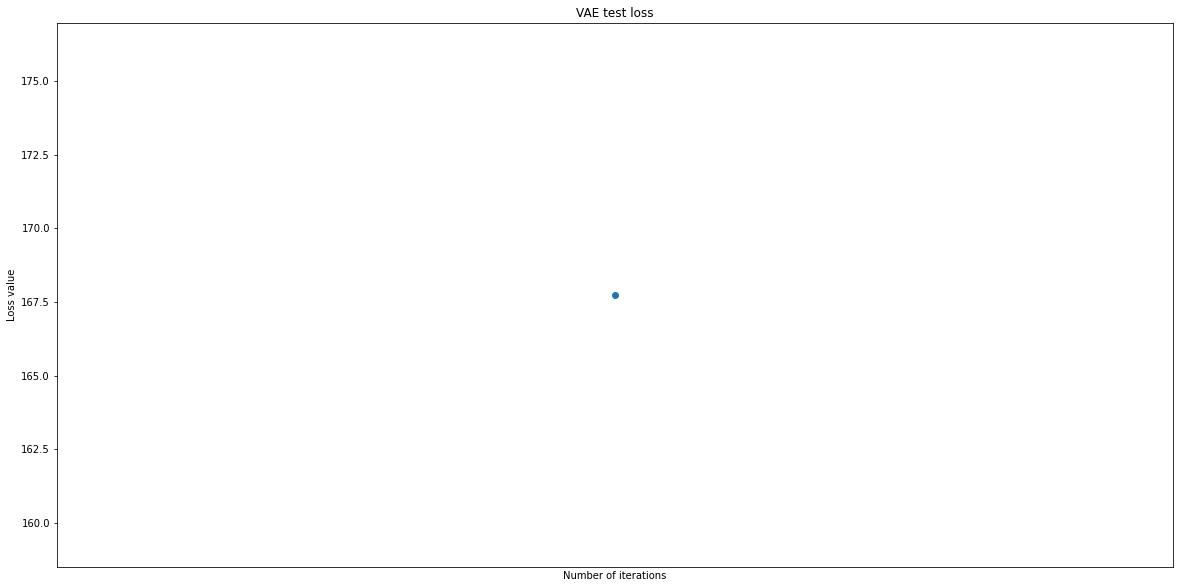

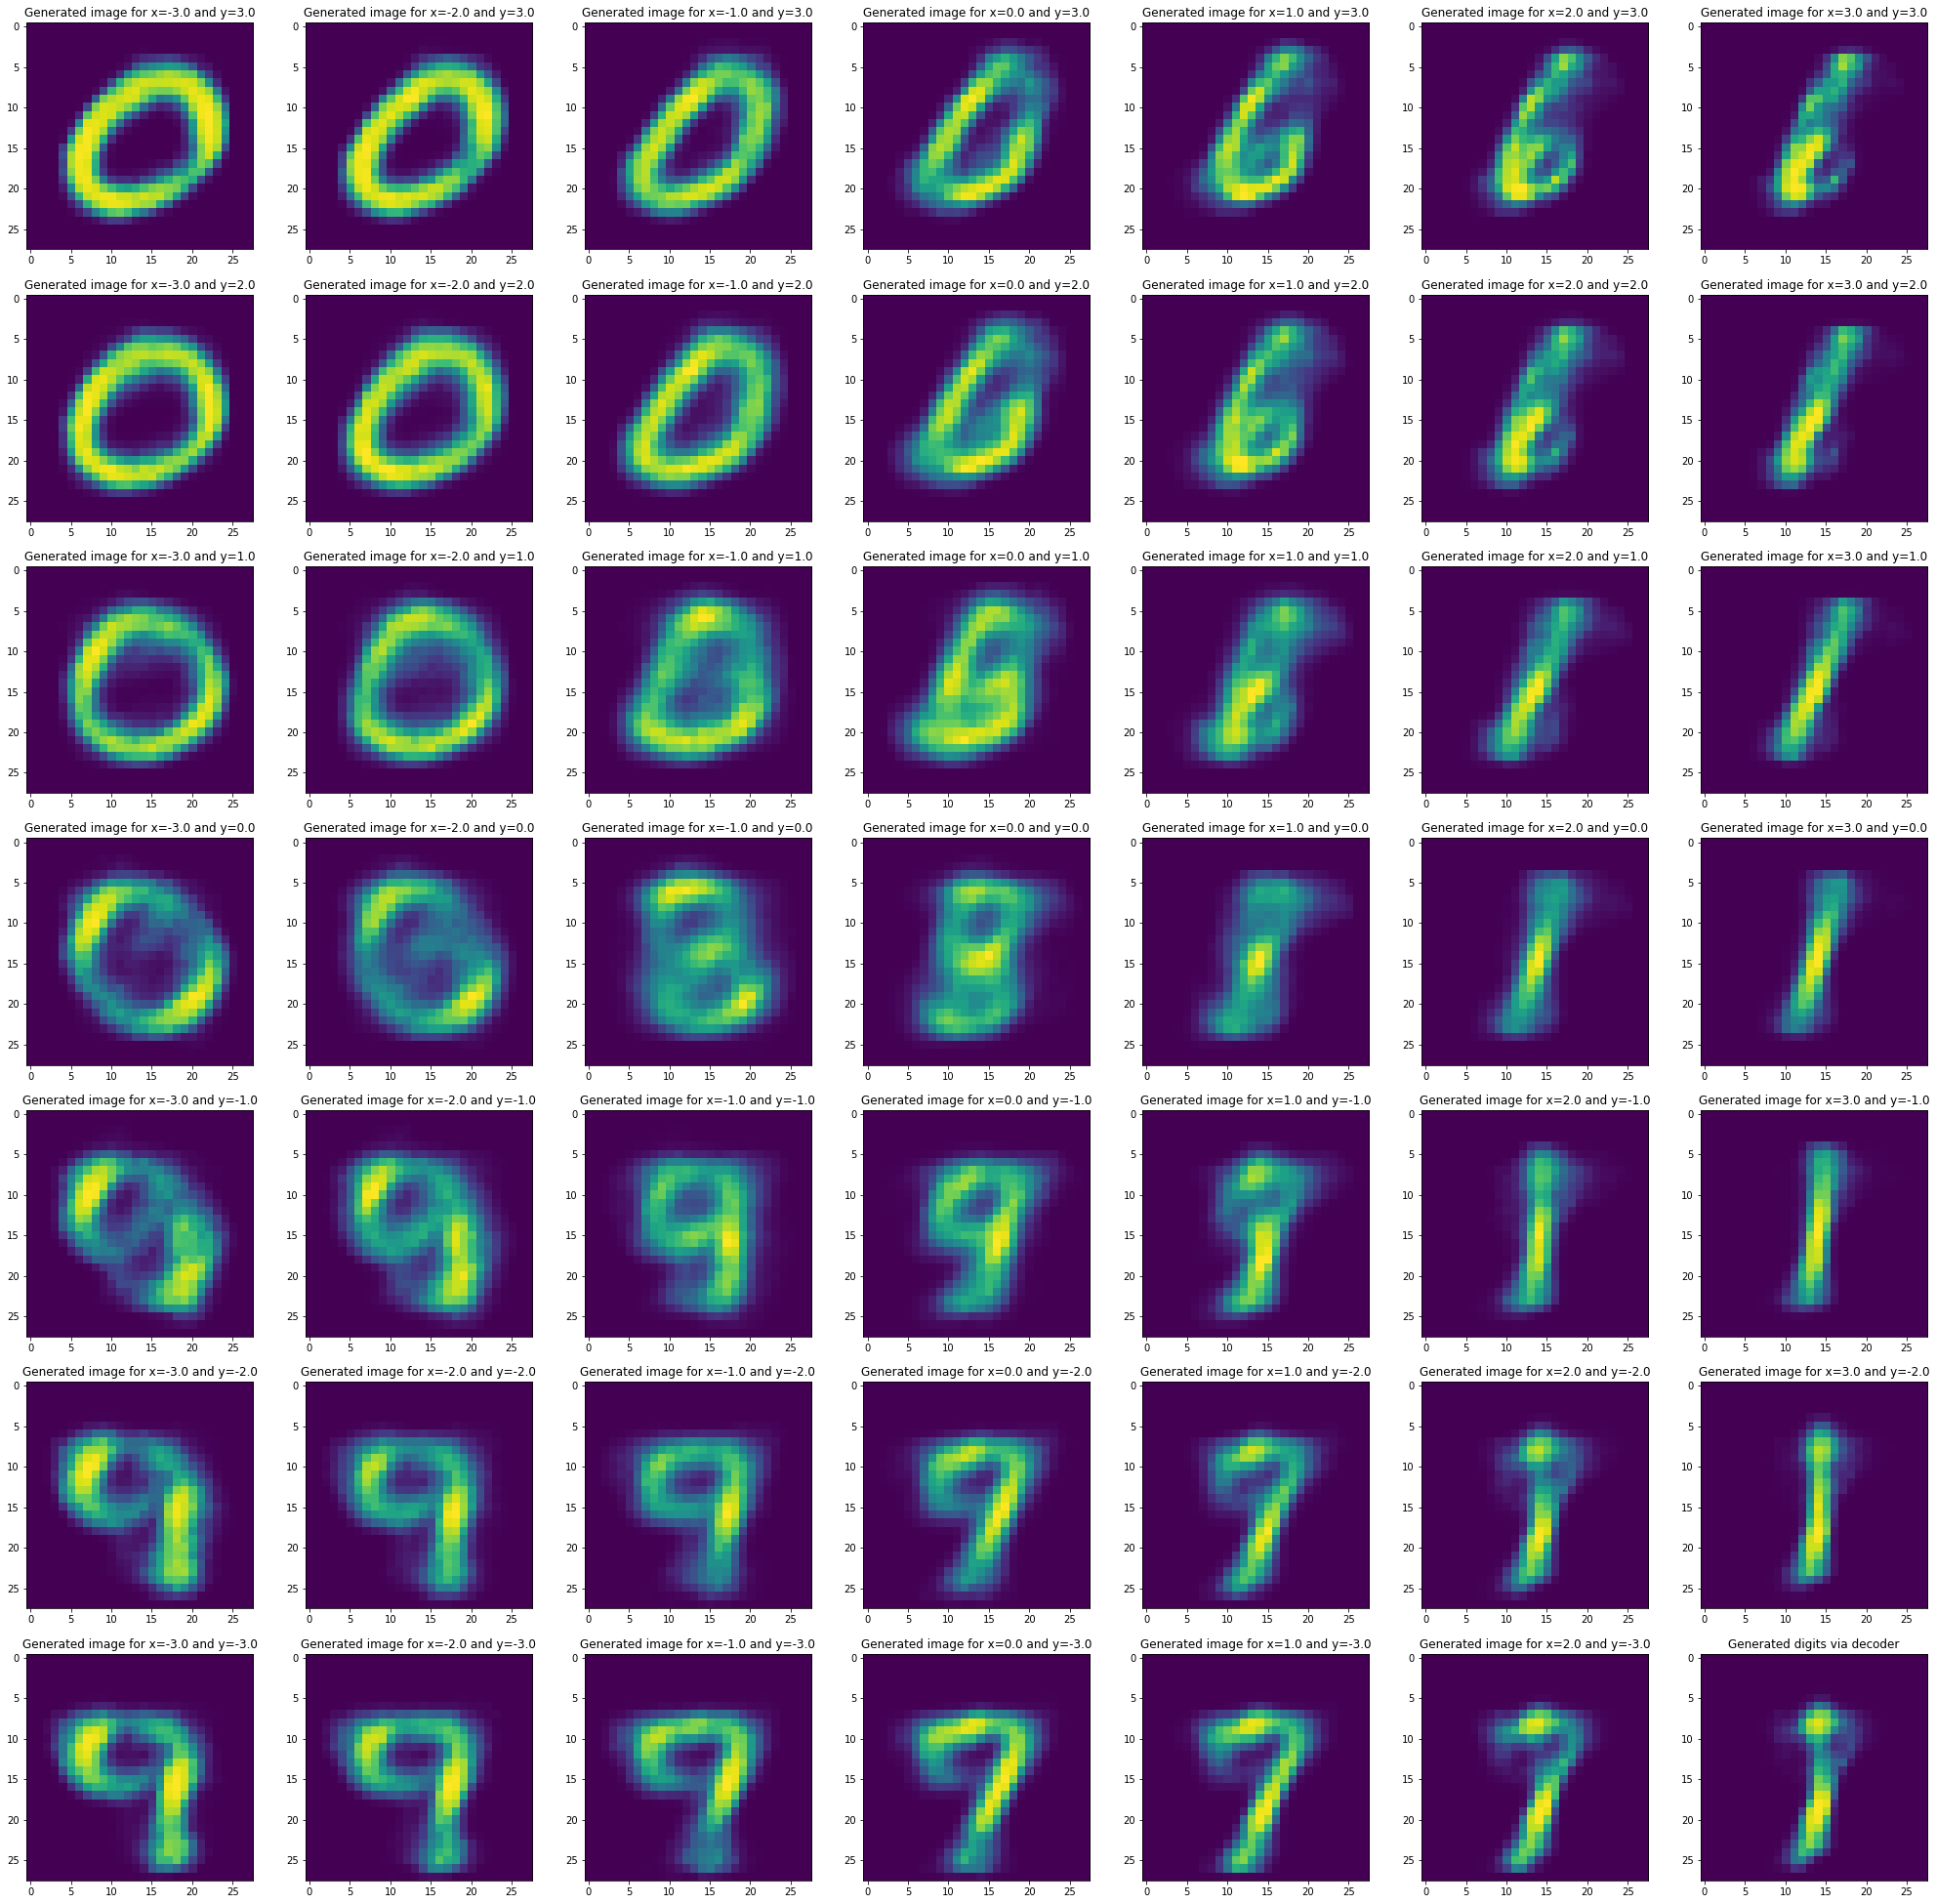

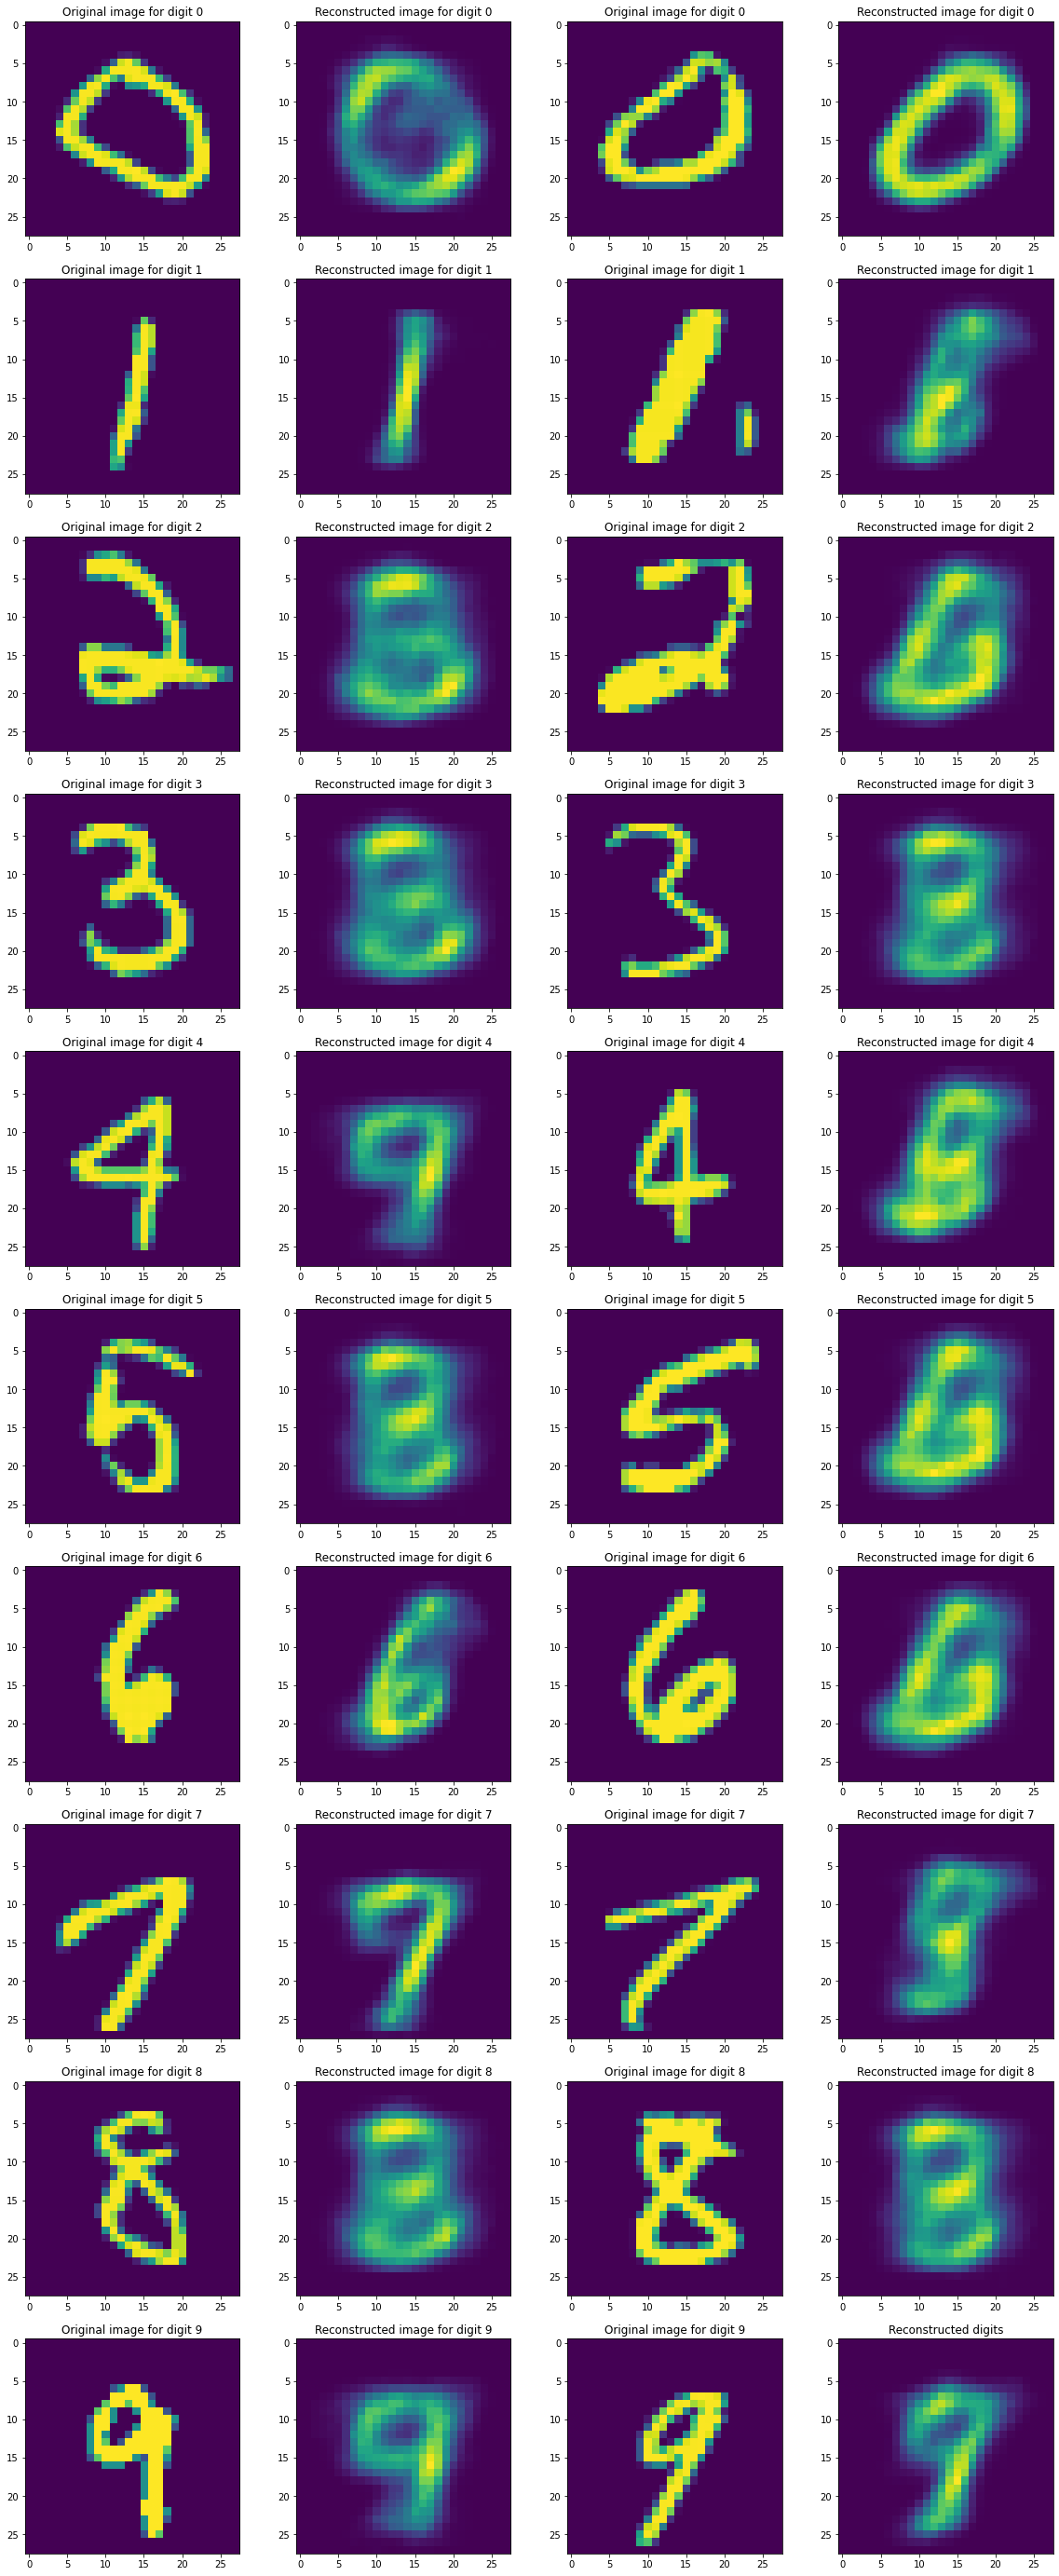

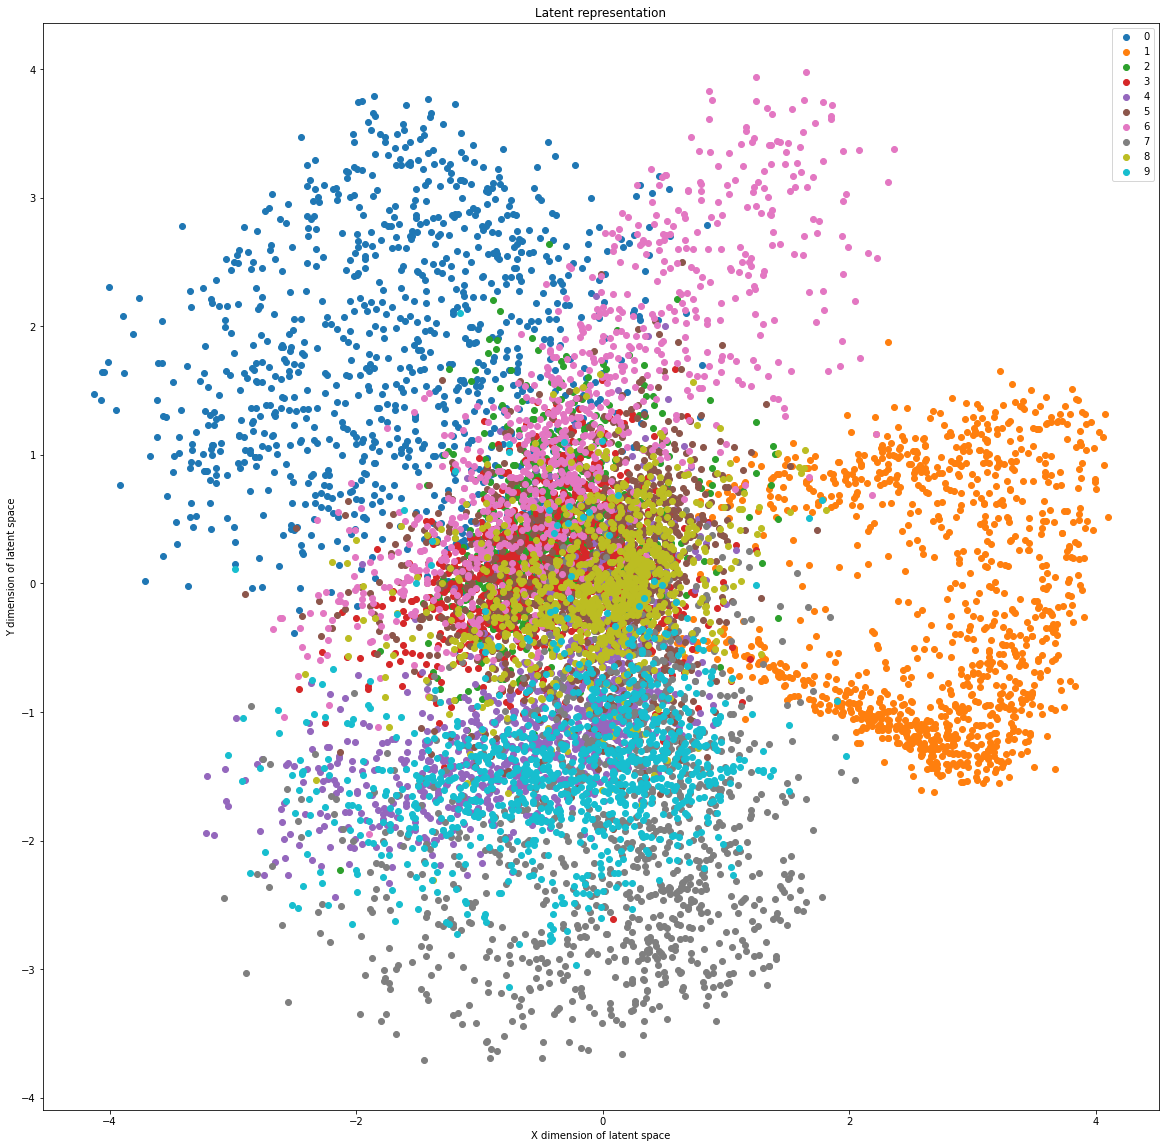

In [11]:
run(latent_dim=2, epochs=1)

Epoch 1/5
469/469 [==============================] - 3s 5ms/step - loss: 190.5661 - val_loss: 167.6484
Epoch 2/5
469/469 [==============================] - 2s 5ms/step - loss: 162.4406 - val_loss: 158.2315
Epoch 3/5
469/469 [==============================] - 2s 5ms/step - loss: 157.0760 - val_loss: 155.2652
Epoch 4/5
469/469 [==============================] - 2s 5ms/step - loss: 154.4087 - val_loss: 153.1895
Epoch 5/5
469/469 [==============================] - 2s 5ms/step - loss: 152.3246 - val_loss: 151.0690


Validation Loss after 5 epochs: 151.06903076171875




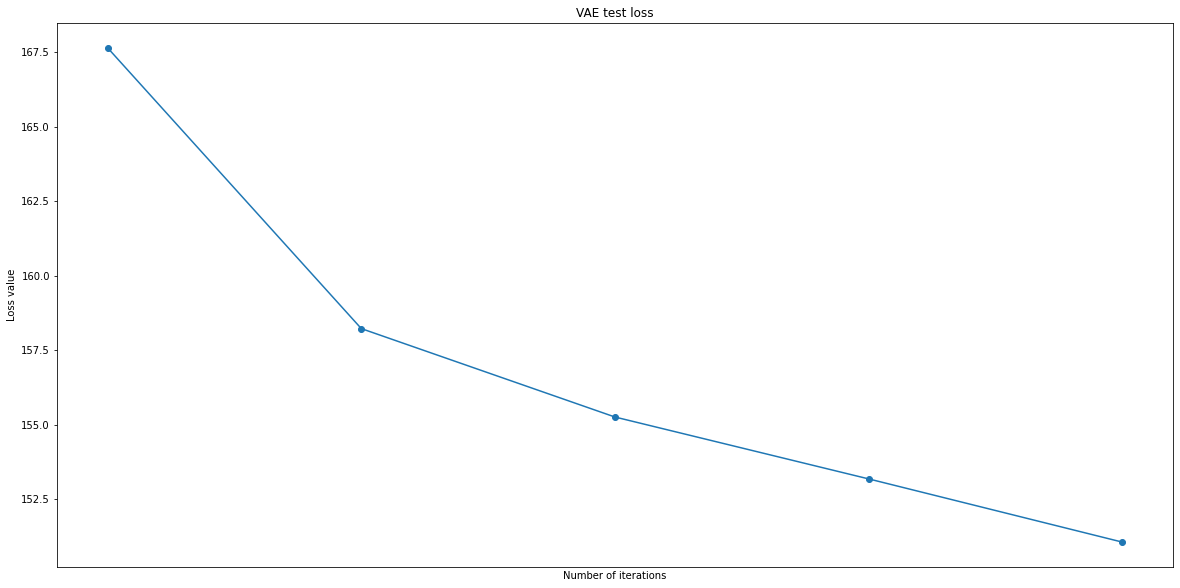

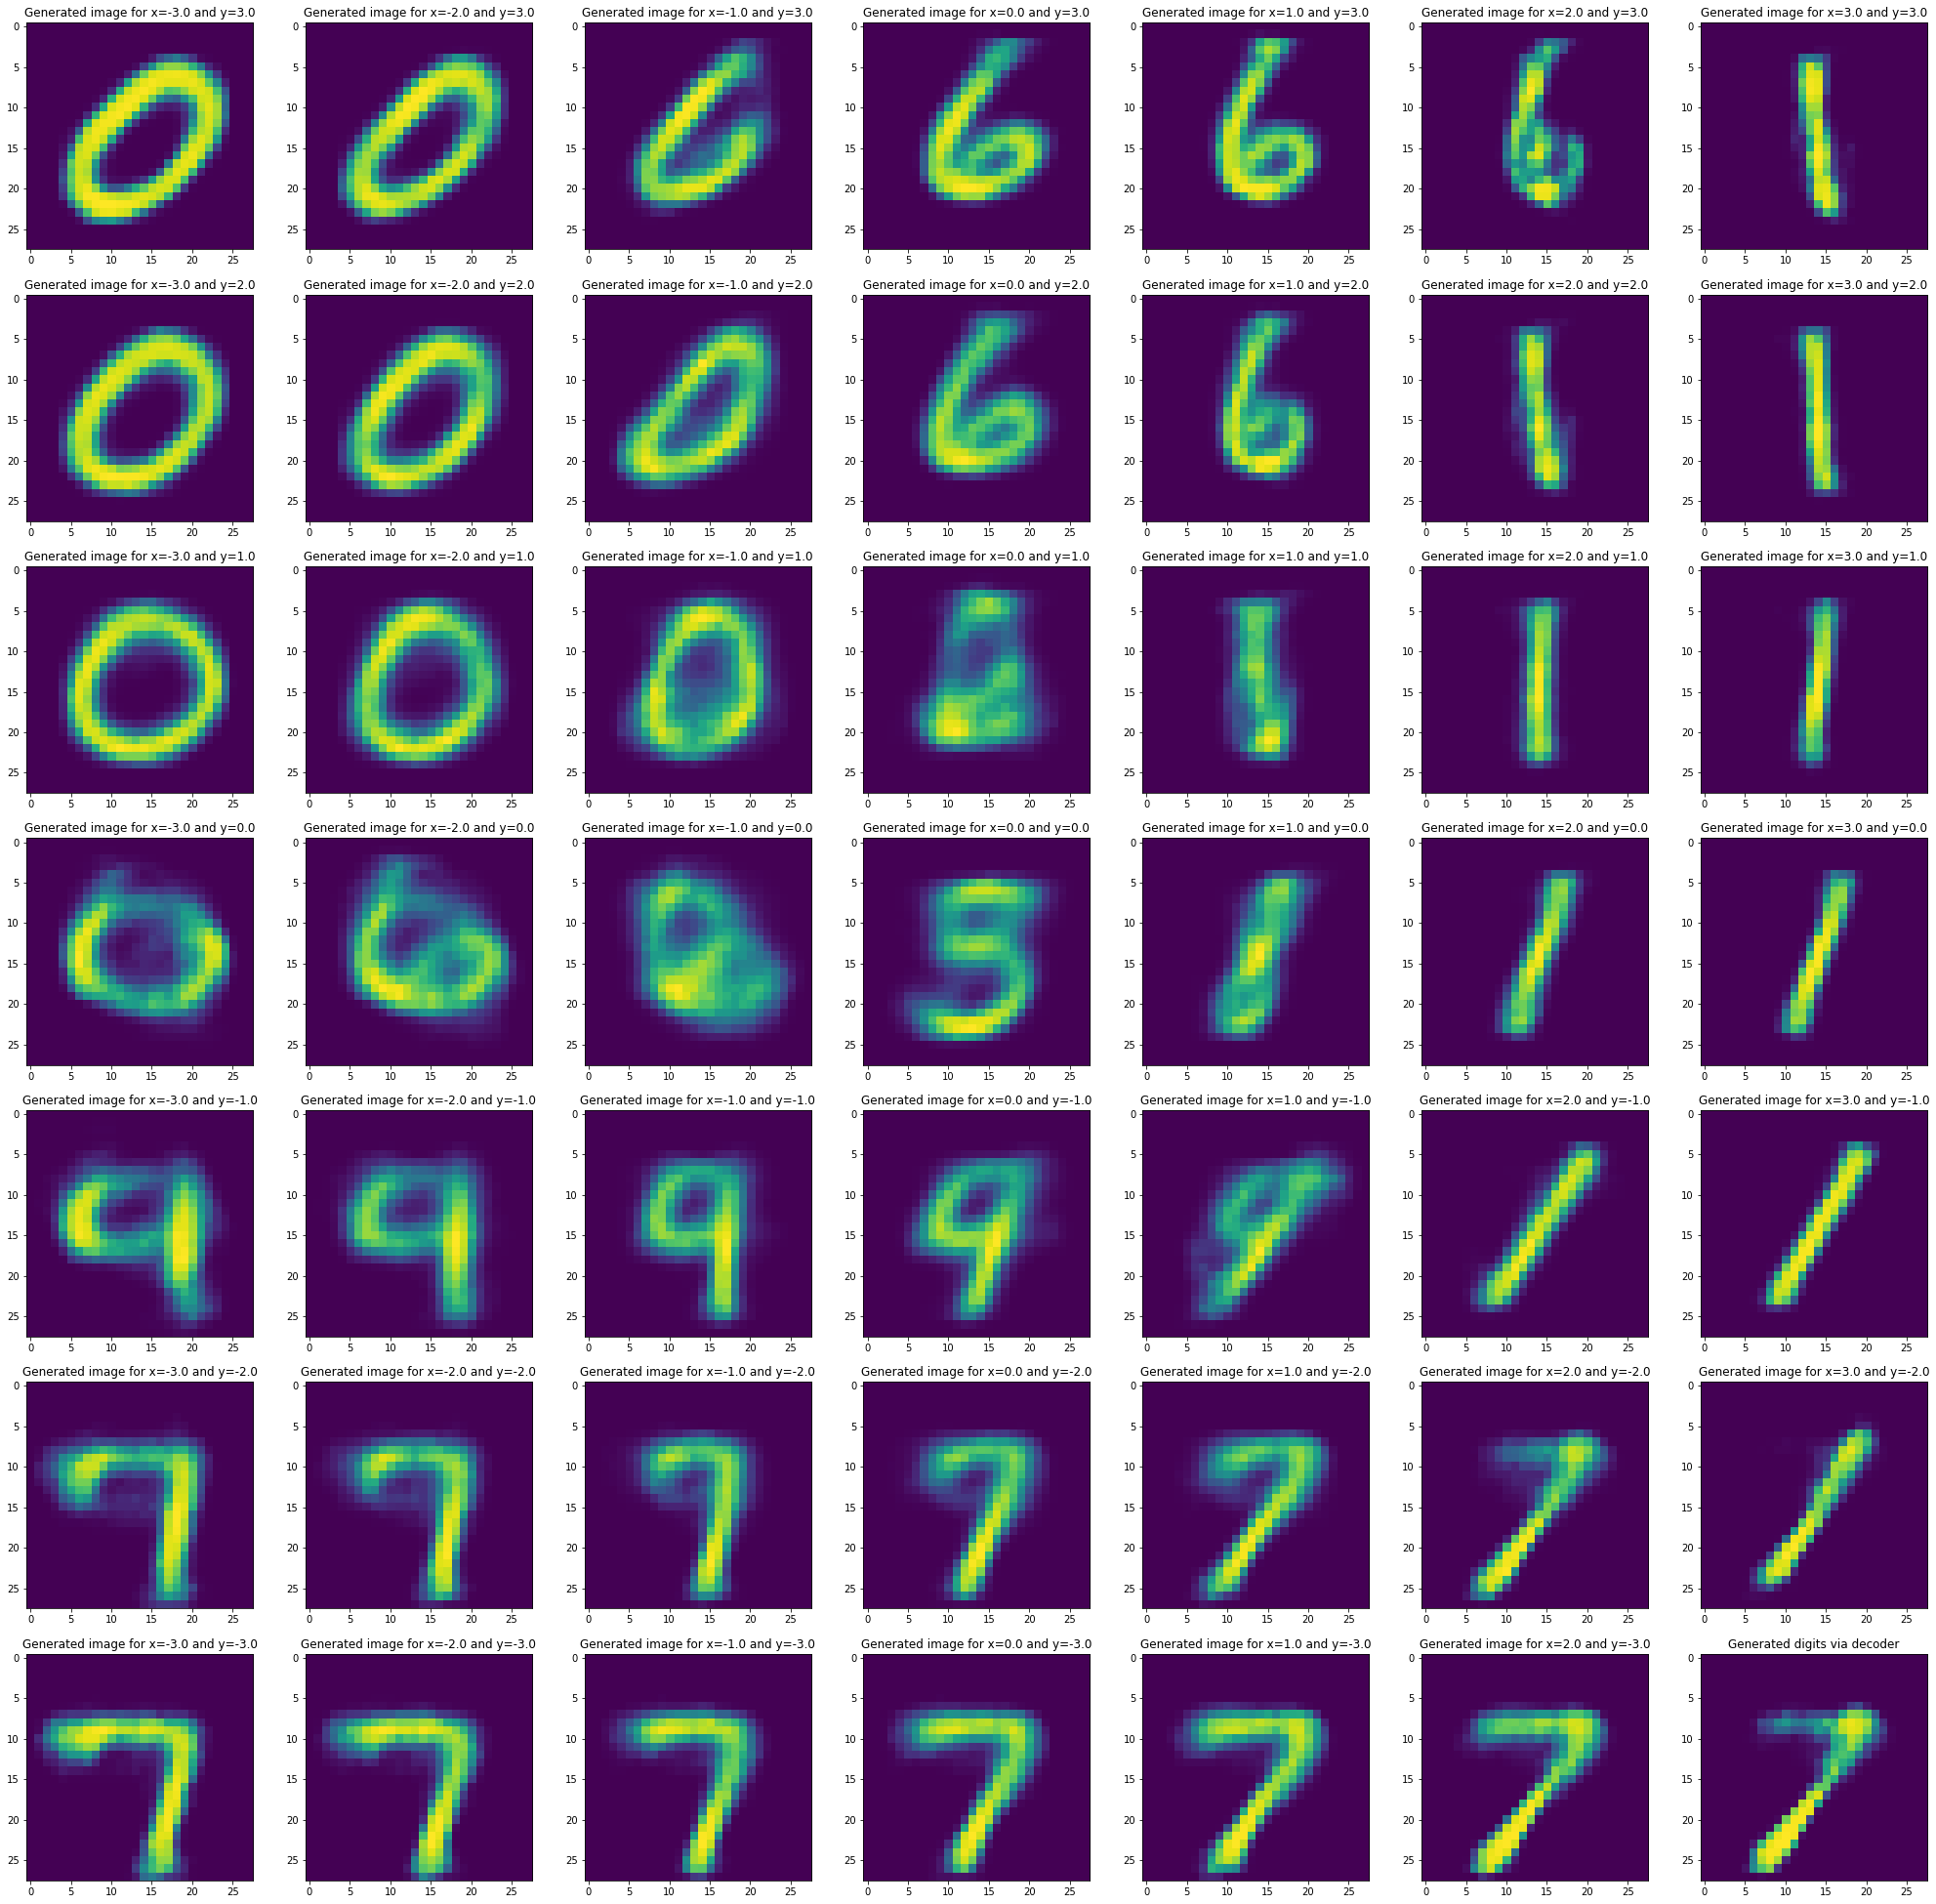

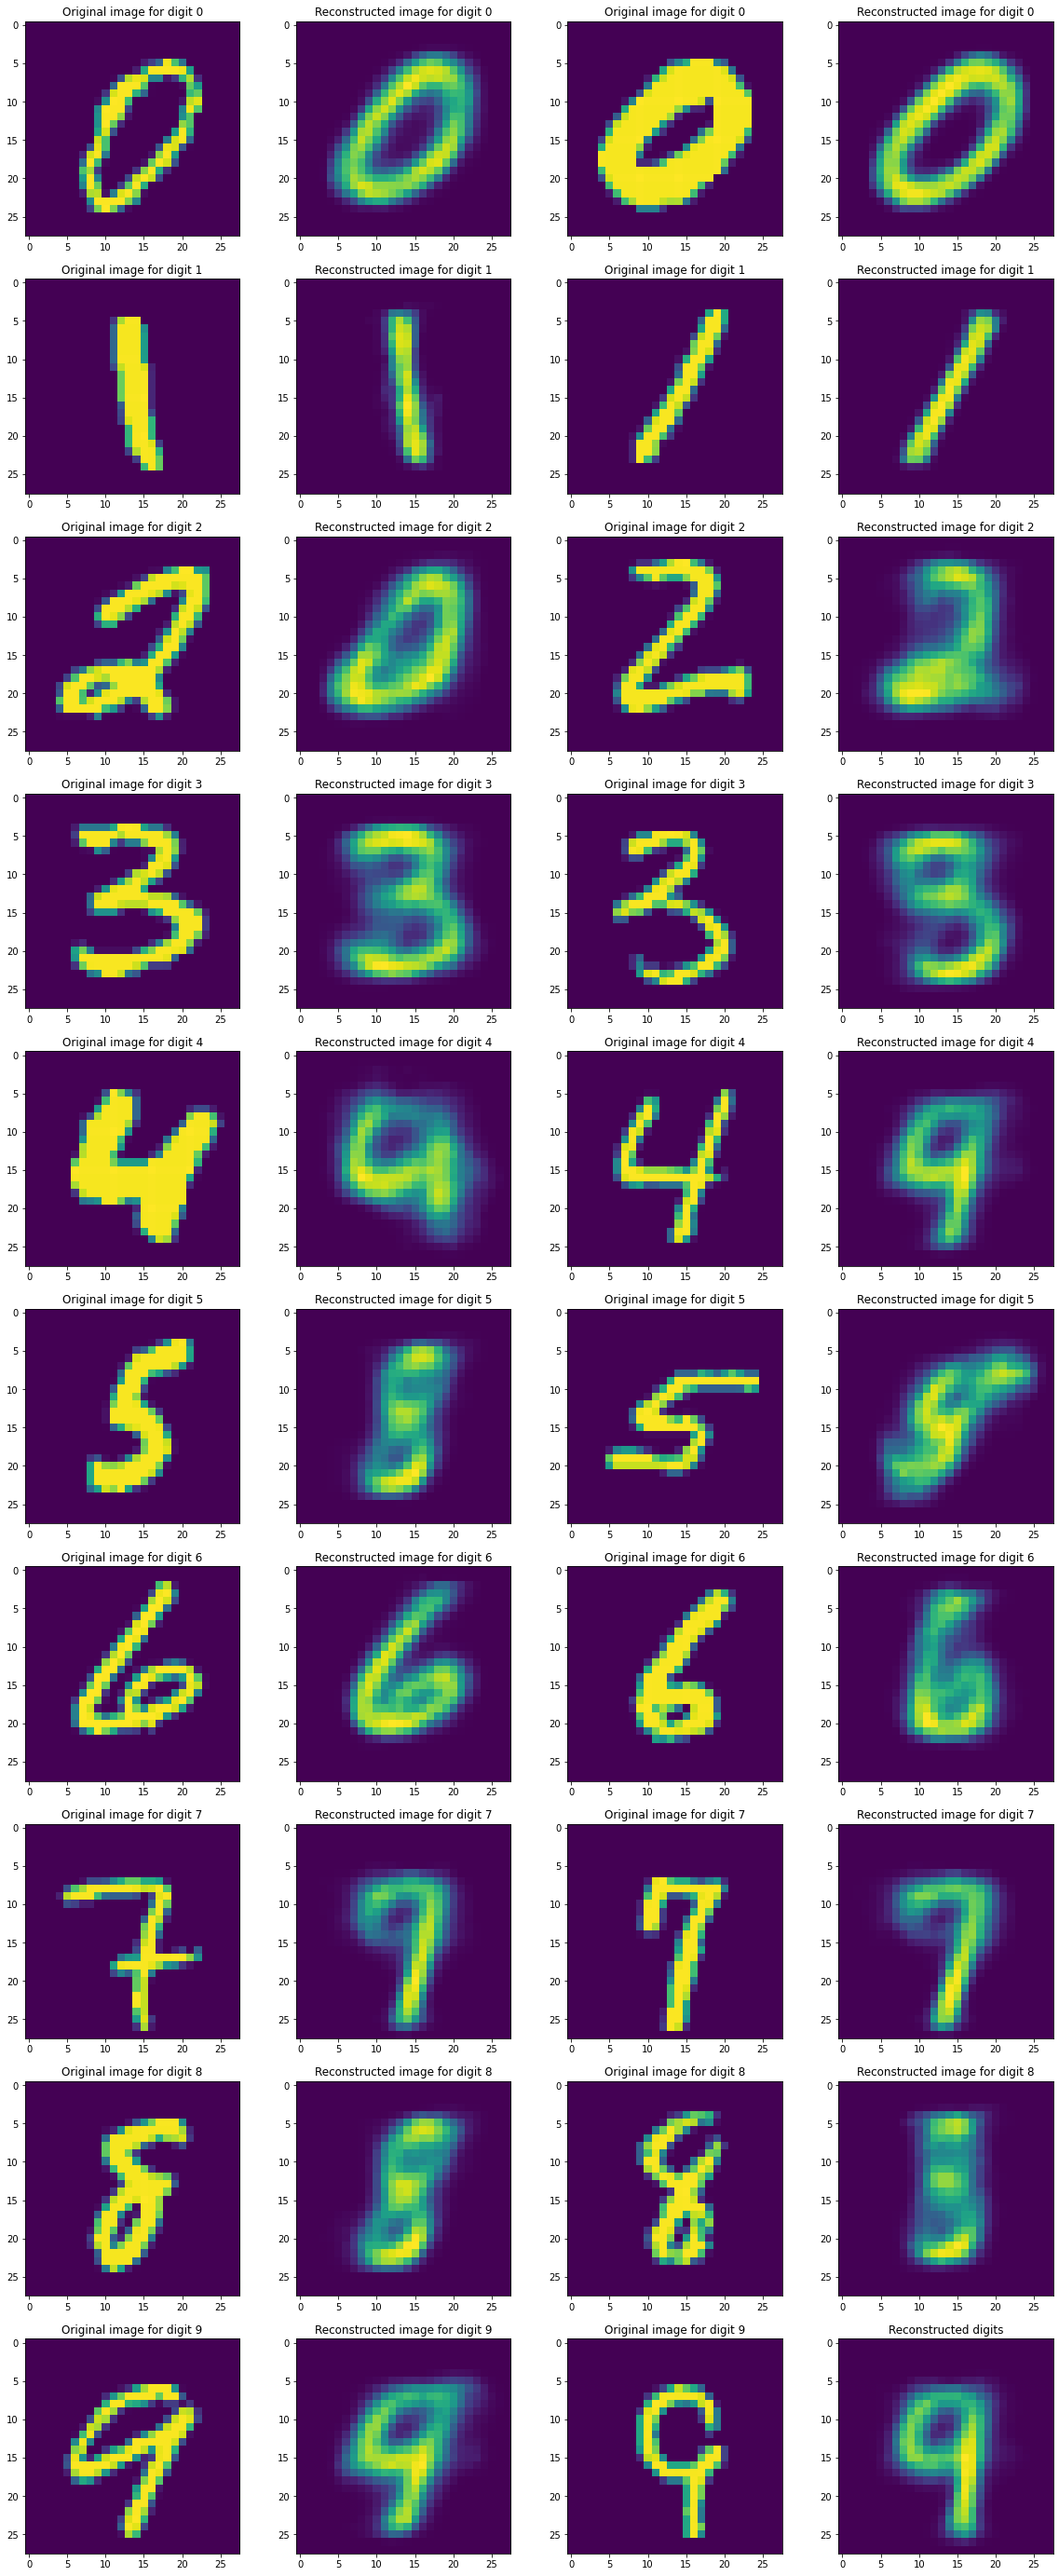

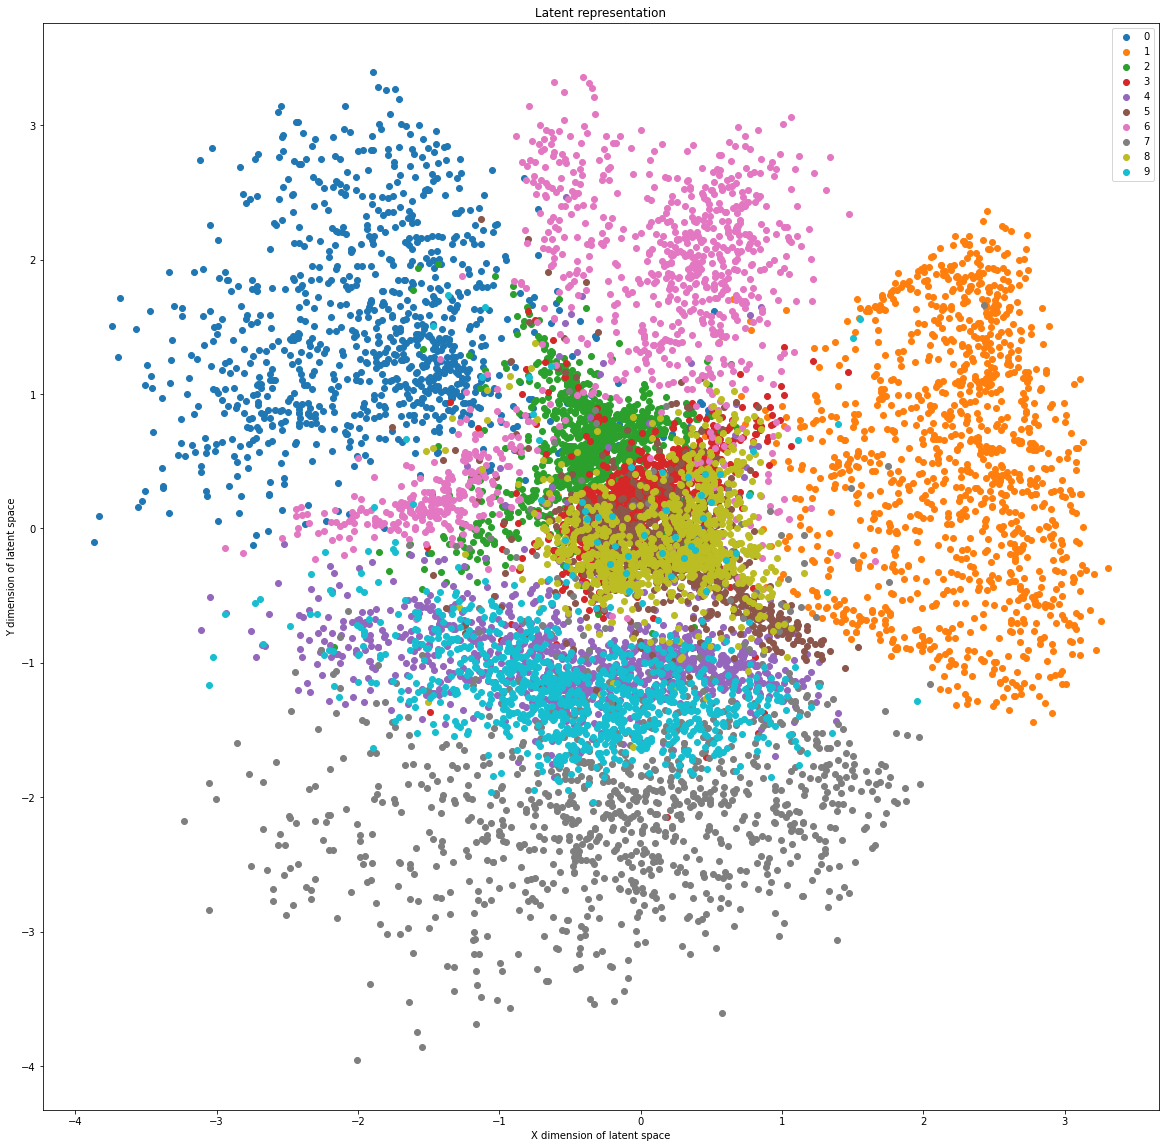

In [12]:
run(latent_dim=2, epochs=5)

Epoch 1/25
469/469 [==============================] - 3s 5ms/step - loss: 193.4801 - val_loss: 171.5345
Epoch 2/25
469/469 [==============================] - 2s 5ms/step - loss: 166.9629 - val_loss: 163.3310
Epoch 3/25
469/469 [==============================] - 2s 5ms/step - loss: 161.5167 - val_loss: 159.6665
Epoch 4/25
469/469 [==============================] - 2s 5ms/step - loss: 158.1808 - val_loss: 156.7287
Epoch 5/25
469/469 [==============================] - 2s 5ms/step - loss: 155.4241 - val_loss: 154.4259
Epoch 6/25
469/469 [==============================] - 2s 5ms/step - loss: 153.1992 - val_loss: 152.4123
Epoch 7/25
469/469 [==============================] - 2s 4ms/step - loss: 151.2684 - val_loss: 151.0259
Epoch 8/25
469/469 [==============================] - 2s 5ms/step - loss: 149.7415 - val_loss: 149.2967
Epoch 9/25
469/469 [==============================] - 2s 5ms/step - loss: 148.6192 - val_loss: 148.5683
Epoch 10/25
469/469 [==============================] - 2s 5ms/st

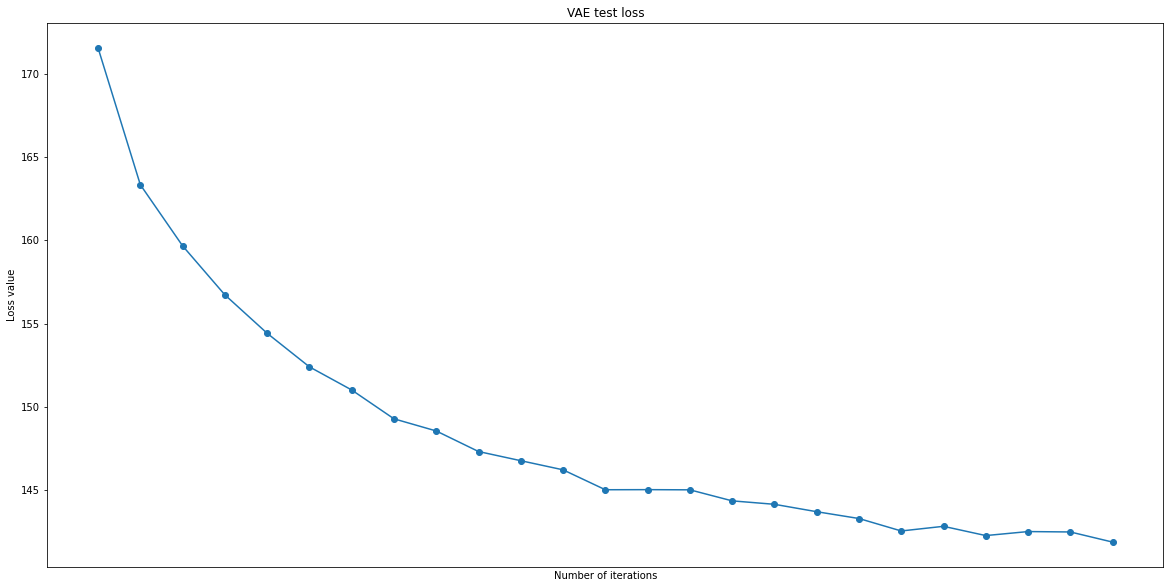

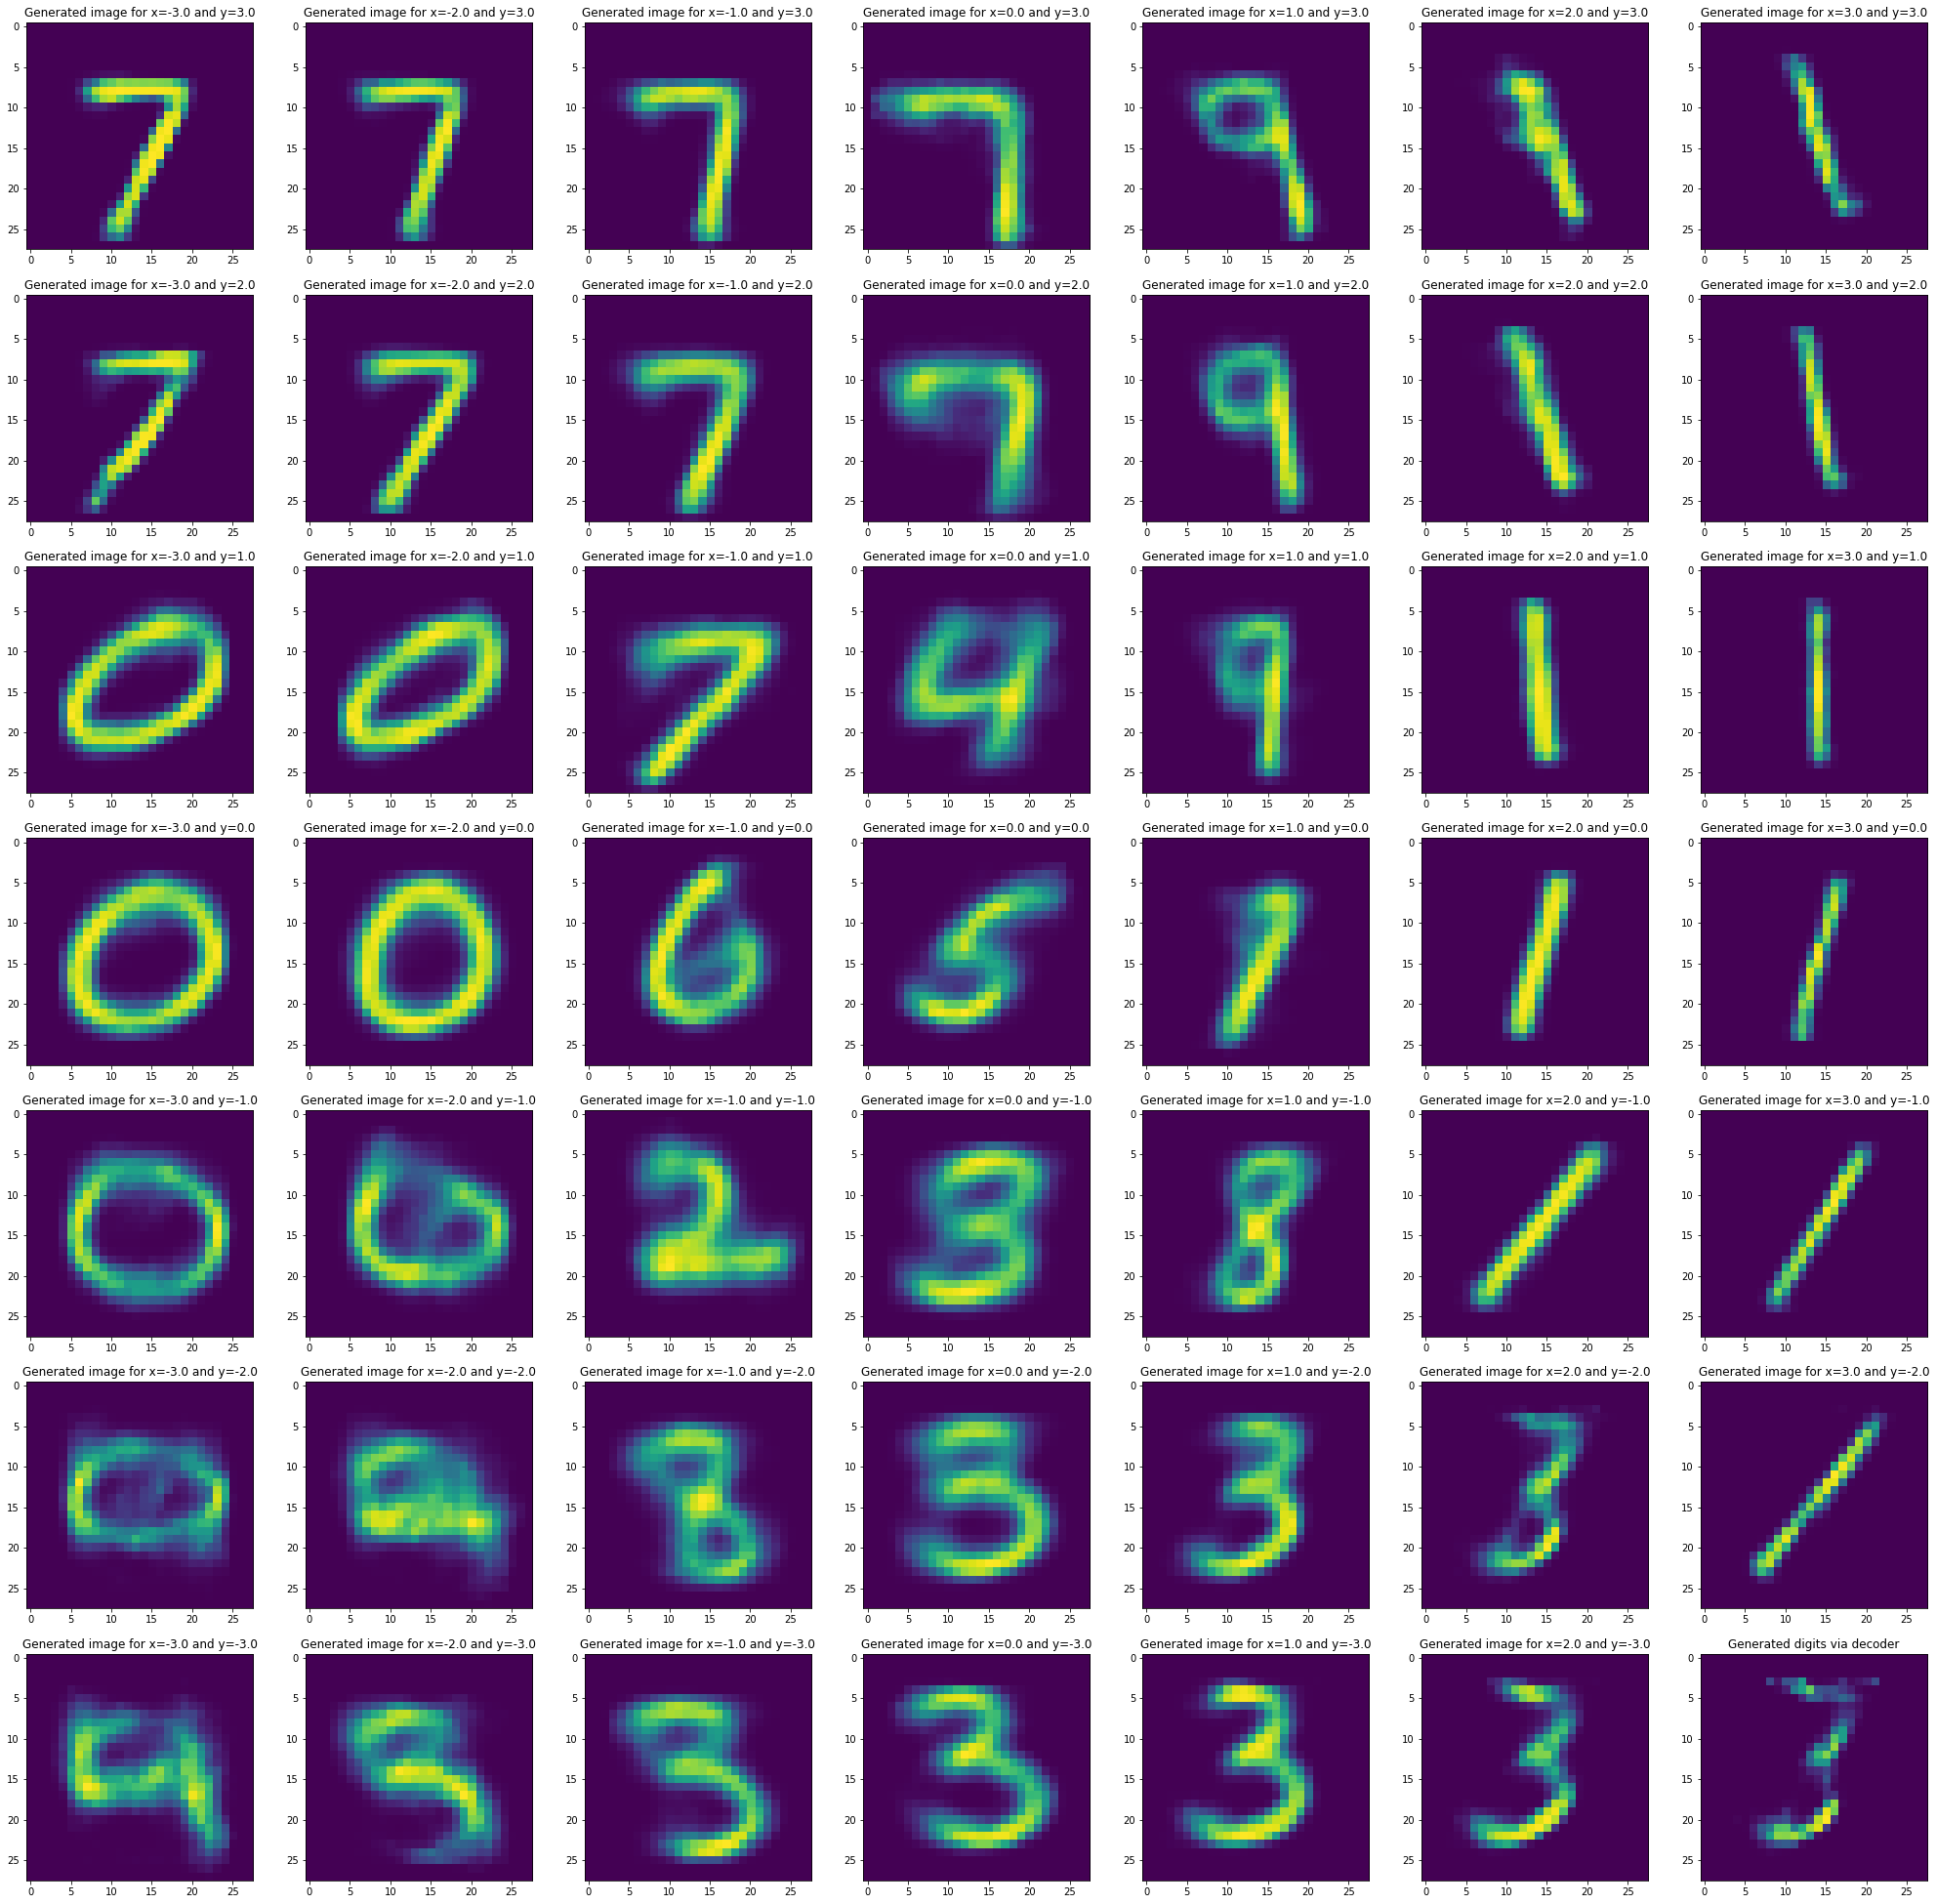

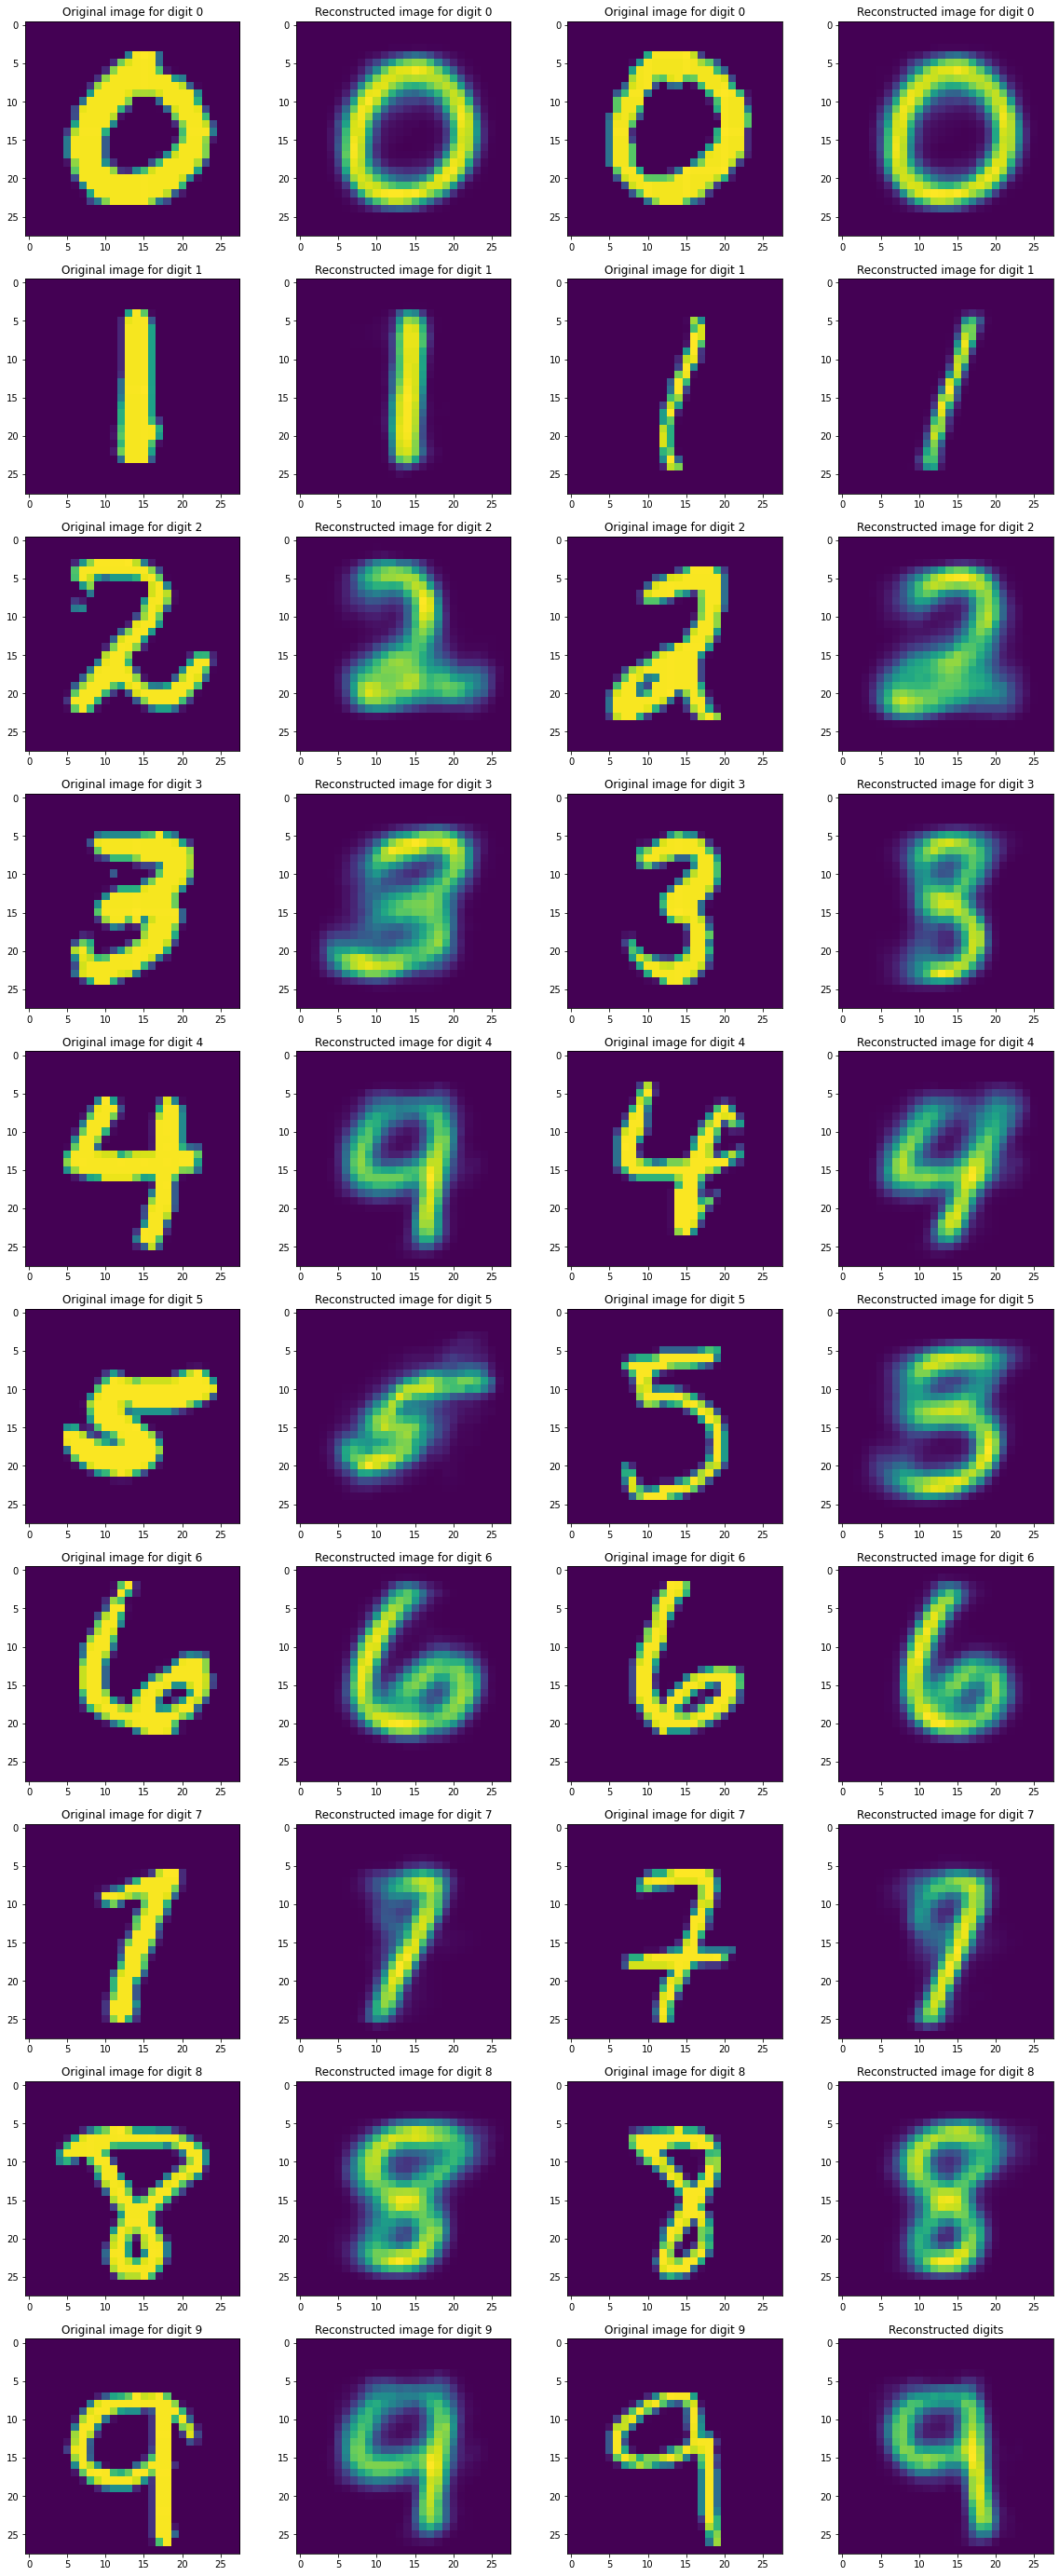

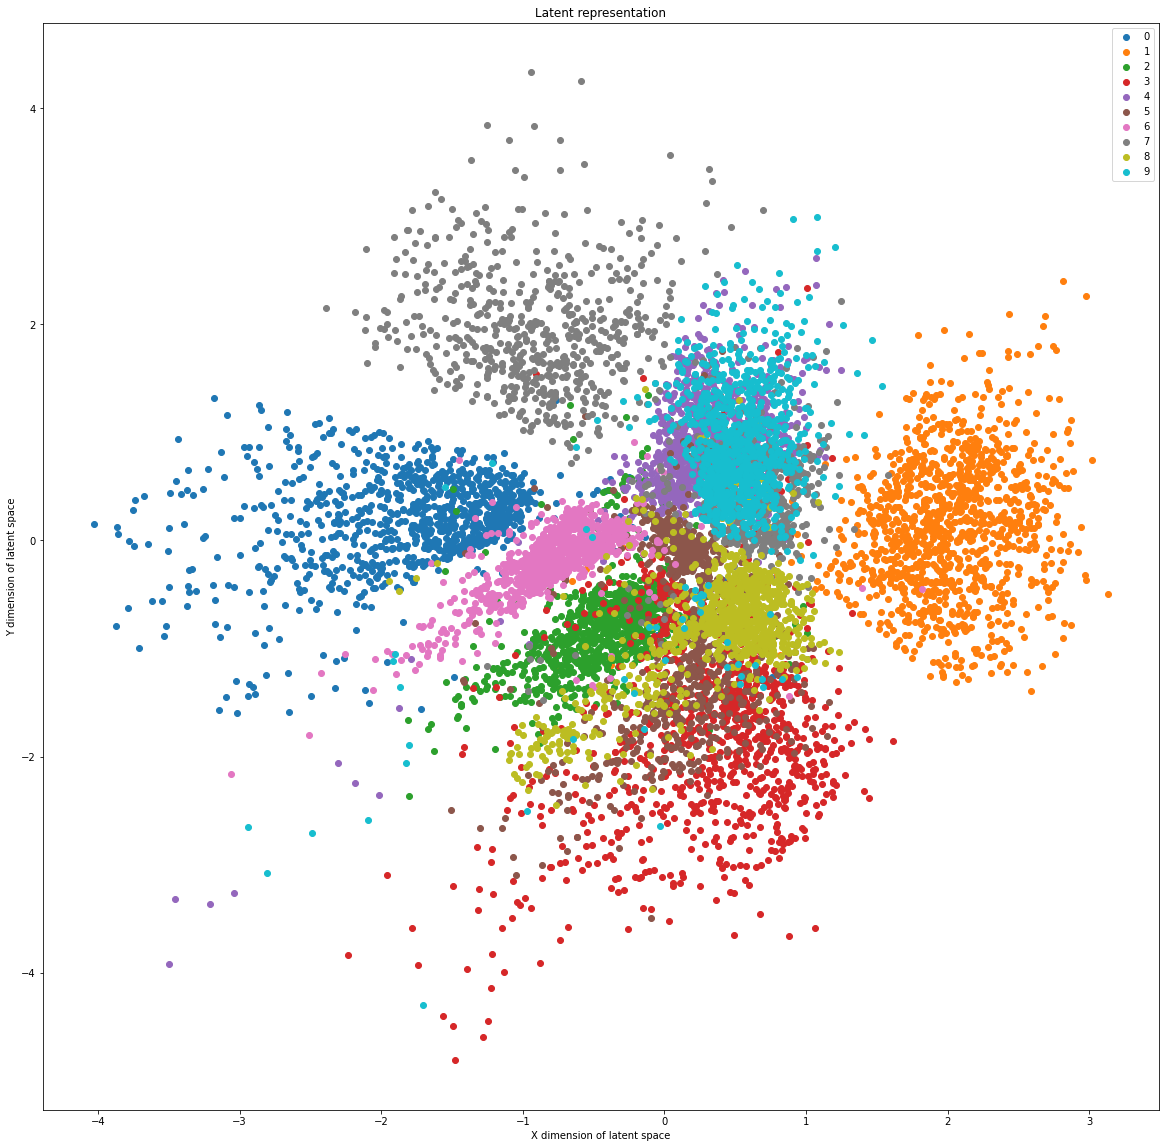

In [13]:
run(latent_dim=2, epochs=25)

Epoch 1/50
469/469 [==============================] - 3s 5ms/step - loss: 190.8672 - val_loss: 168.6469
Epoch 2/50
469/469 [==============================] - 2s 5ms/step - loss: 165.5074 - val_loss: 162.9795
Epoch 3/50
469/469 [==============================] - 2s 5ms/step - loss: 160.0450 - val_loss: 157.8816
Epoch 4/50
469/469 [==============================] - 2s 5ms/step - loss: 156.4974 - val_loss: 155.3436
Epoch 5/50
469/469 [==============================] - 2s 5ms/step - loss: 153.9426 - val_loss: 153.3665
Epoch 6/50
469/469 [==============================] - 2s 5ms/step - loss: 152.2599 - val_loss: 151.7407
Epoch 7/50
469/469 [==============================] - 2s 5ms/step - loss: 150.6525 - val_loss: 150.6455
Epoch 8/50
469/469 [==============================] - 2s 5ms/step - loss: 149.4507 - val_loss: 149.2000
Epoch 9/50
469/469 [==============================] - 2s 5ms/step - loss: 148.2990 - val_loss: 148.4817
Epoch 10/50
469/469 [==============================] - 2s 5ms/st

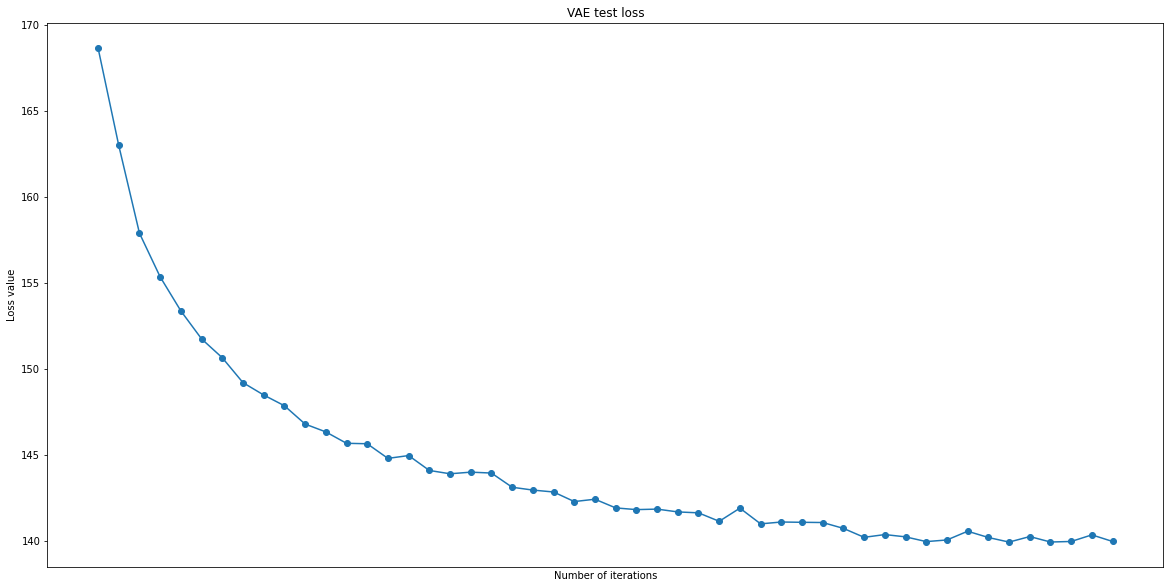

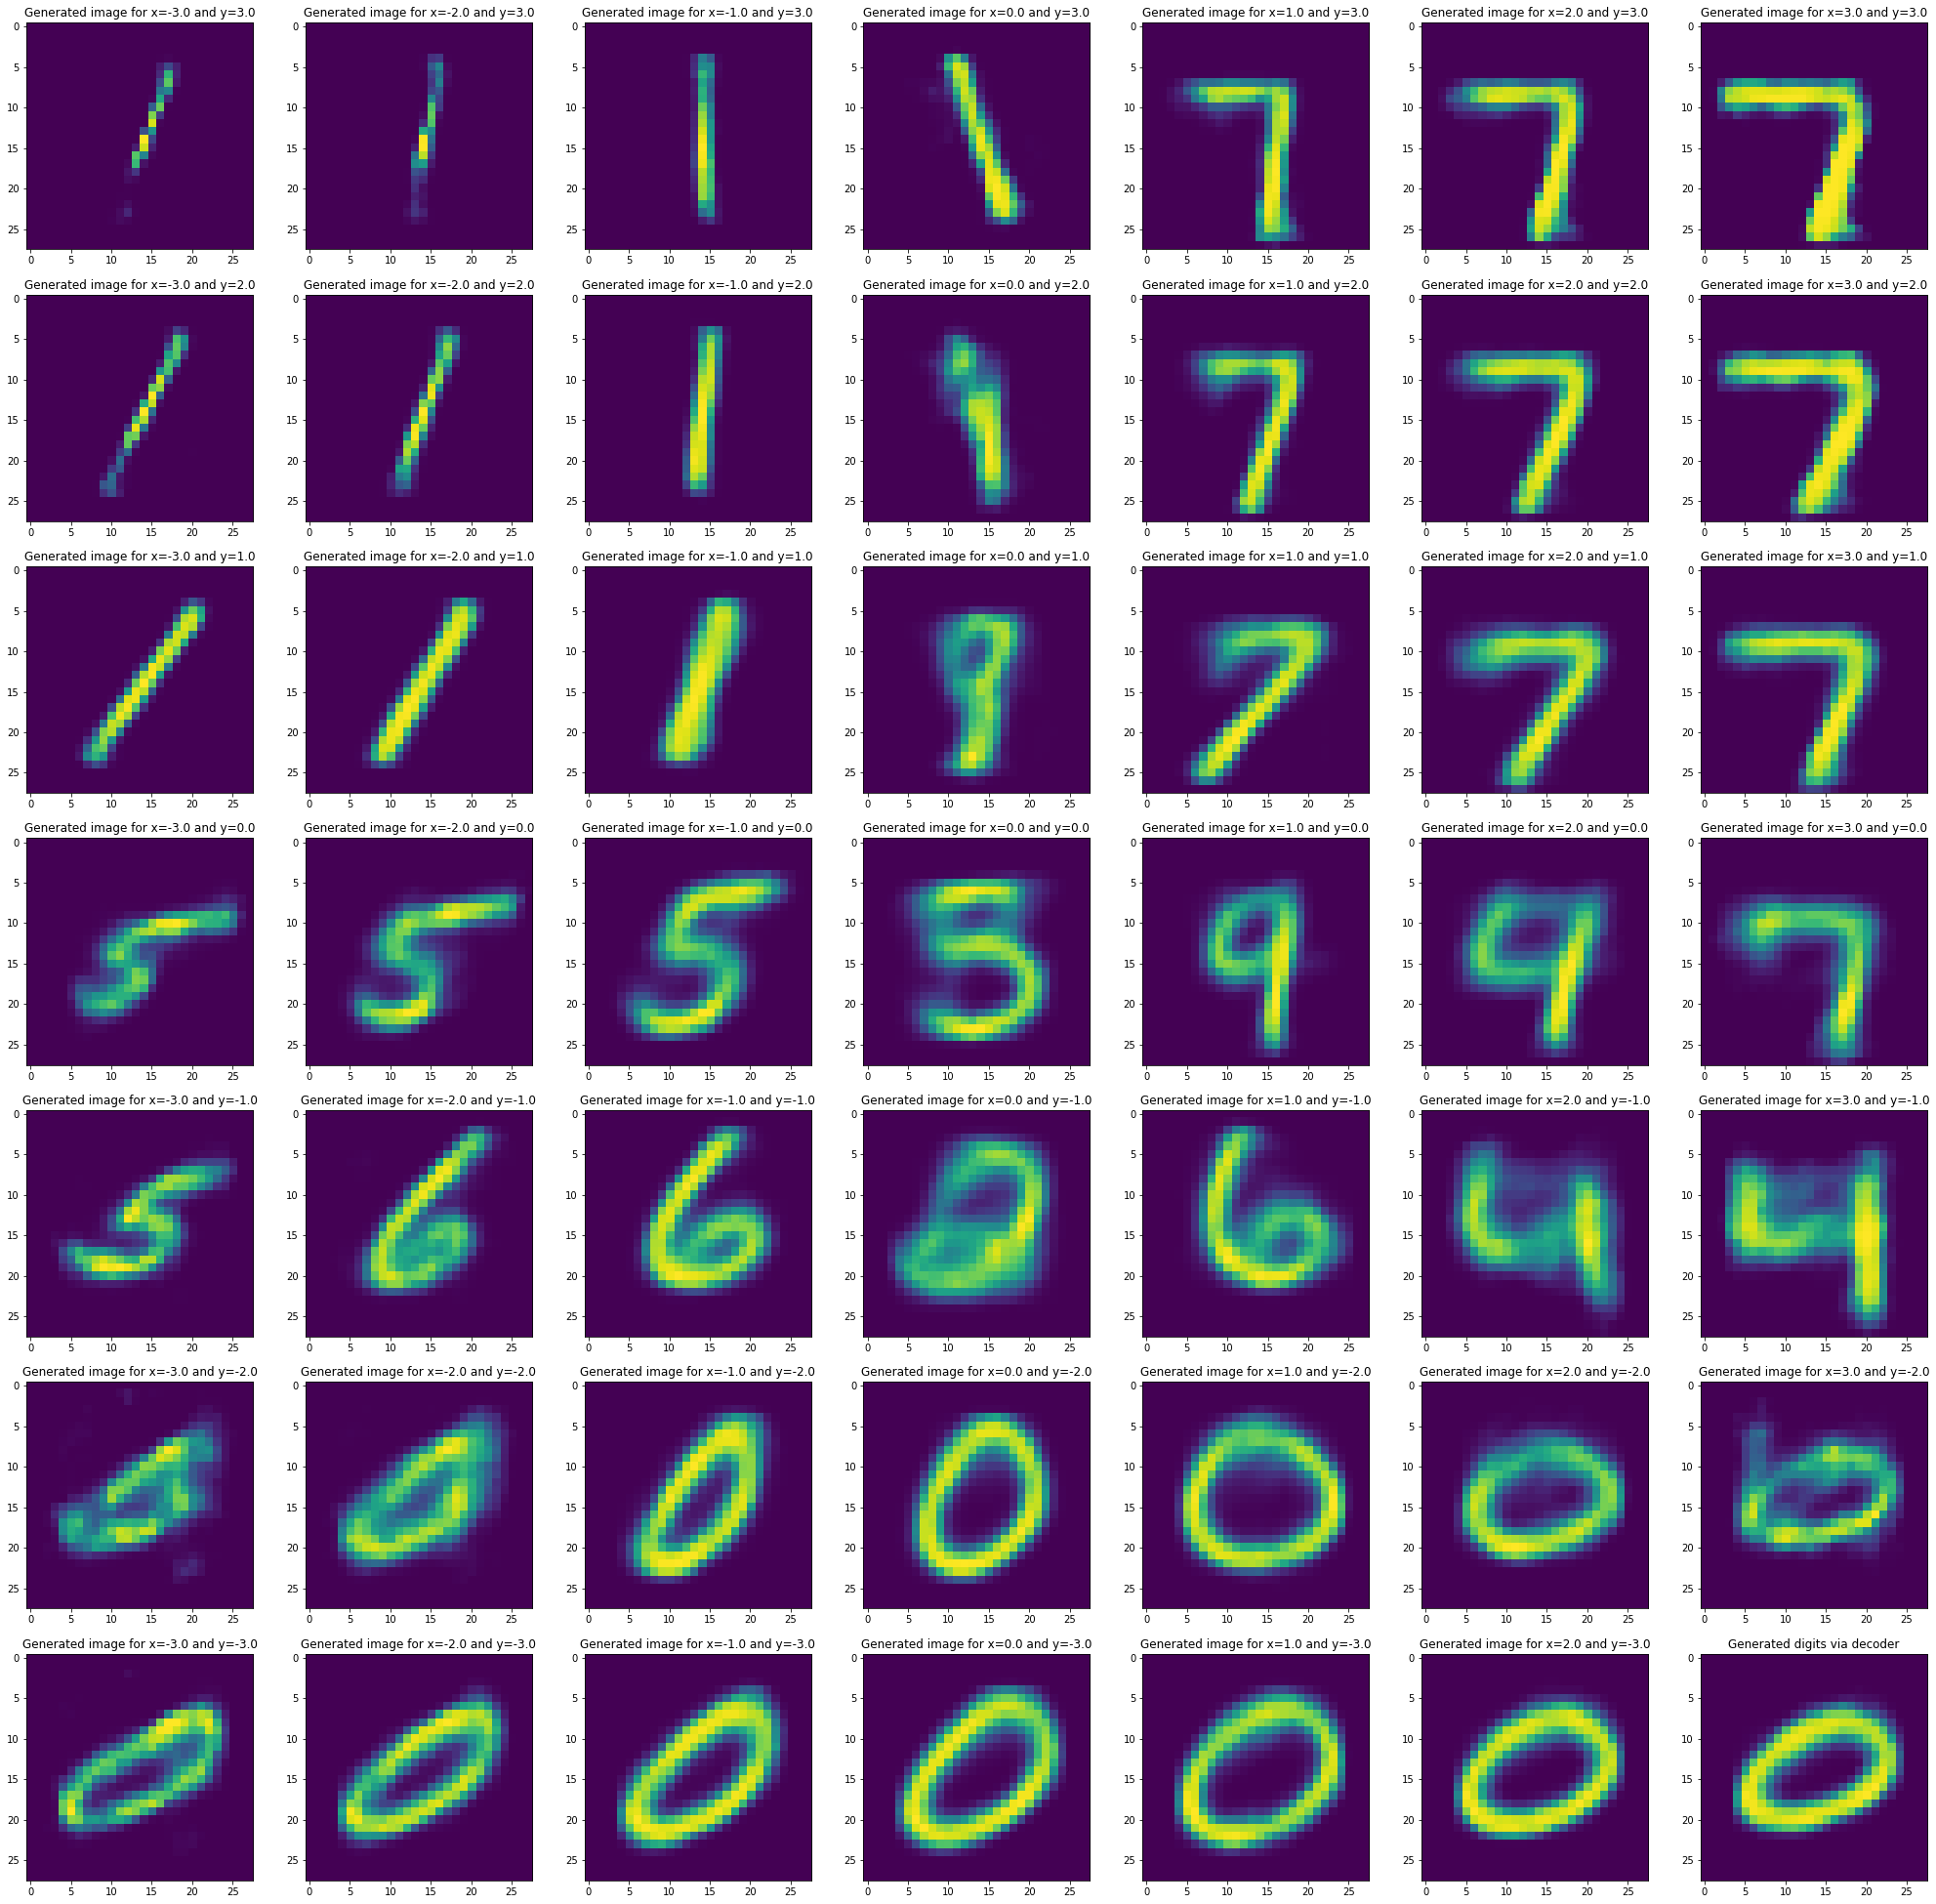

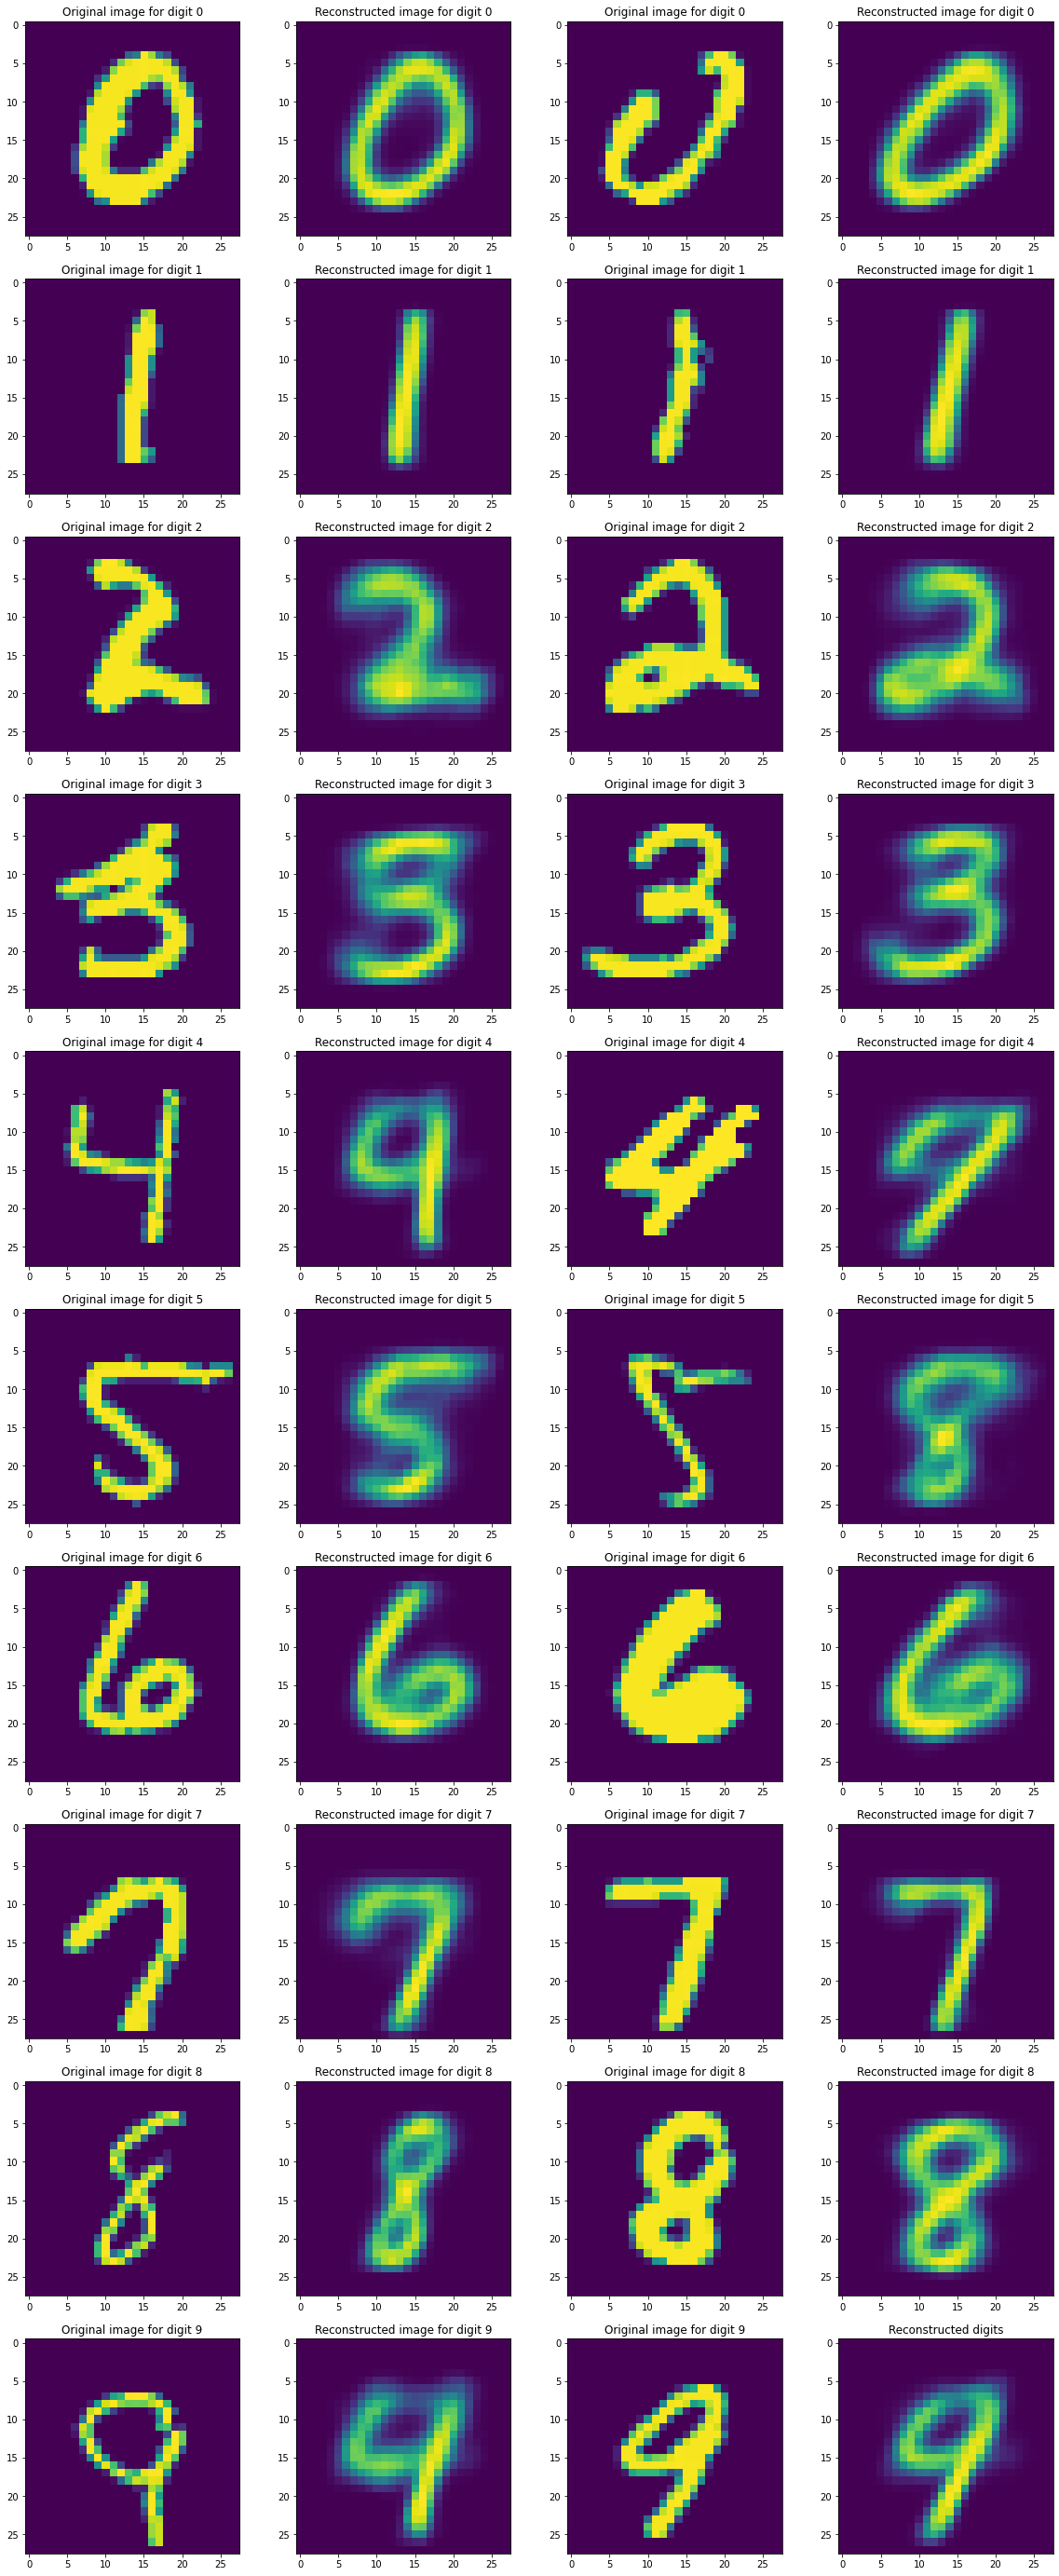

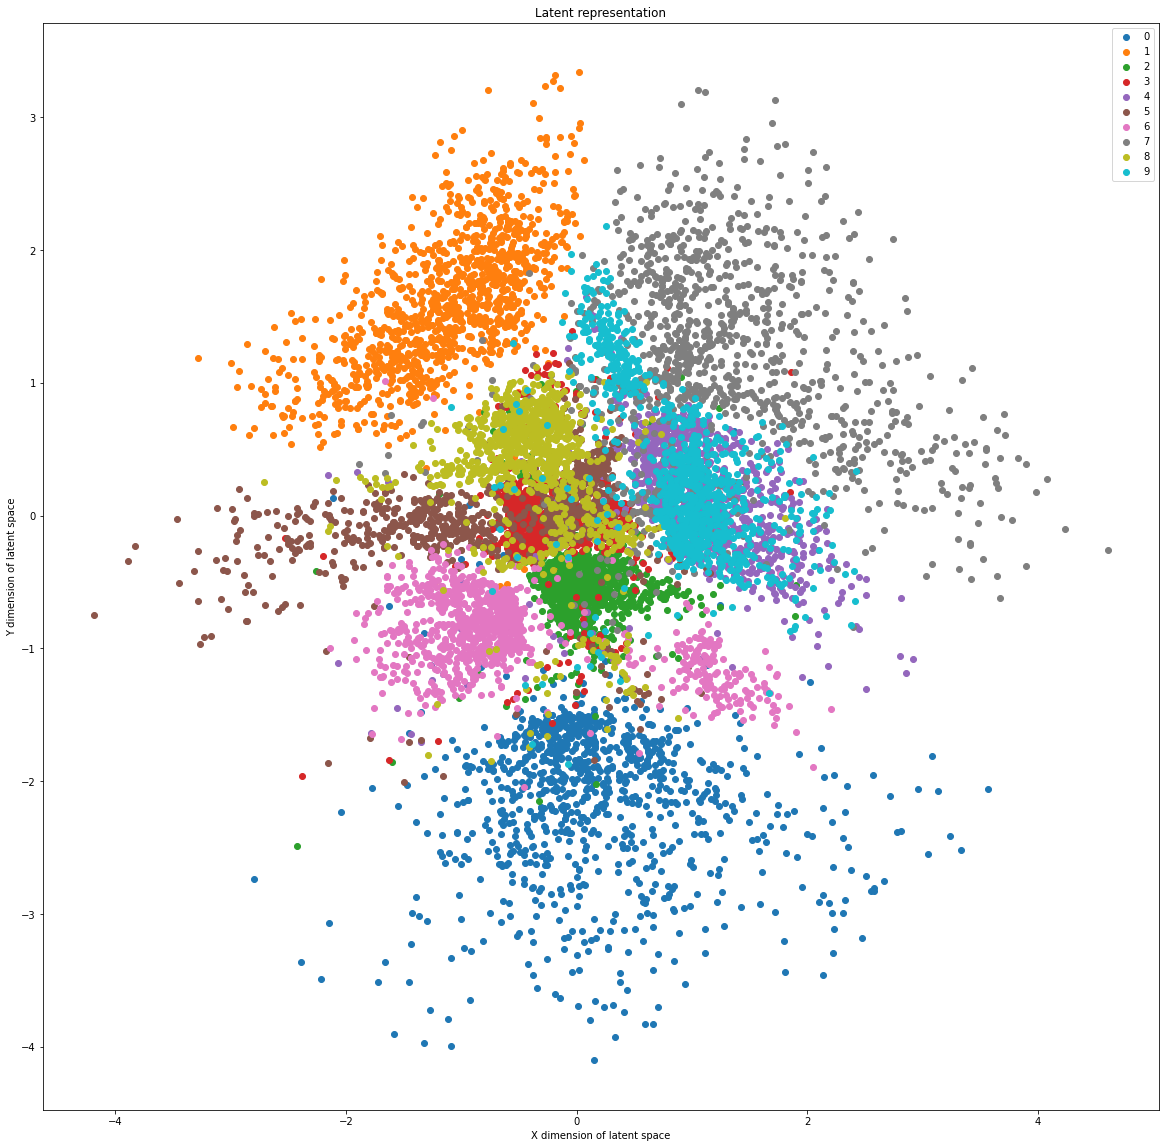

In [14]:
run(latent_dim=2, epochs=50)

Epoch 1/100
469/469 [==============================] - 3s 6ms/step - loss: 192.1110 - val_loss: 170.0621
Epoch 2/100
469/469 [==============================] - 2s 5ms/step - loss: 165.8263 - val_loss: 163.0630
Epoch 3/100
469/469 [==============================] - 2s 5ms/step - loss: 159.7661 - val_loss: 157.7371
Epoch 4/100
469/469 [==============================] - 2s 5ms/step - loss: 155.8426 - val_loss: 155.3784
Epoch 5/100
469/469 [==============================] - 2s 5ms/step - loss: 153.3634 - val_loss: 152.8854
Epoch 6/100
469/469 [==============================] - 2s 5ms/step - loss: 151.5715 - val_loss: 151.3418
Epoch 7/100
469/469 [==============================] - 2s 5ms/step - loss: 150.0361 - val_loss: 150.2805
Epoch 8/100
469/469 [==============================] - 2s 5ms/step - loss: 148.8167 - val_loss: 149.0568
Epoch 9/100
469/469 [==============================] - 2s 5ms/step - loss: 147.7063 - val_loss: 148.2576
Epoch 10/100
469/469 [==============================] -

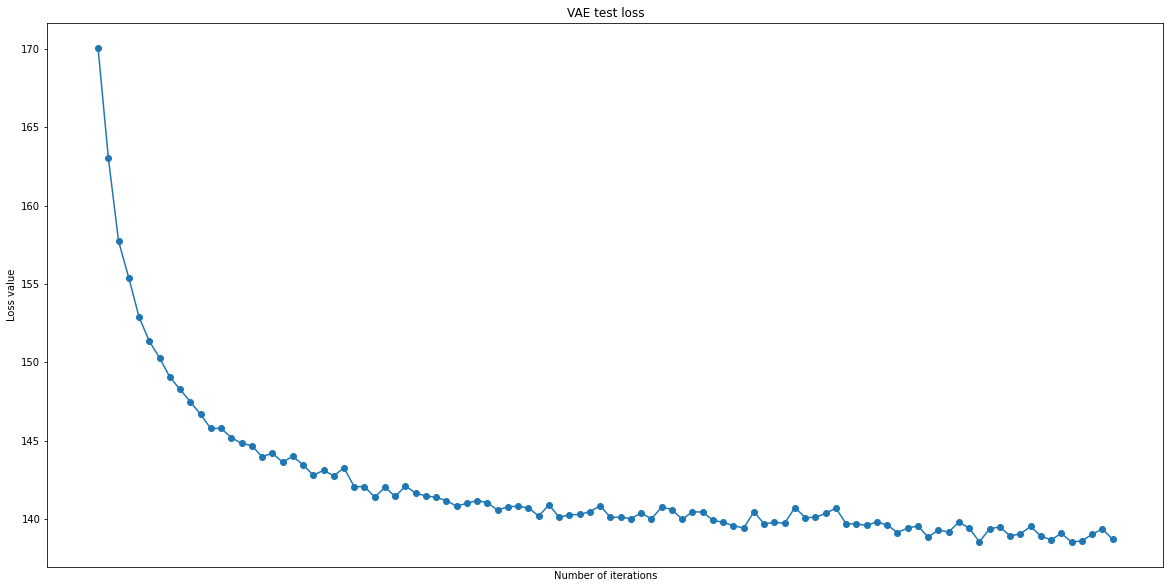

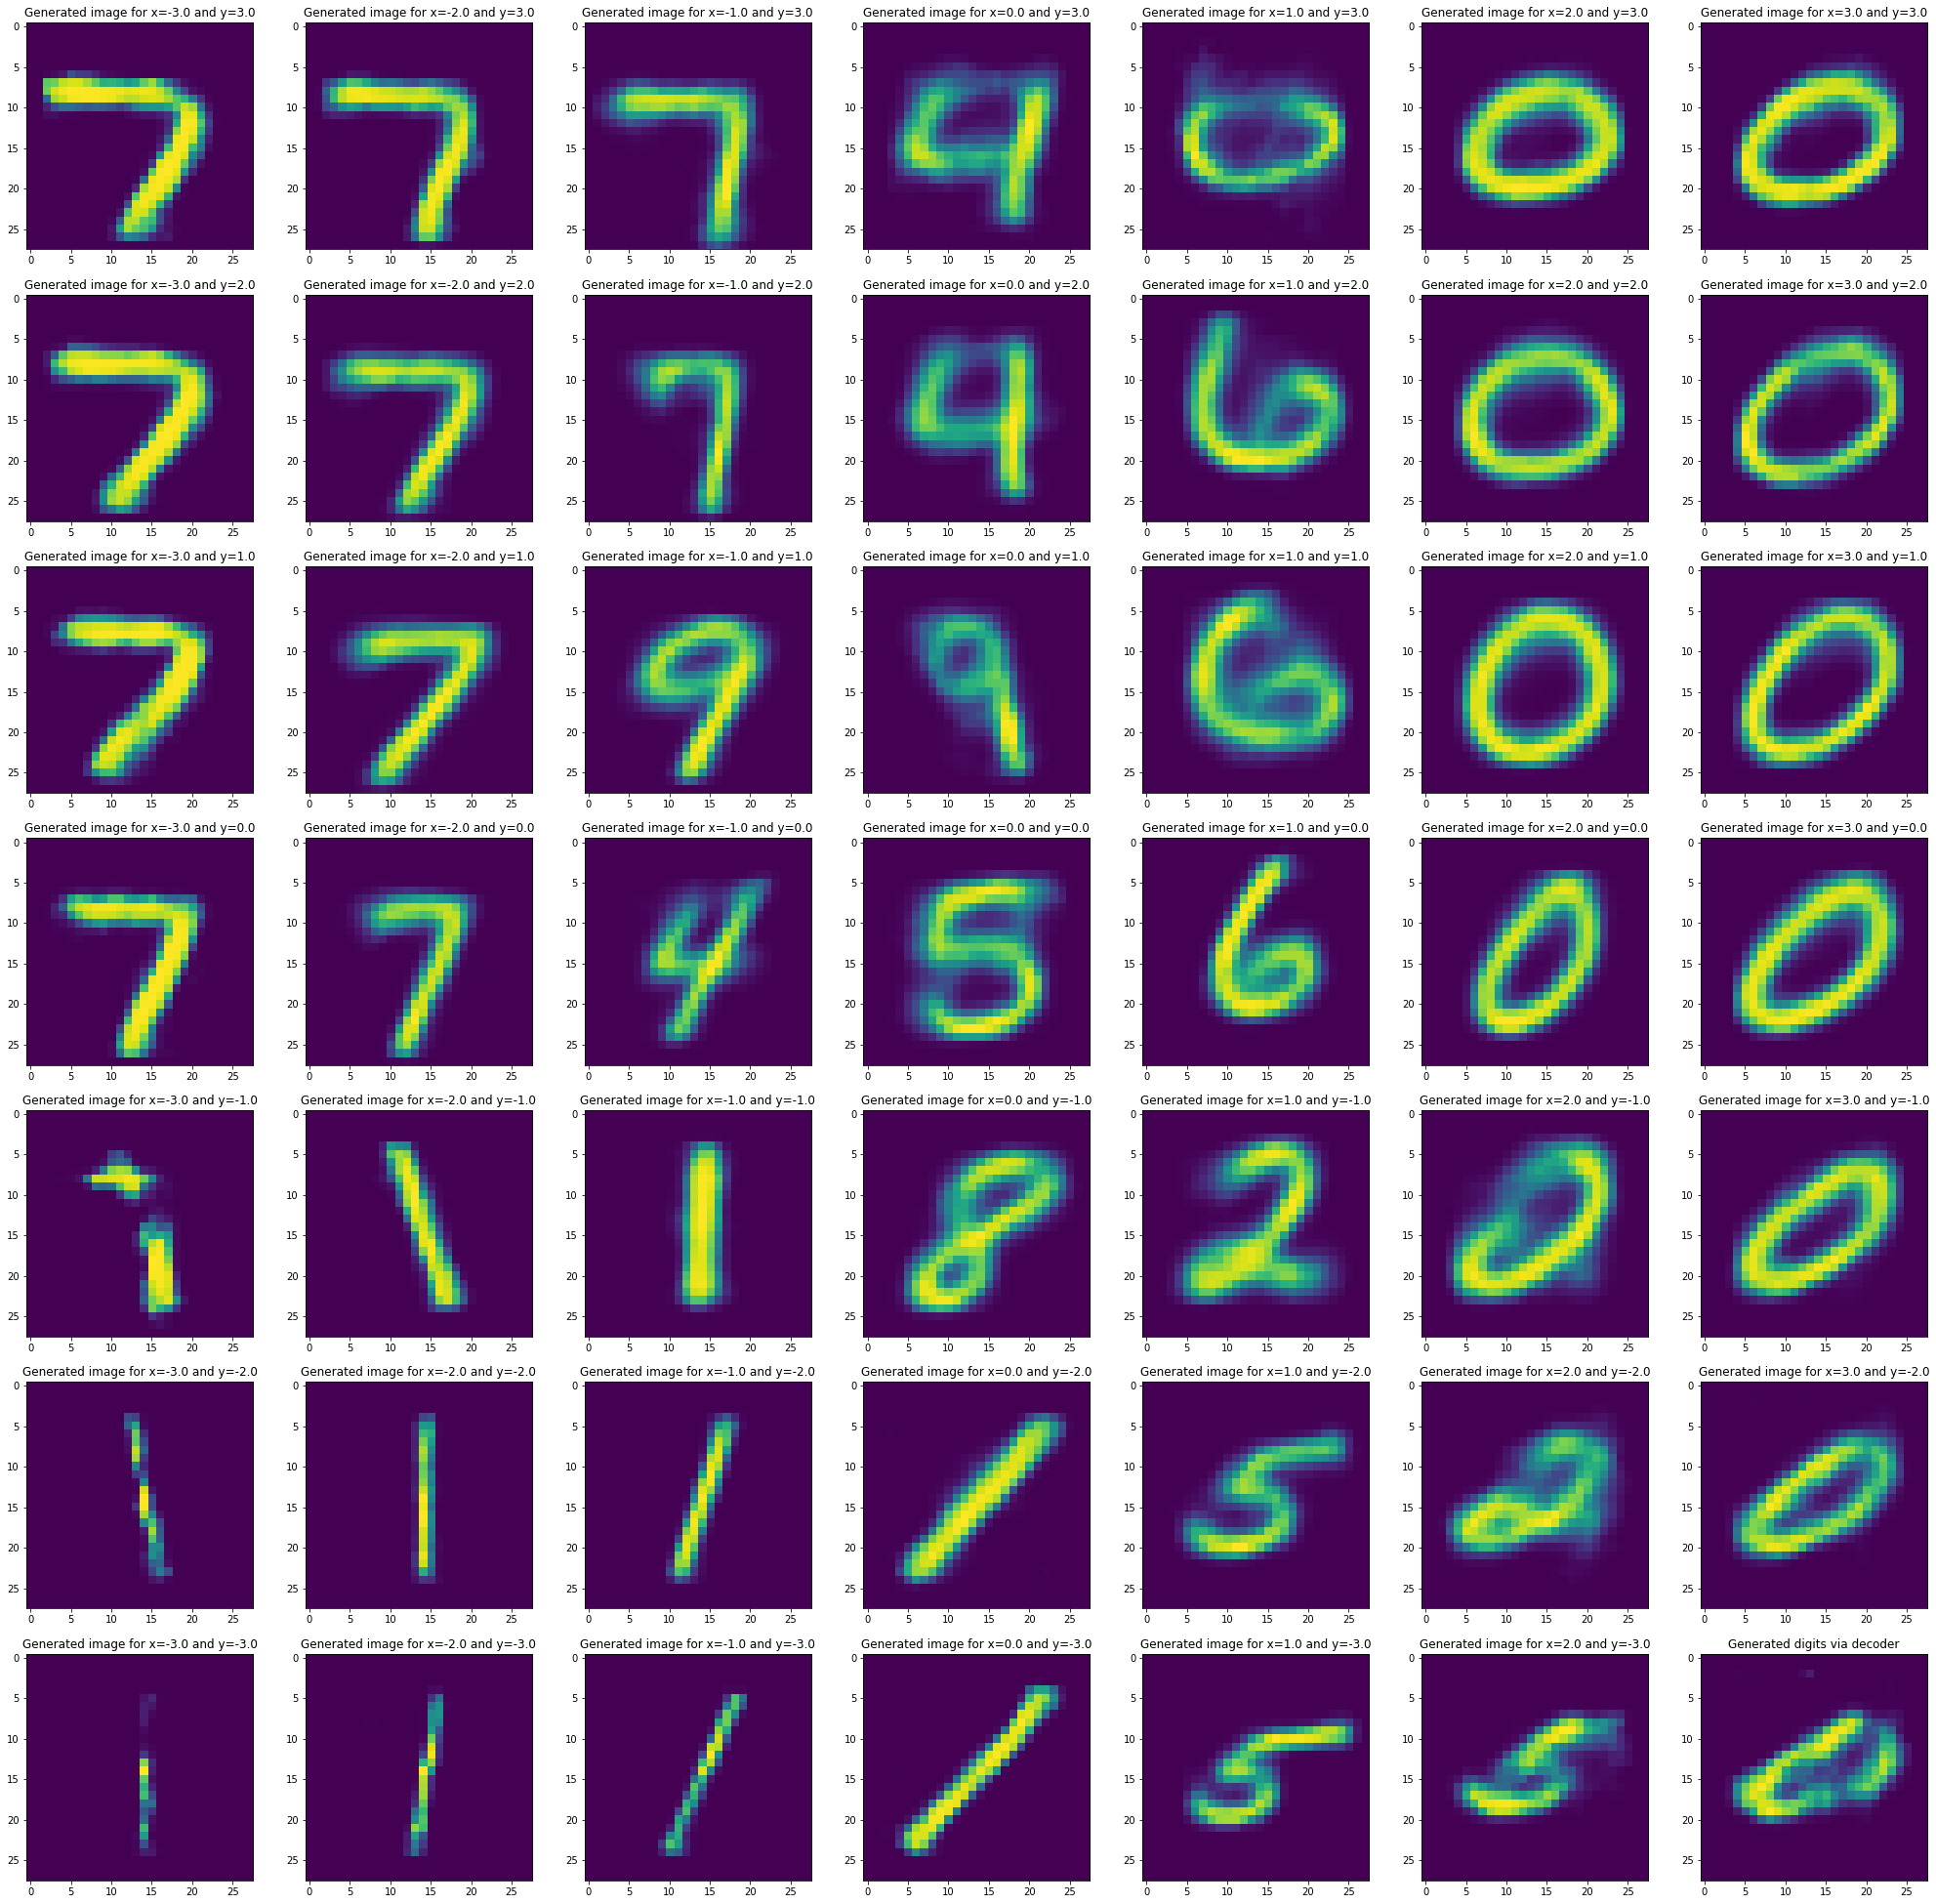

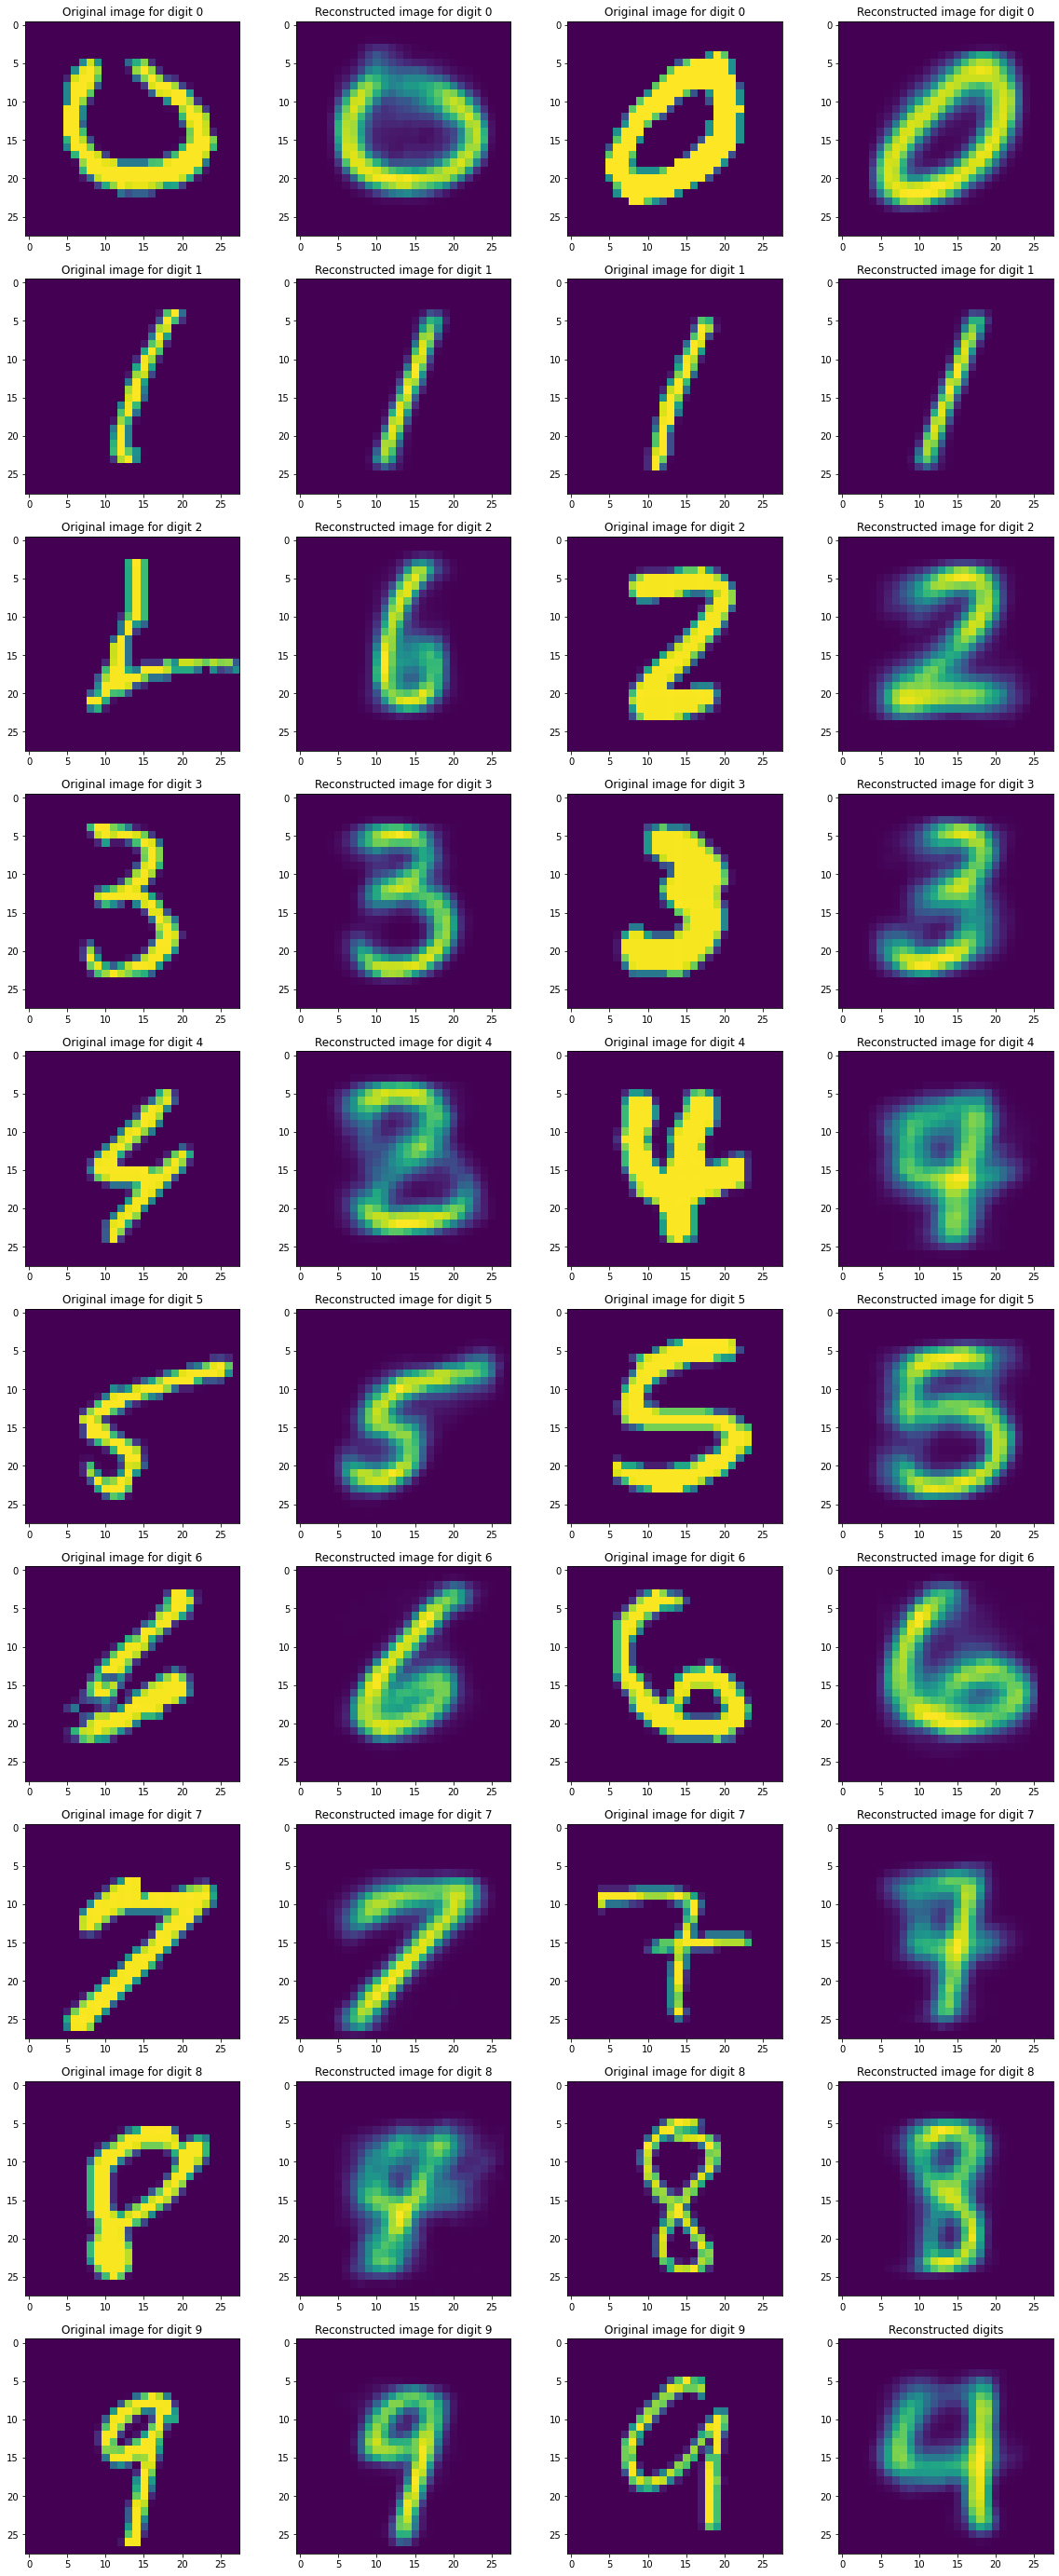

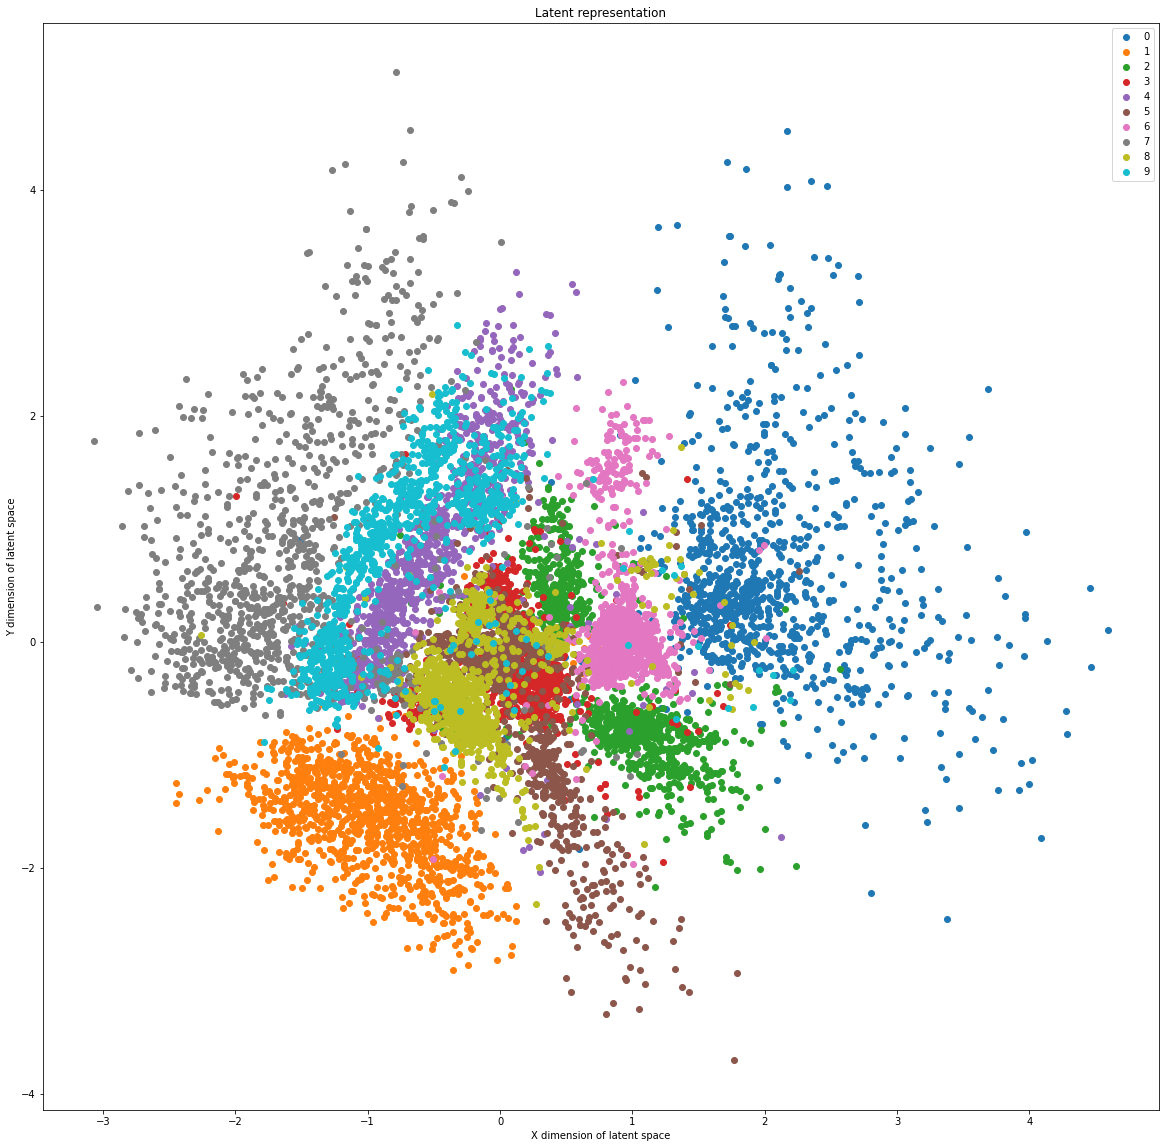

In [15]:
run(latent_dim=2, epochs=100)

469/469 [==============================] - 3s 5ms/step - loss: 175.6286 - val_loss: 137.8215


Validation Loss after 1 epochs: 137.82151794433594




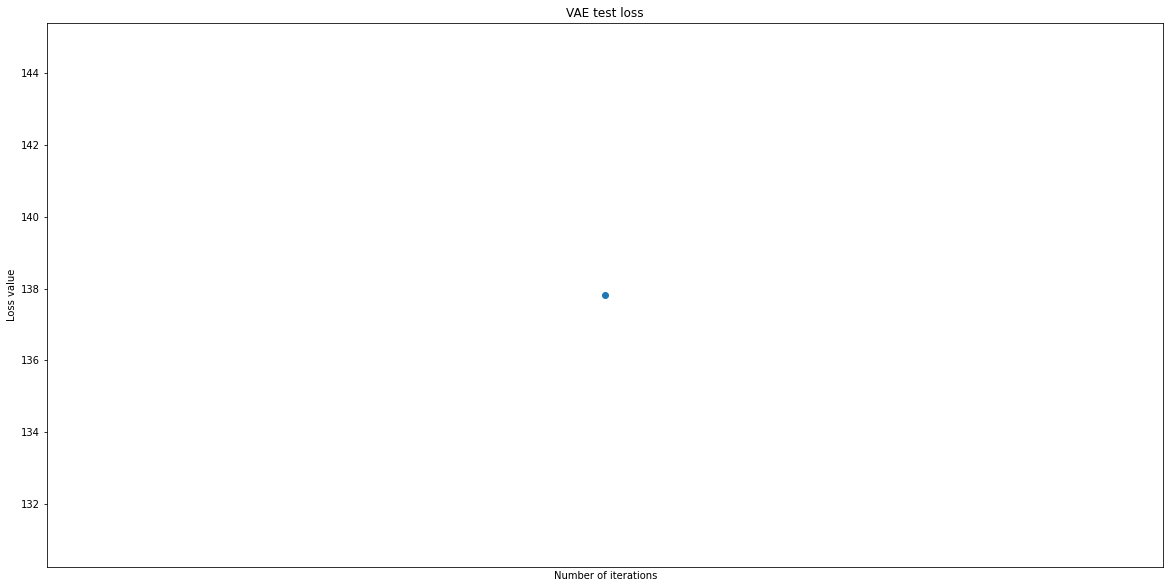

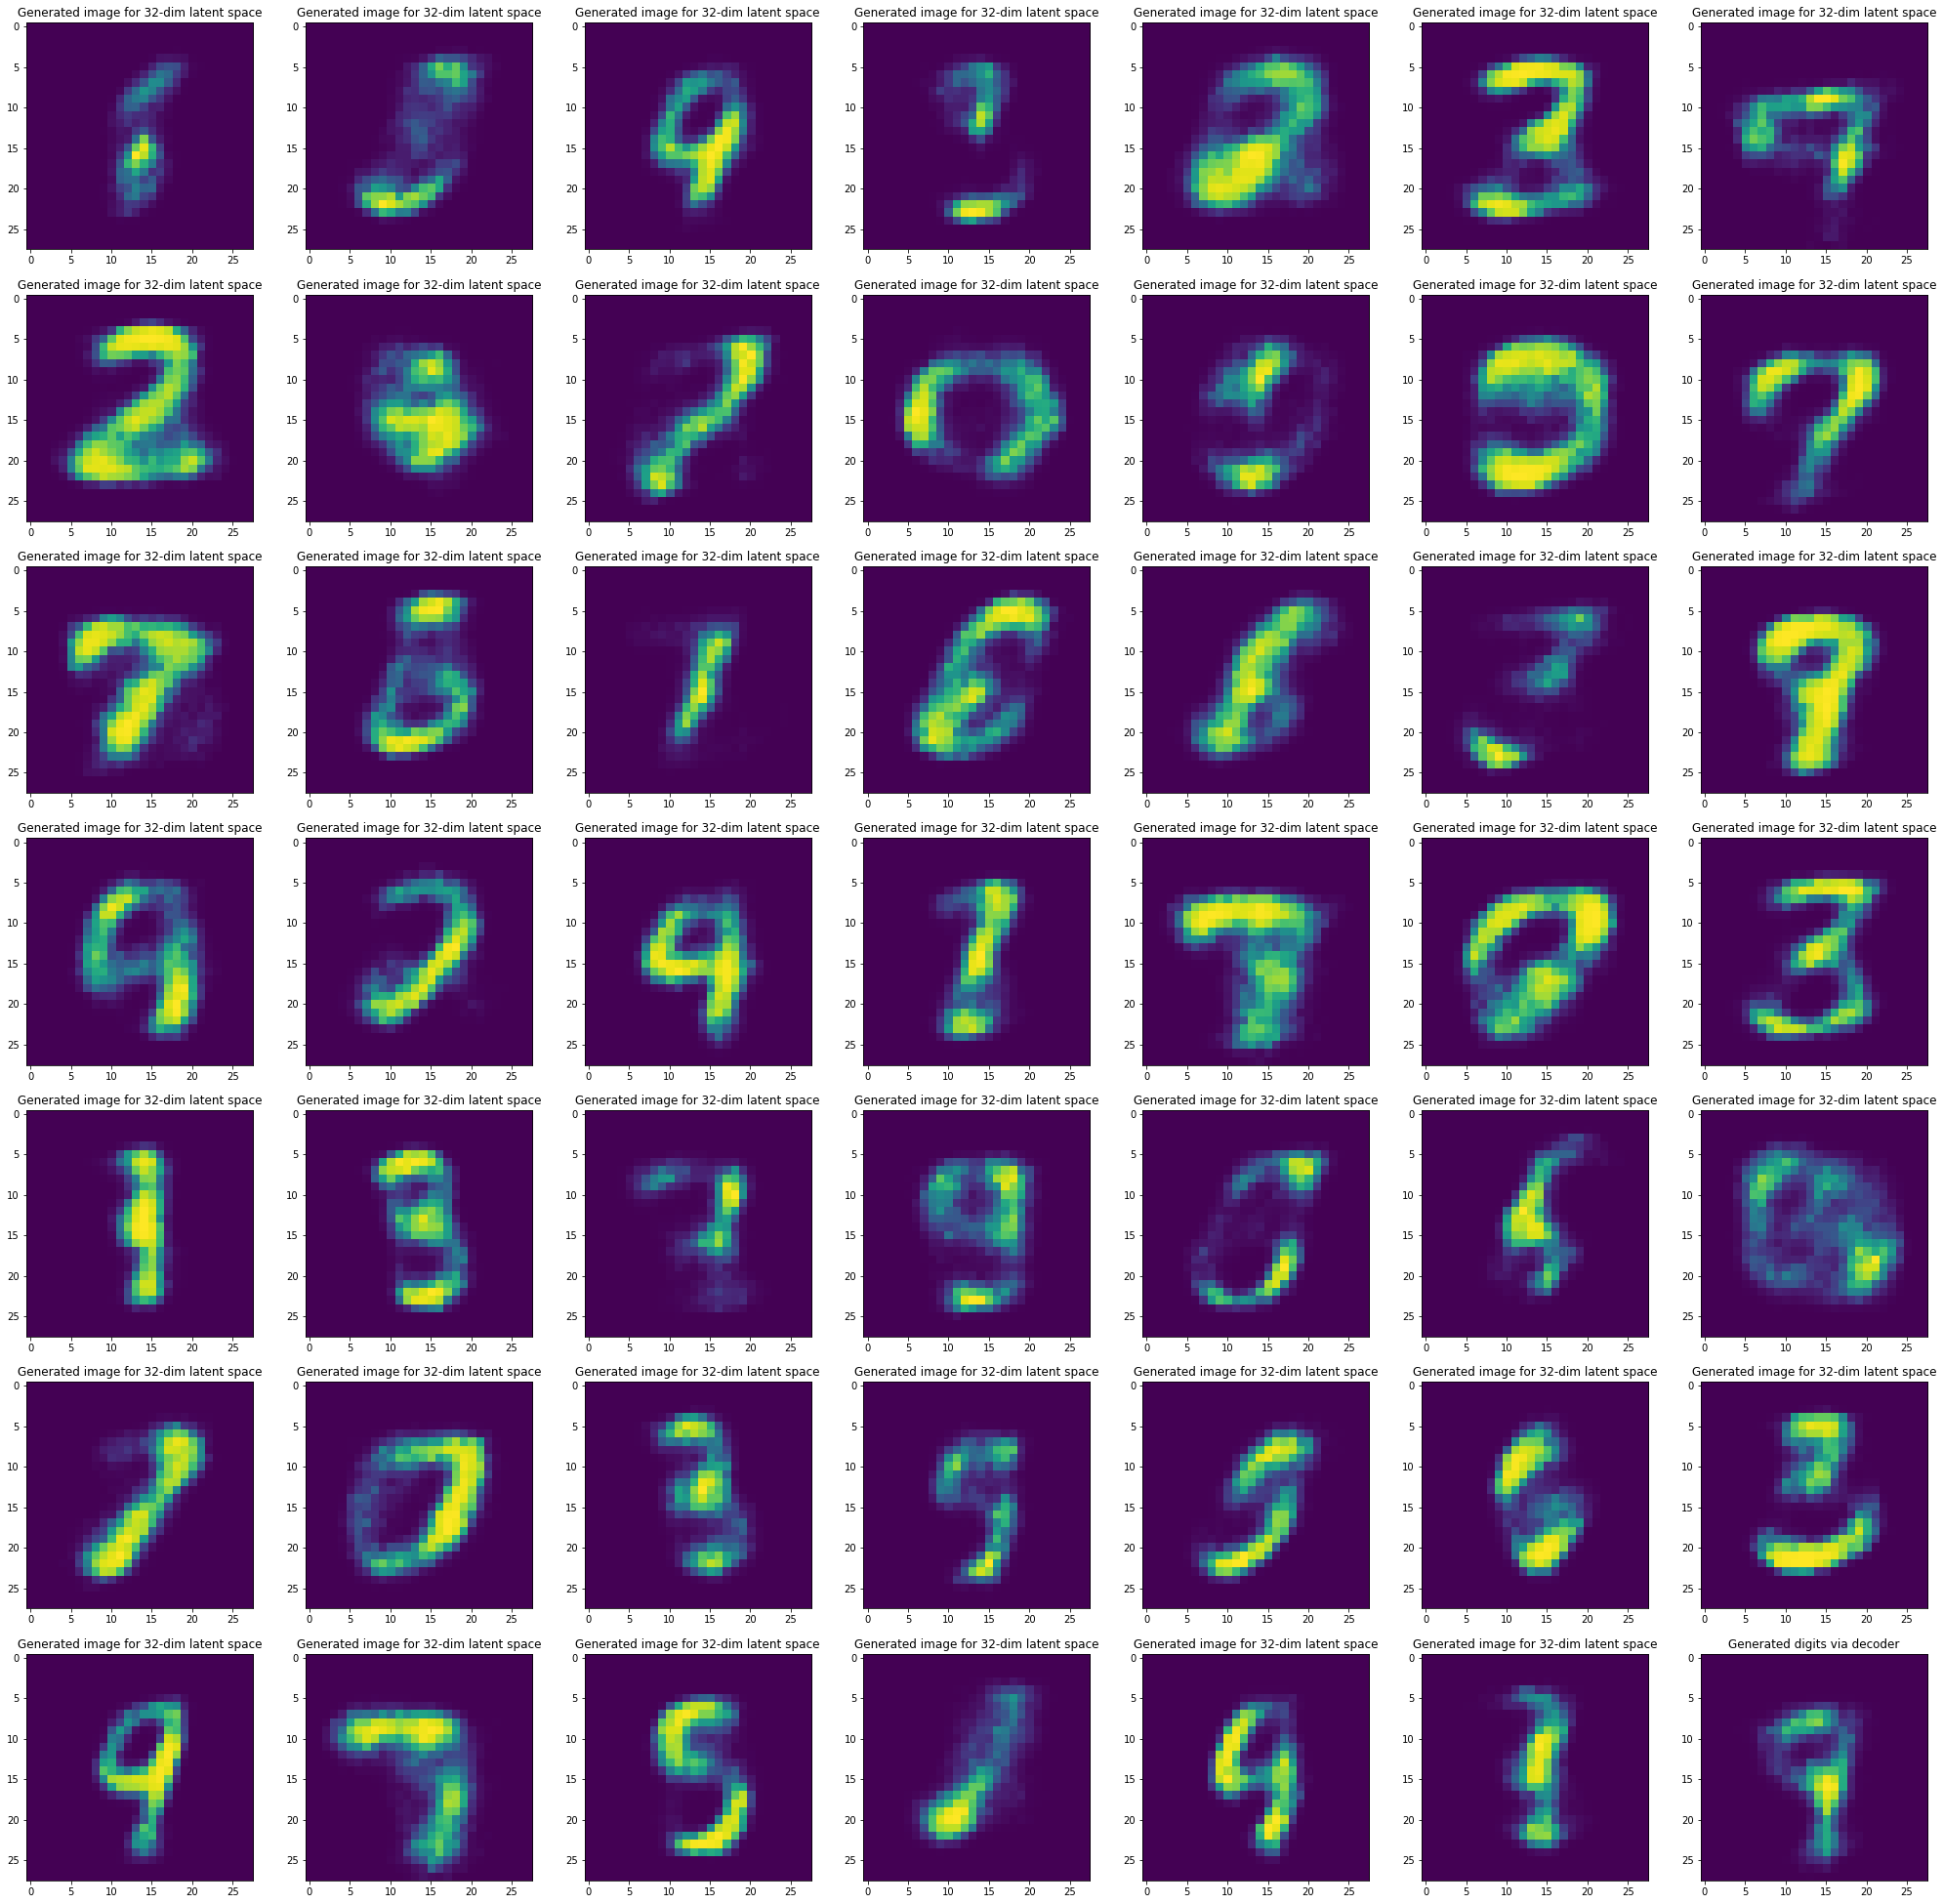

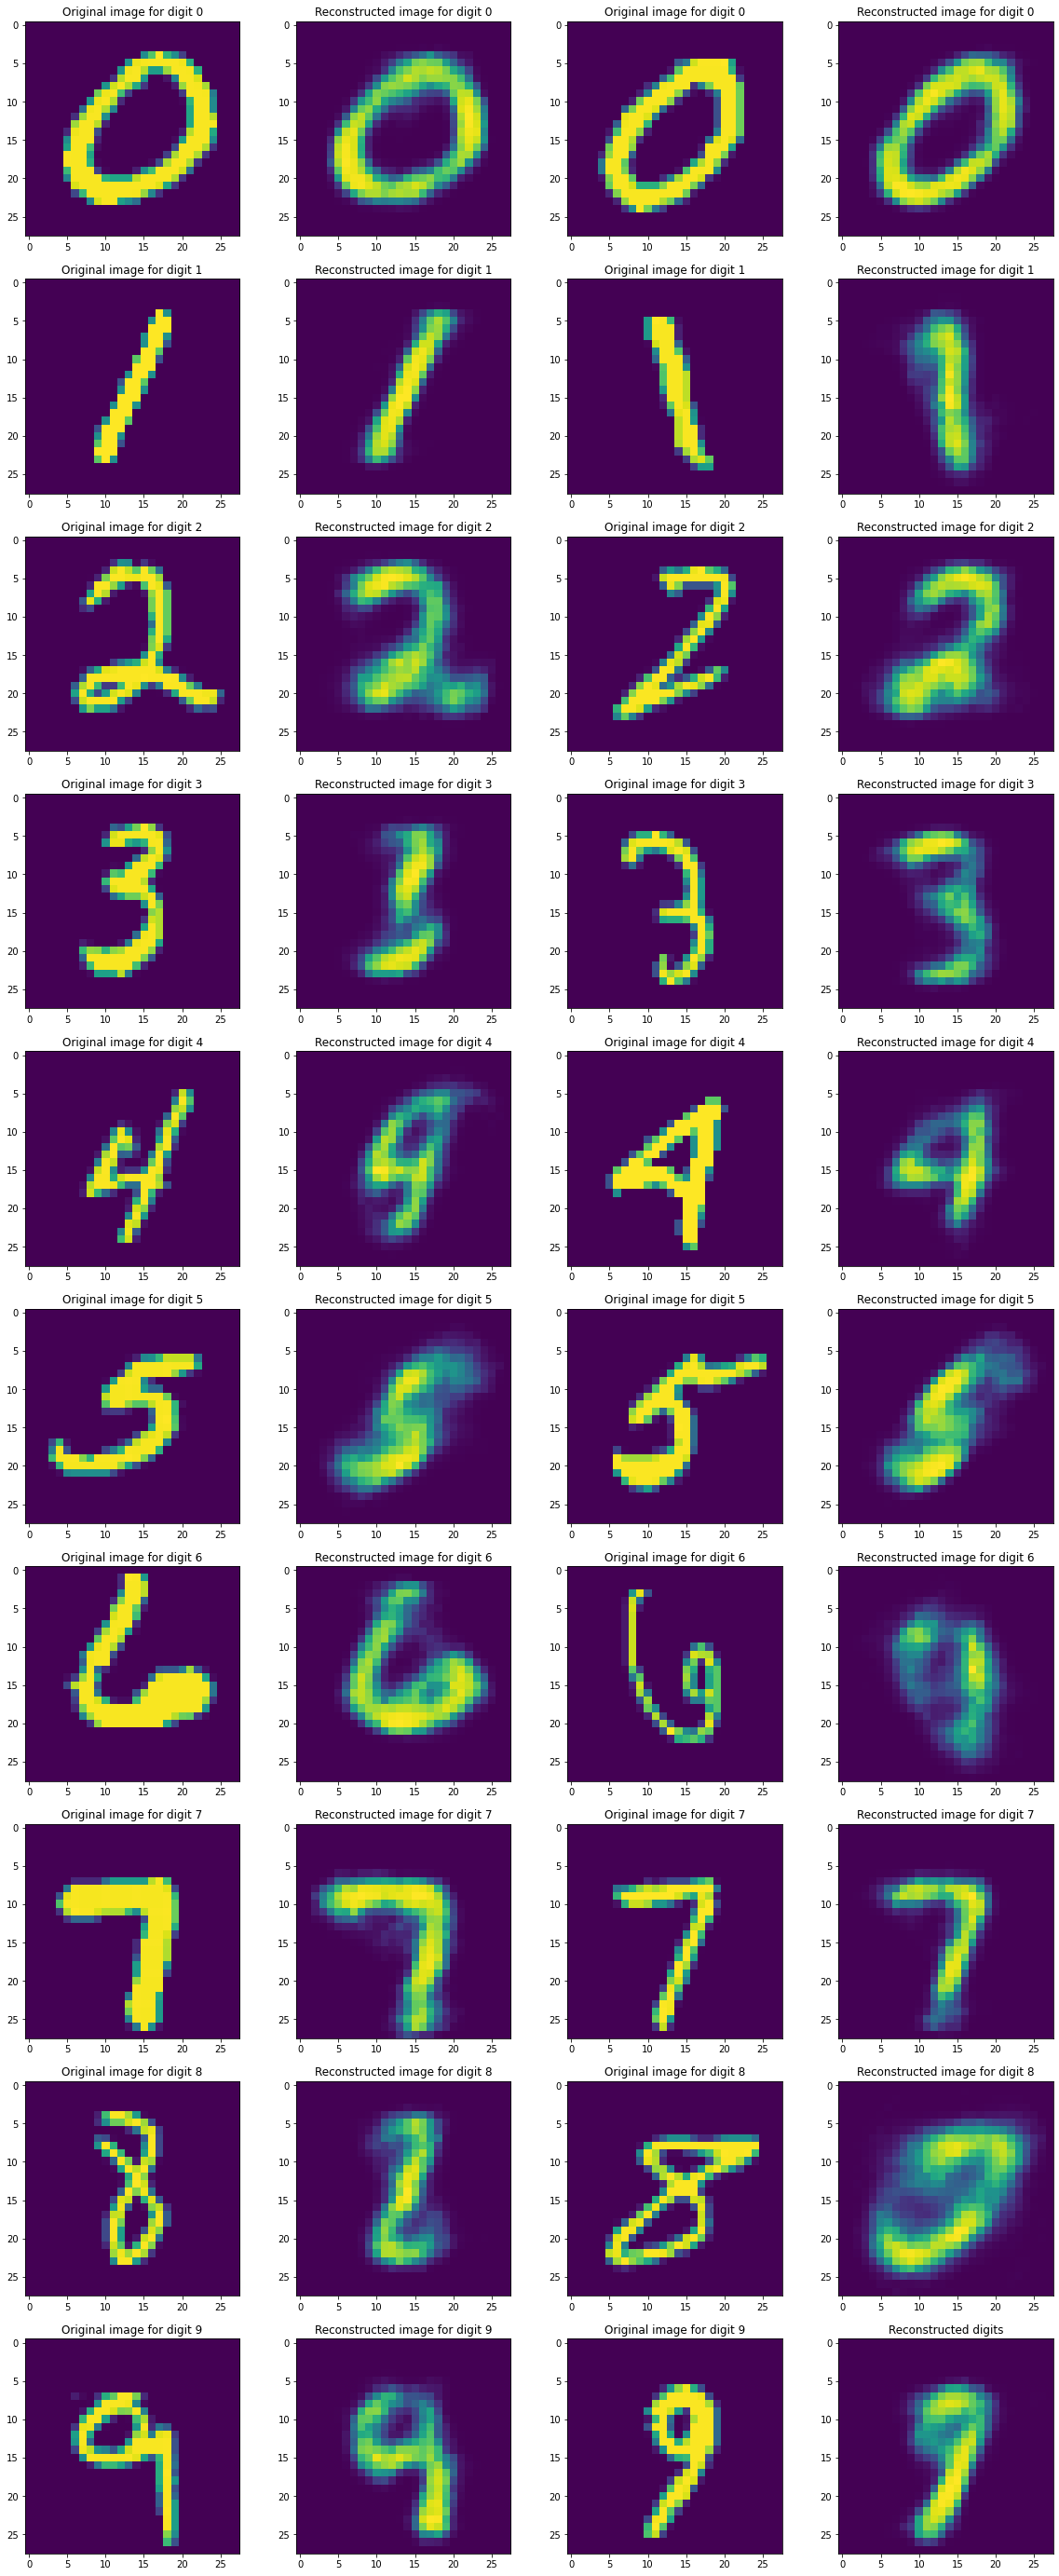

In [16]:
run(latent_dim=32, epochs=1)

Epoch 1/5
469/469 [==============================] - 3s 5ms/step - loss: 176.6820 - val_loss: 137.7298
Epoch 2/5
469/469 [==============================] - 2s 4ms/step - loss: 128.6288 - val_loss: 120.2140
Epoch 3/5
469/469 [==============================] - 2s 5ms/step - loss: 118.2738 - val_loss: 114.4684
Epoch 4/5
469/469 [==============================] - 2s 4ms/step - loss: 113.8816 - val_loss: 111.2884
Epoch 5/5
469/469 [==============================] - 2s 5ms/step - loss: 111.1935 - val_loss: 109.2296


Validation Loss after 5 epochs: 109.22957611083984




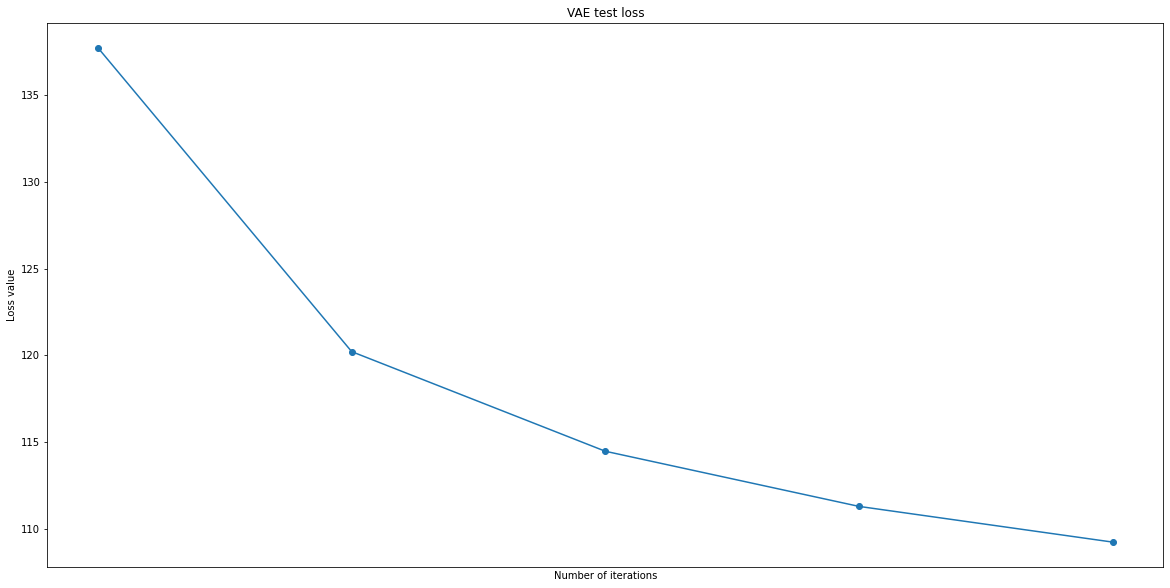

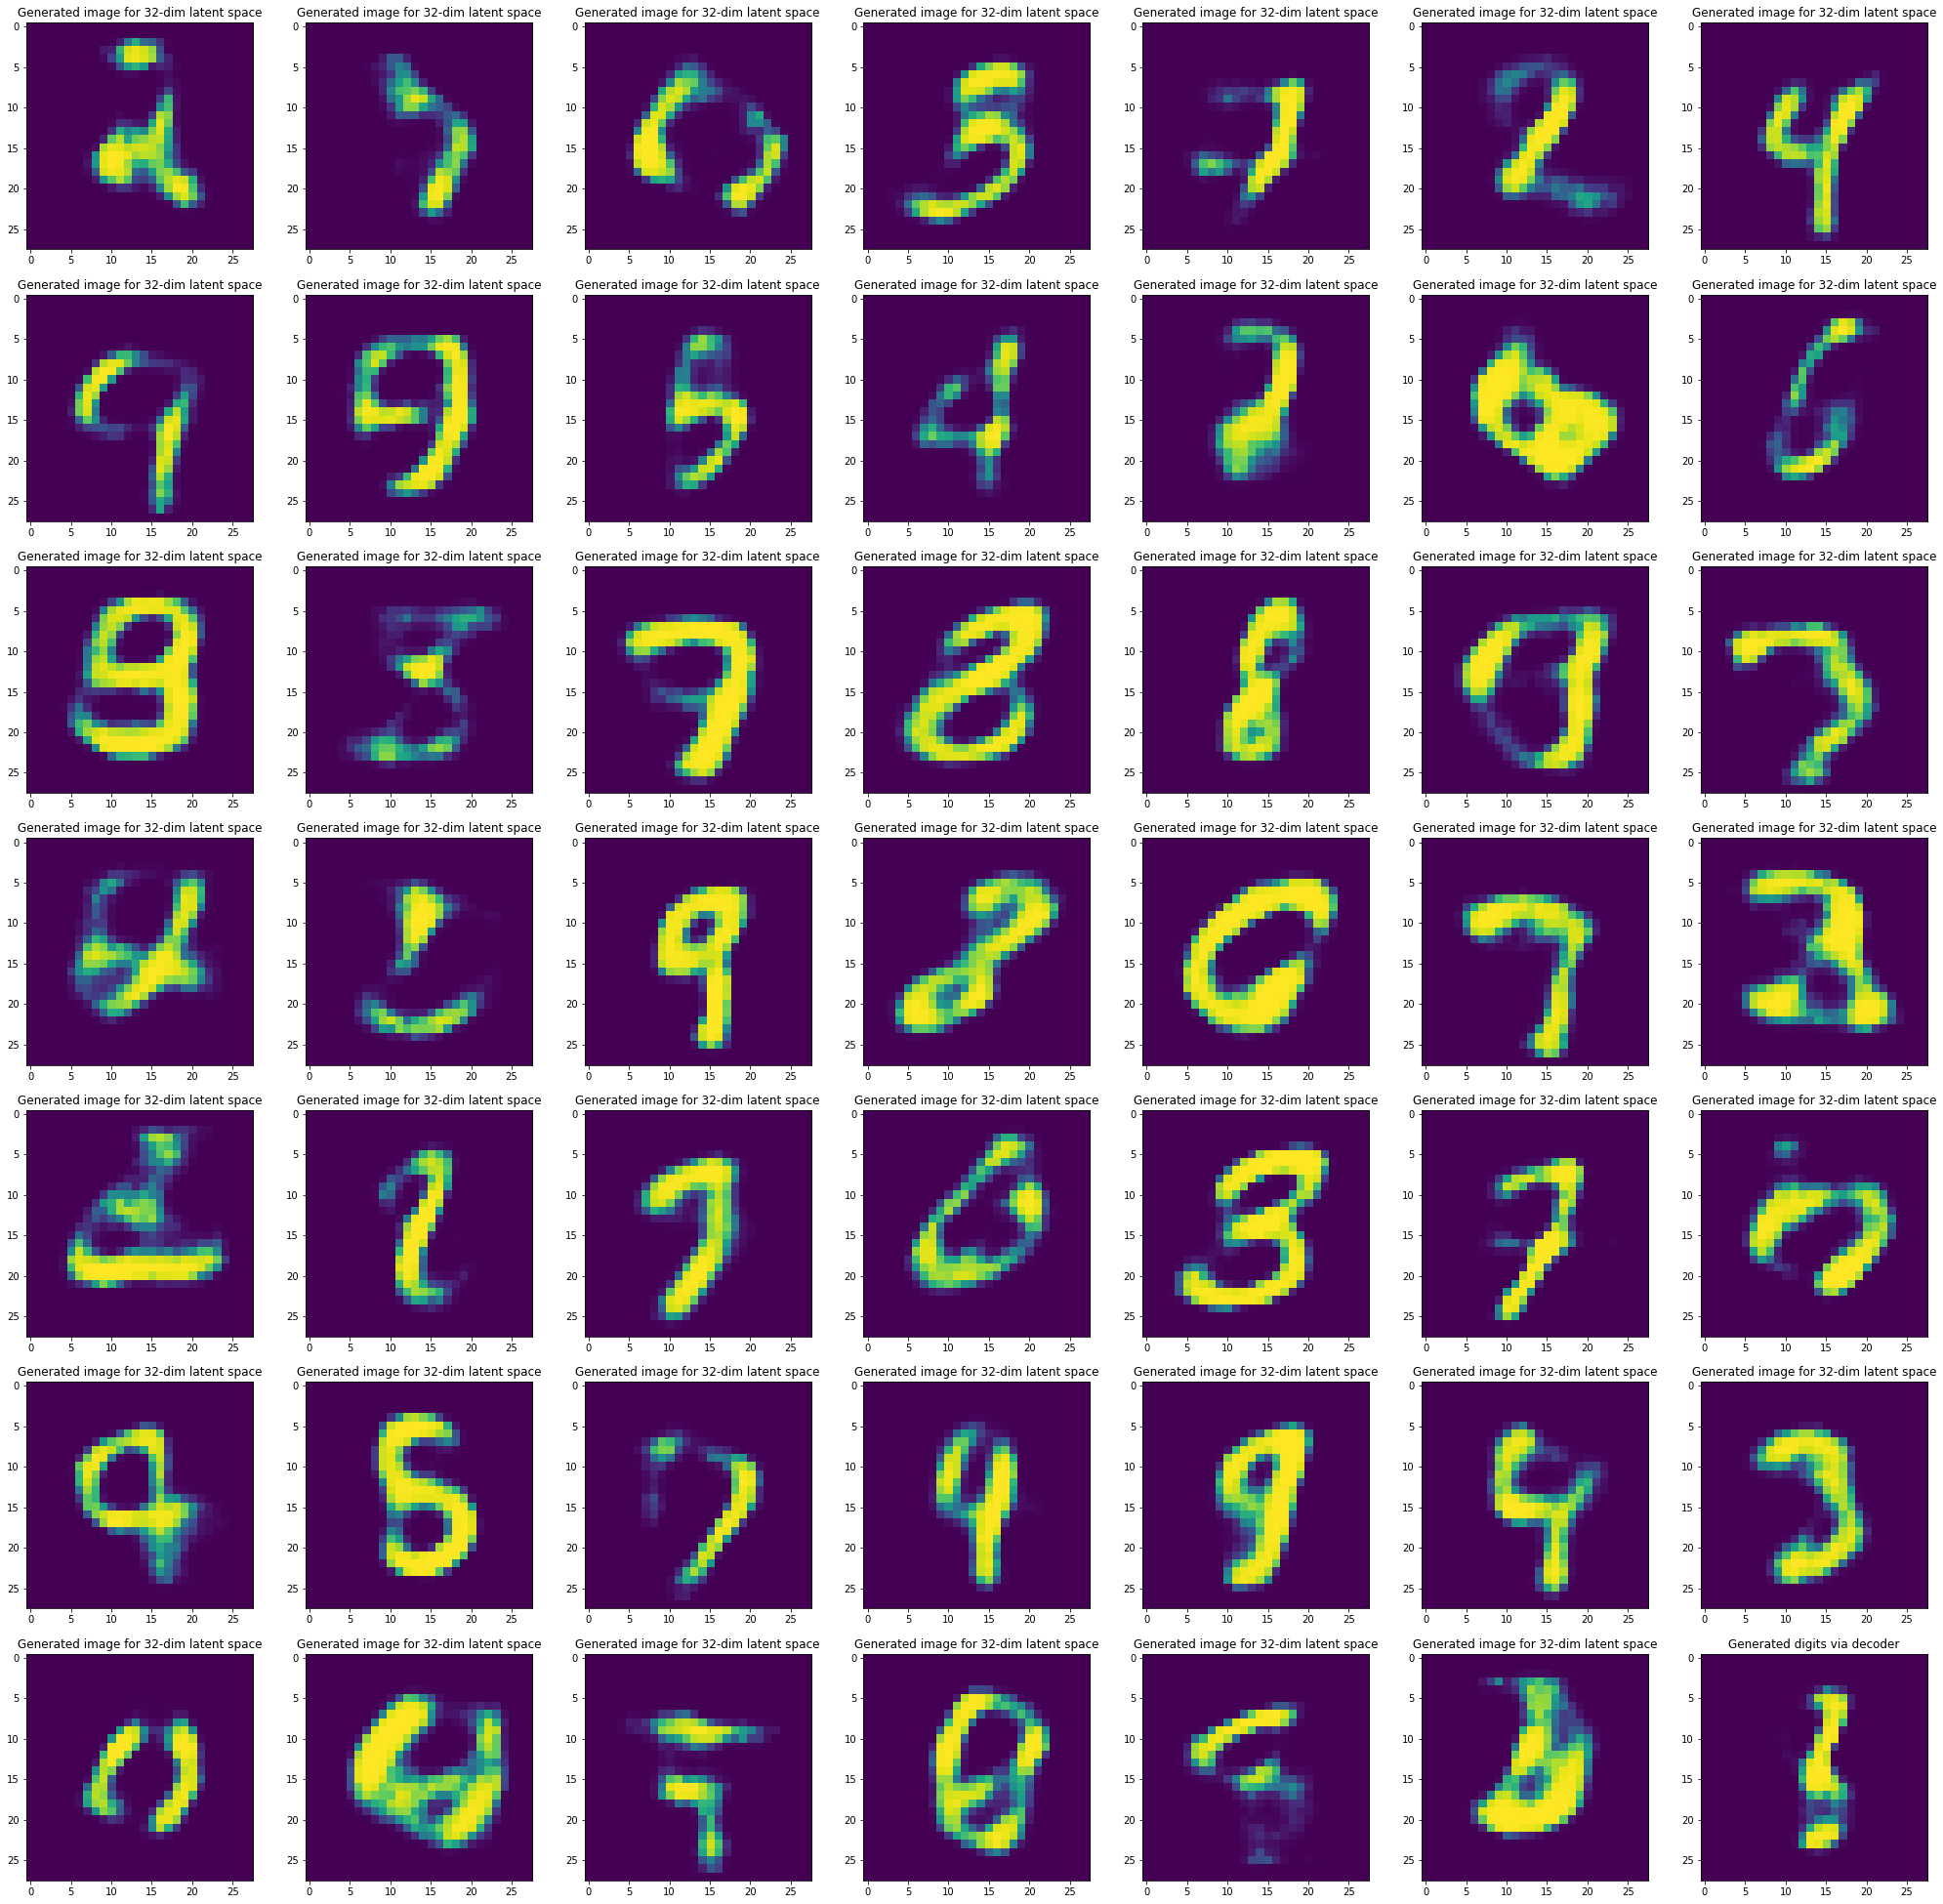

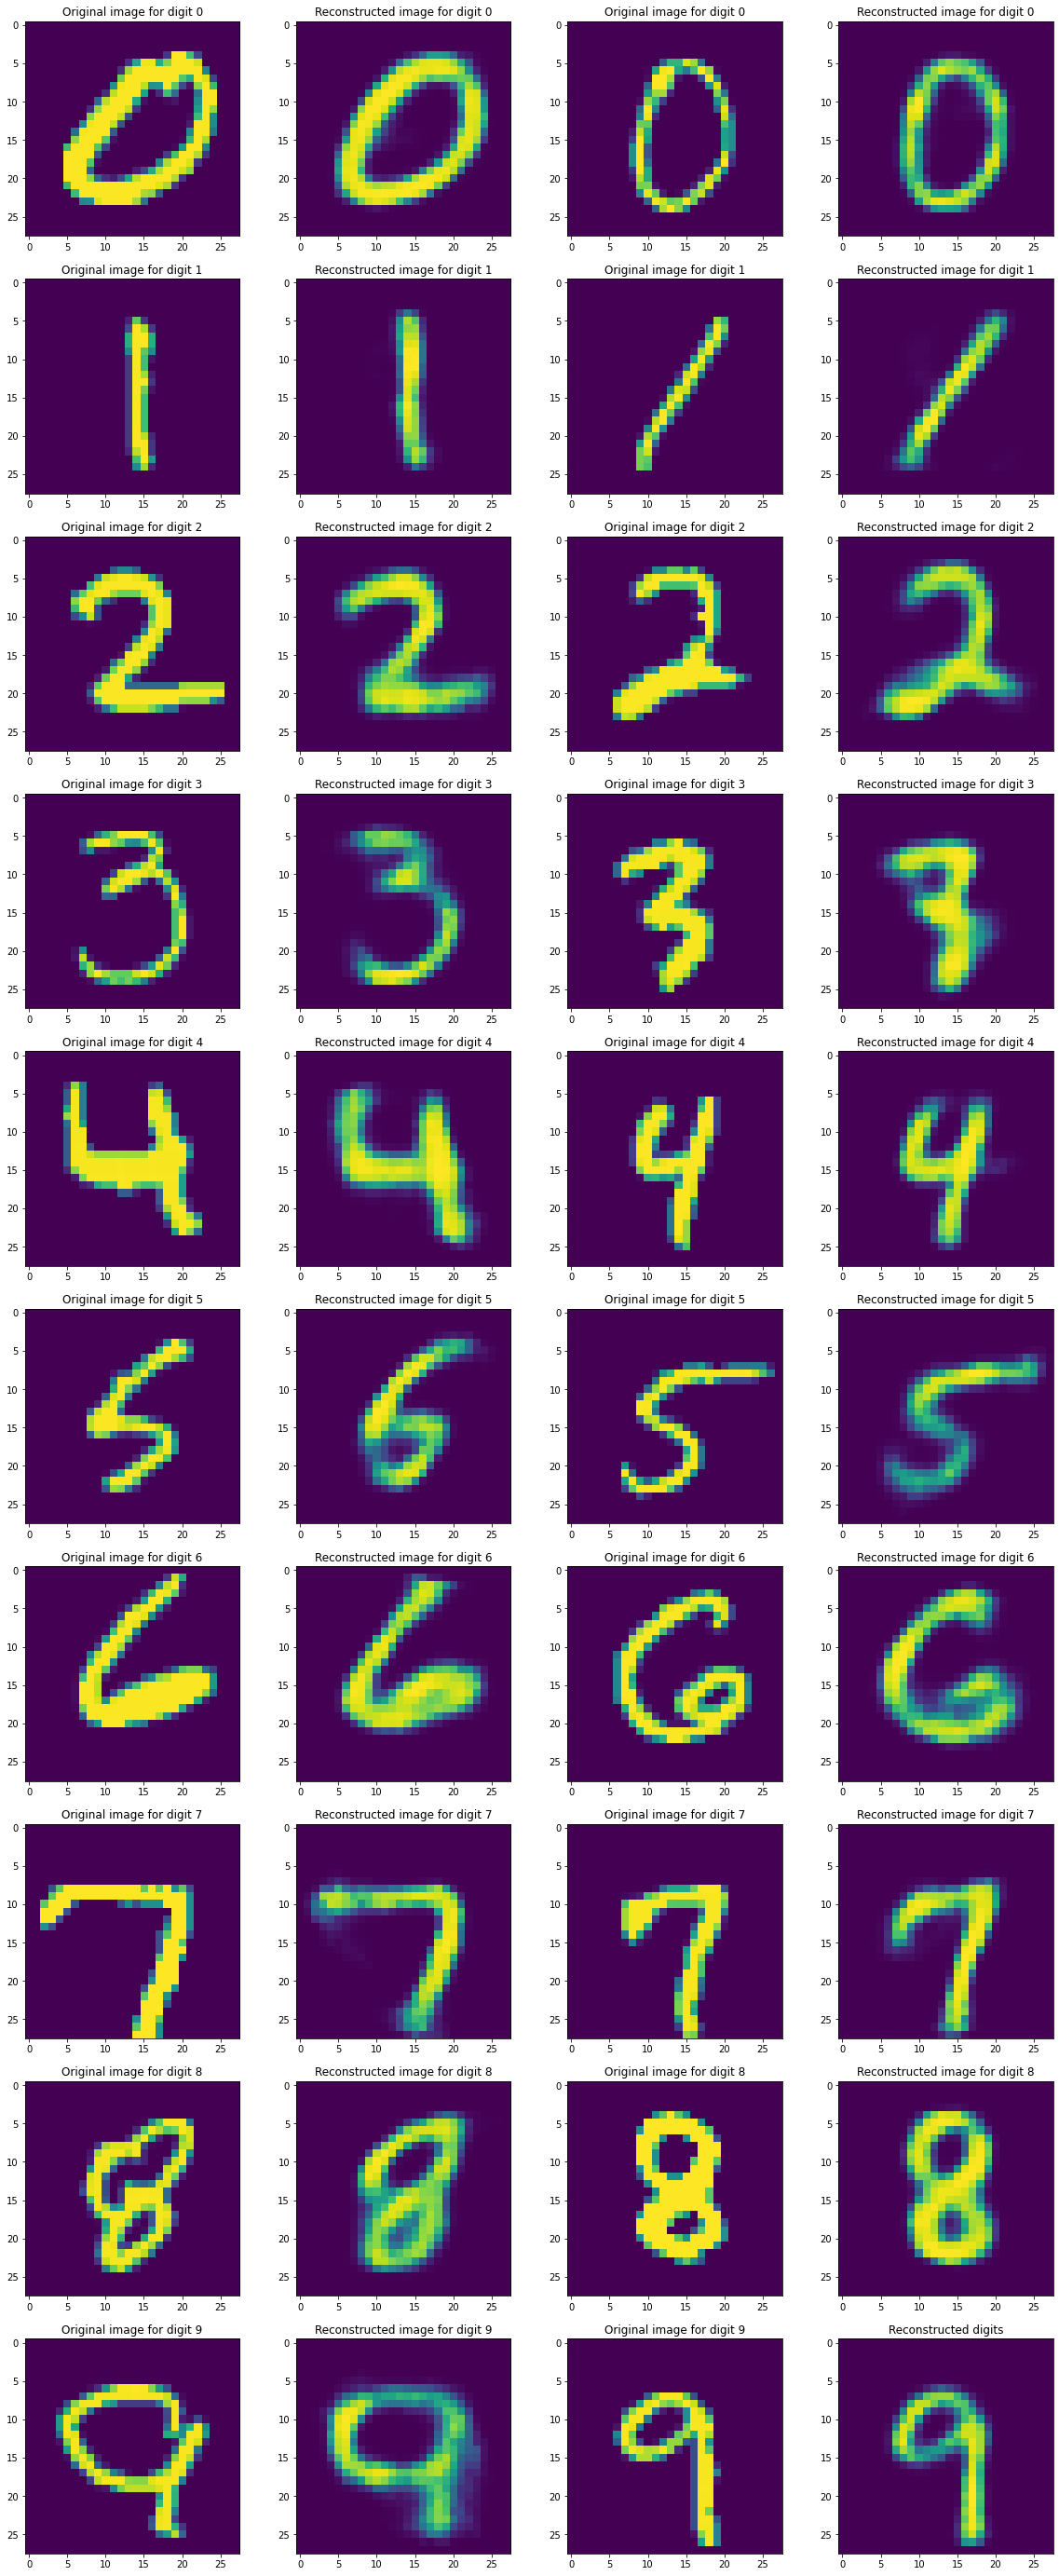

In [17]:
run(latent_dim=32, epochs=5)

Epoch 1/25
469/469 [==============================] - 3s 5ms/step - loss: 176.6711 - val_loss: 139.1091
Epoch 2/25
469/469 [==============================] - 2s 5ms/step - loss: 129.9117 - val_loss: 121.0241
Epoch 3/25
469/469 [==============================] - 2s 5ms/step - loss: 118.7078 - val_loss: 114.9063
Epoch 4/25
469/469 [==============================] - 2s 5ms/step - loss: 113.7887 - val_loss: 111.1646
Epoch 5/25
469/469 [==============================] - 2s 5ms/step - loss: 111.0883 - val_loss: 109.3932
Epoch 6/25
469/469 [==============================] - 2s 5ms/step - loss: 109.2624 - val_loss: 107.6102
Epoch 7/25
469/469 [==============================] - 2s 5ms/step - loss: 107.9093 - val_loss: 106.8233
Epoch 8/25
469/469 [==============================] - 2s 5ms/step - loss: 106.9708 - val_loss: 105.7887
Epoch 9/25
469/469 [==============================] - 2s 5ms/step - loss: 106.1011 - val_loss: 105.1628
Epoch 10/25
469/469 [==============================] - 2s 4ms/st

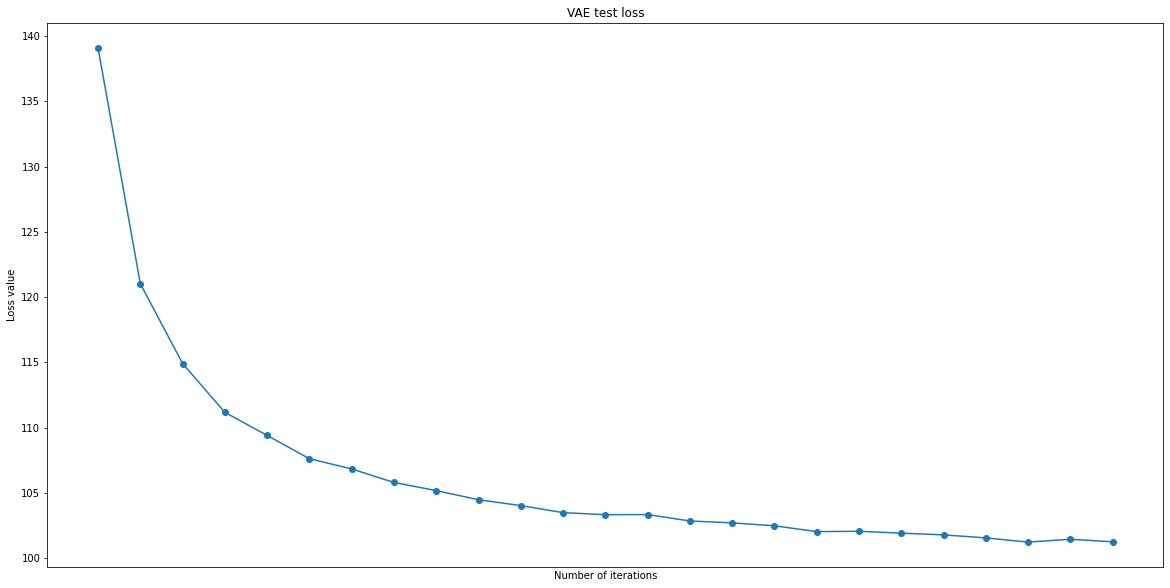

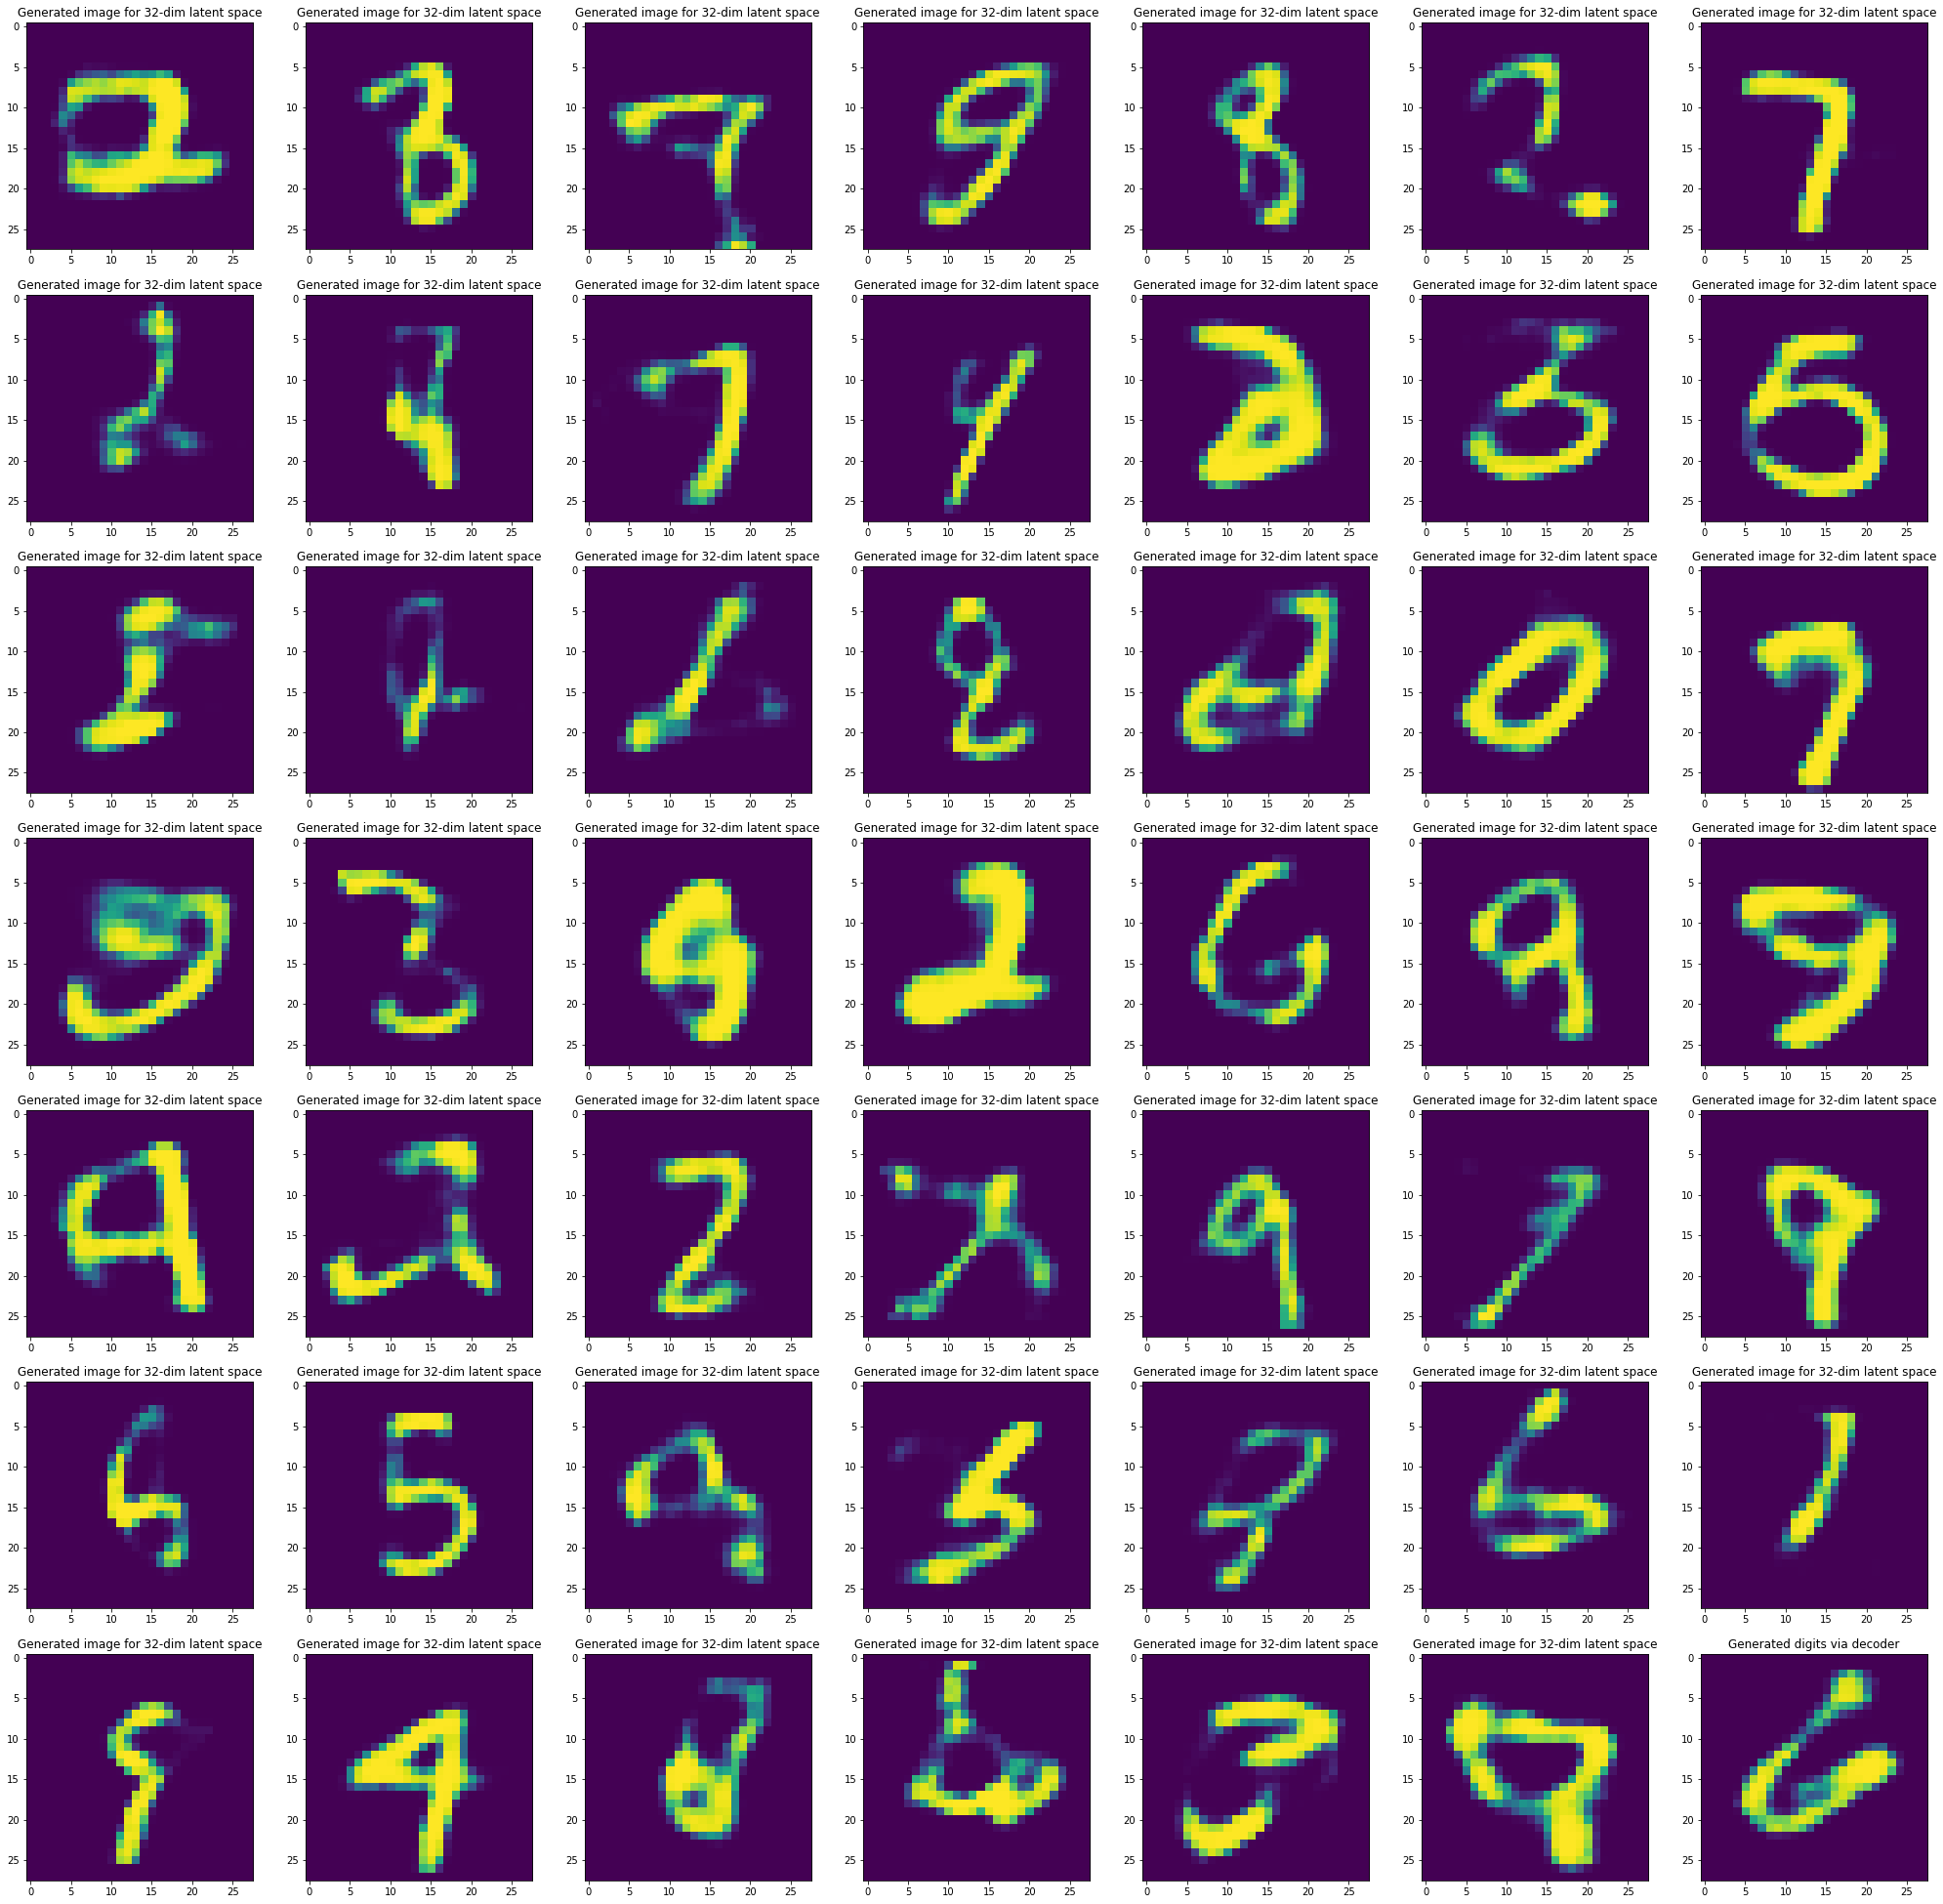

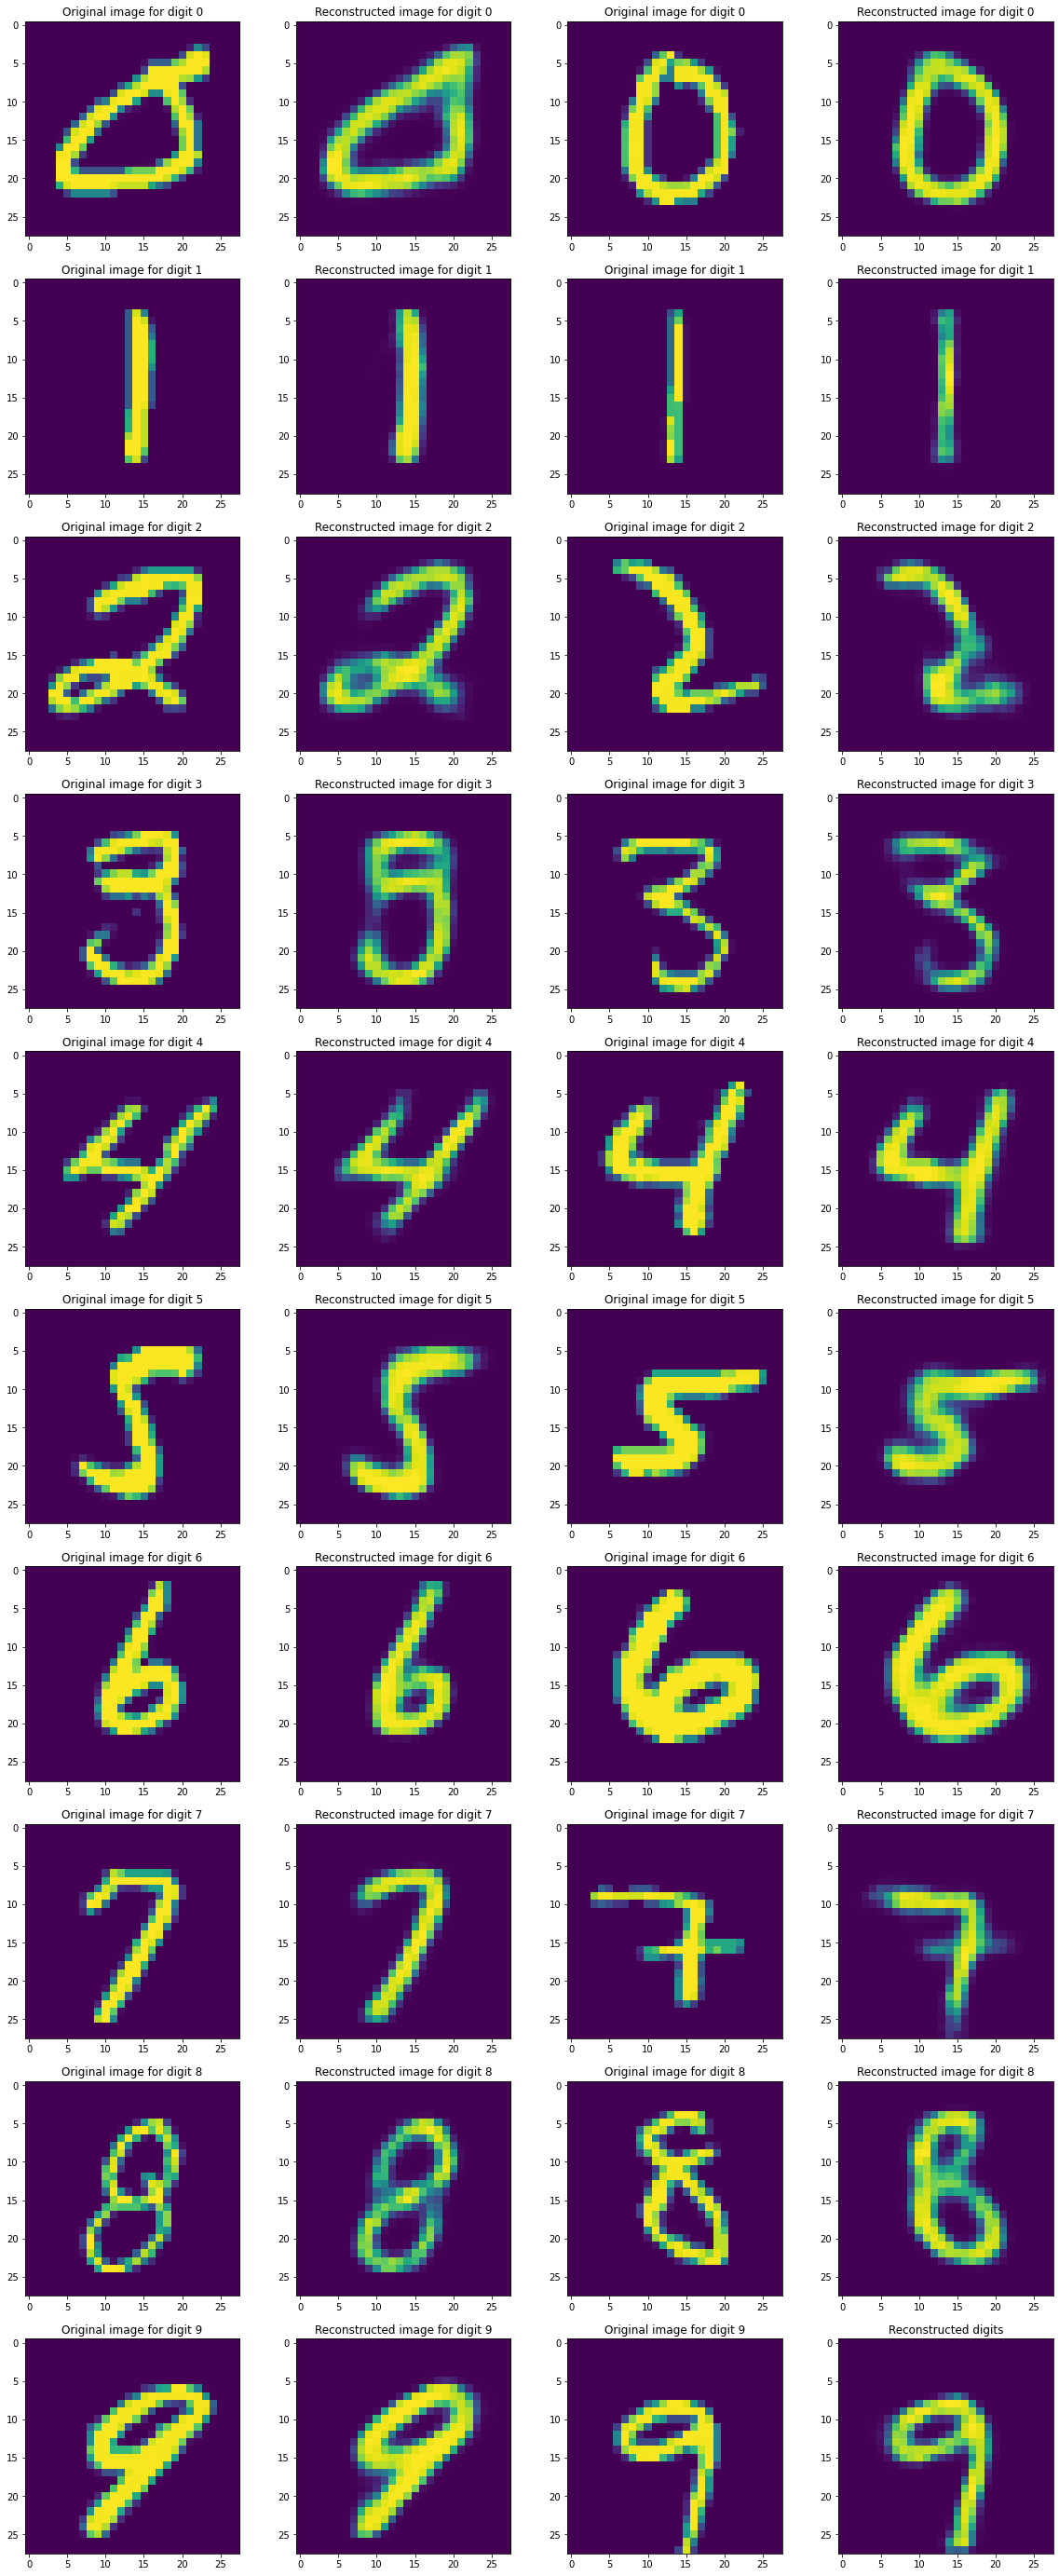

In [18]:
run(latent_dim=32, epochs=25)

Epoch 1/50
469/469 [==============================] - 3s 5ms/step - loss: 174.3618 - val_loss: 136.4004
Epoch 2/50
469/469 [==============================] - 2s 5ms/step - loss: 128.5152 - val_loss: 120.6870
Epoch 3/50
469/469 [==============================] - 2s 5ms/step - loss: 118.3003 - val_loss: 113.9118
Epoch 4/50
469/469 [==============================] - 2s 5ms/step - loss: 113.6083 - val_loss: 111.3106
Epoch 5/50
469/469 [==============================] - 2s 5ms/step - loss: 110.9944 - val_loss: 109.1264
Epoch 6/50
469/469 [==============================] - 2s 5ms/step - loss: 109.3178 - val_loss: 107.9282
Epoch 7/50
469/469 [==============================] - 2s 5ms/step - loss: 108.0617 - val_loss: 106.8402
Epoch 8/50
469/469 [==============================] - 2s 5ms/step - loss: 106.9714 - val_loss: 105.9333
Epoch 9/50
469/469 [==============================] - 2s 5ms/step - loss: 106.1202 - val_loss: 105.2067
Epoch 10/50
469/469 [==============================] - 2s 5ms/st

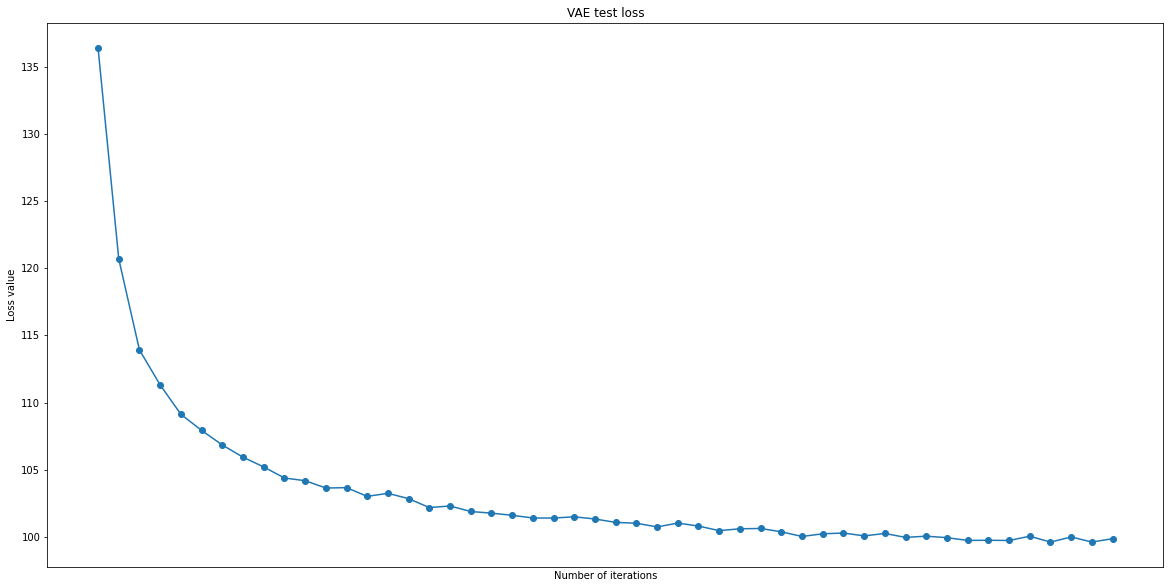

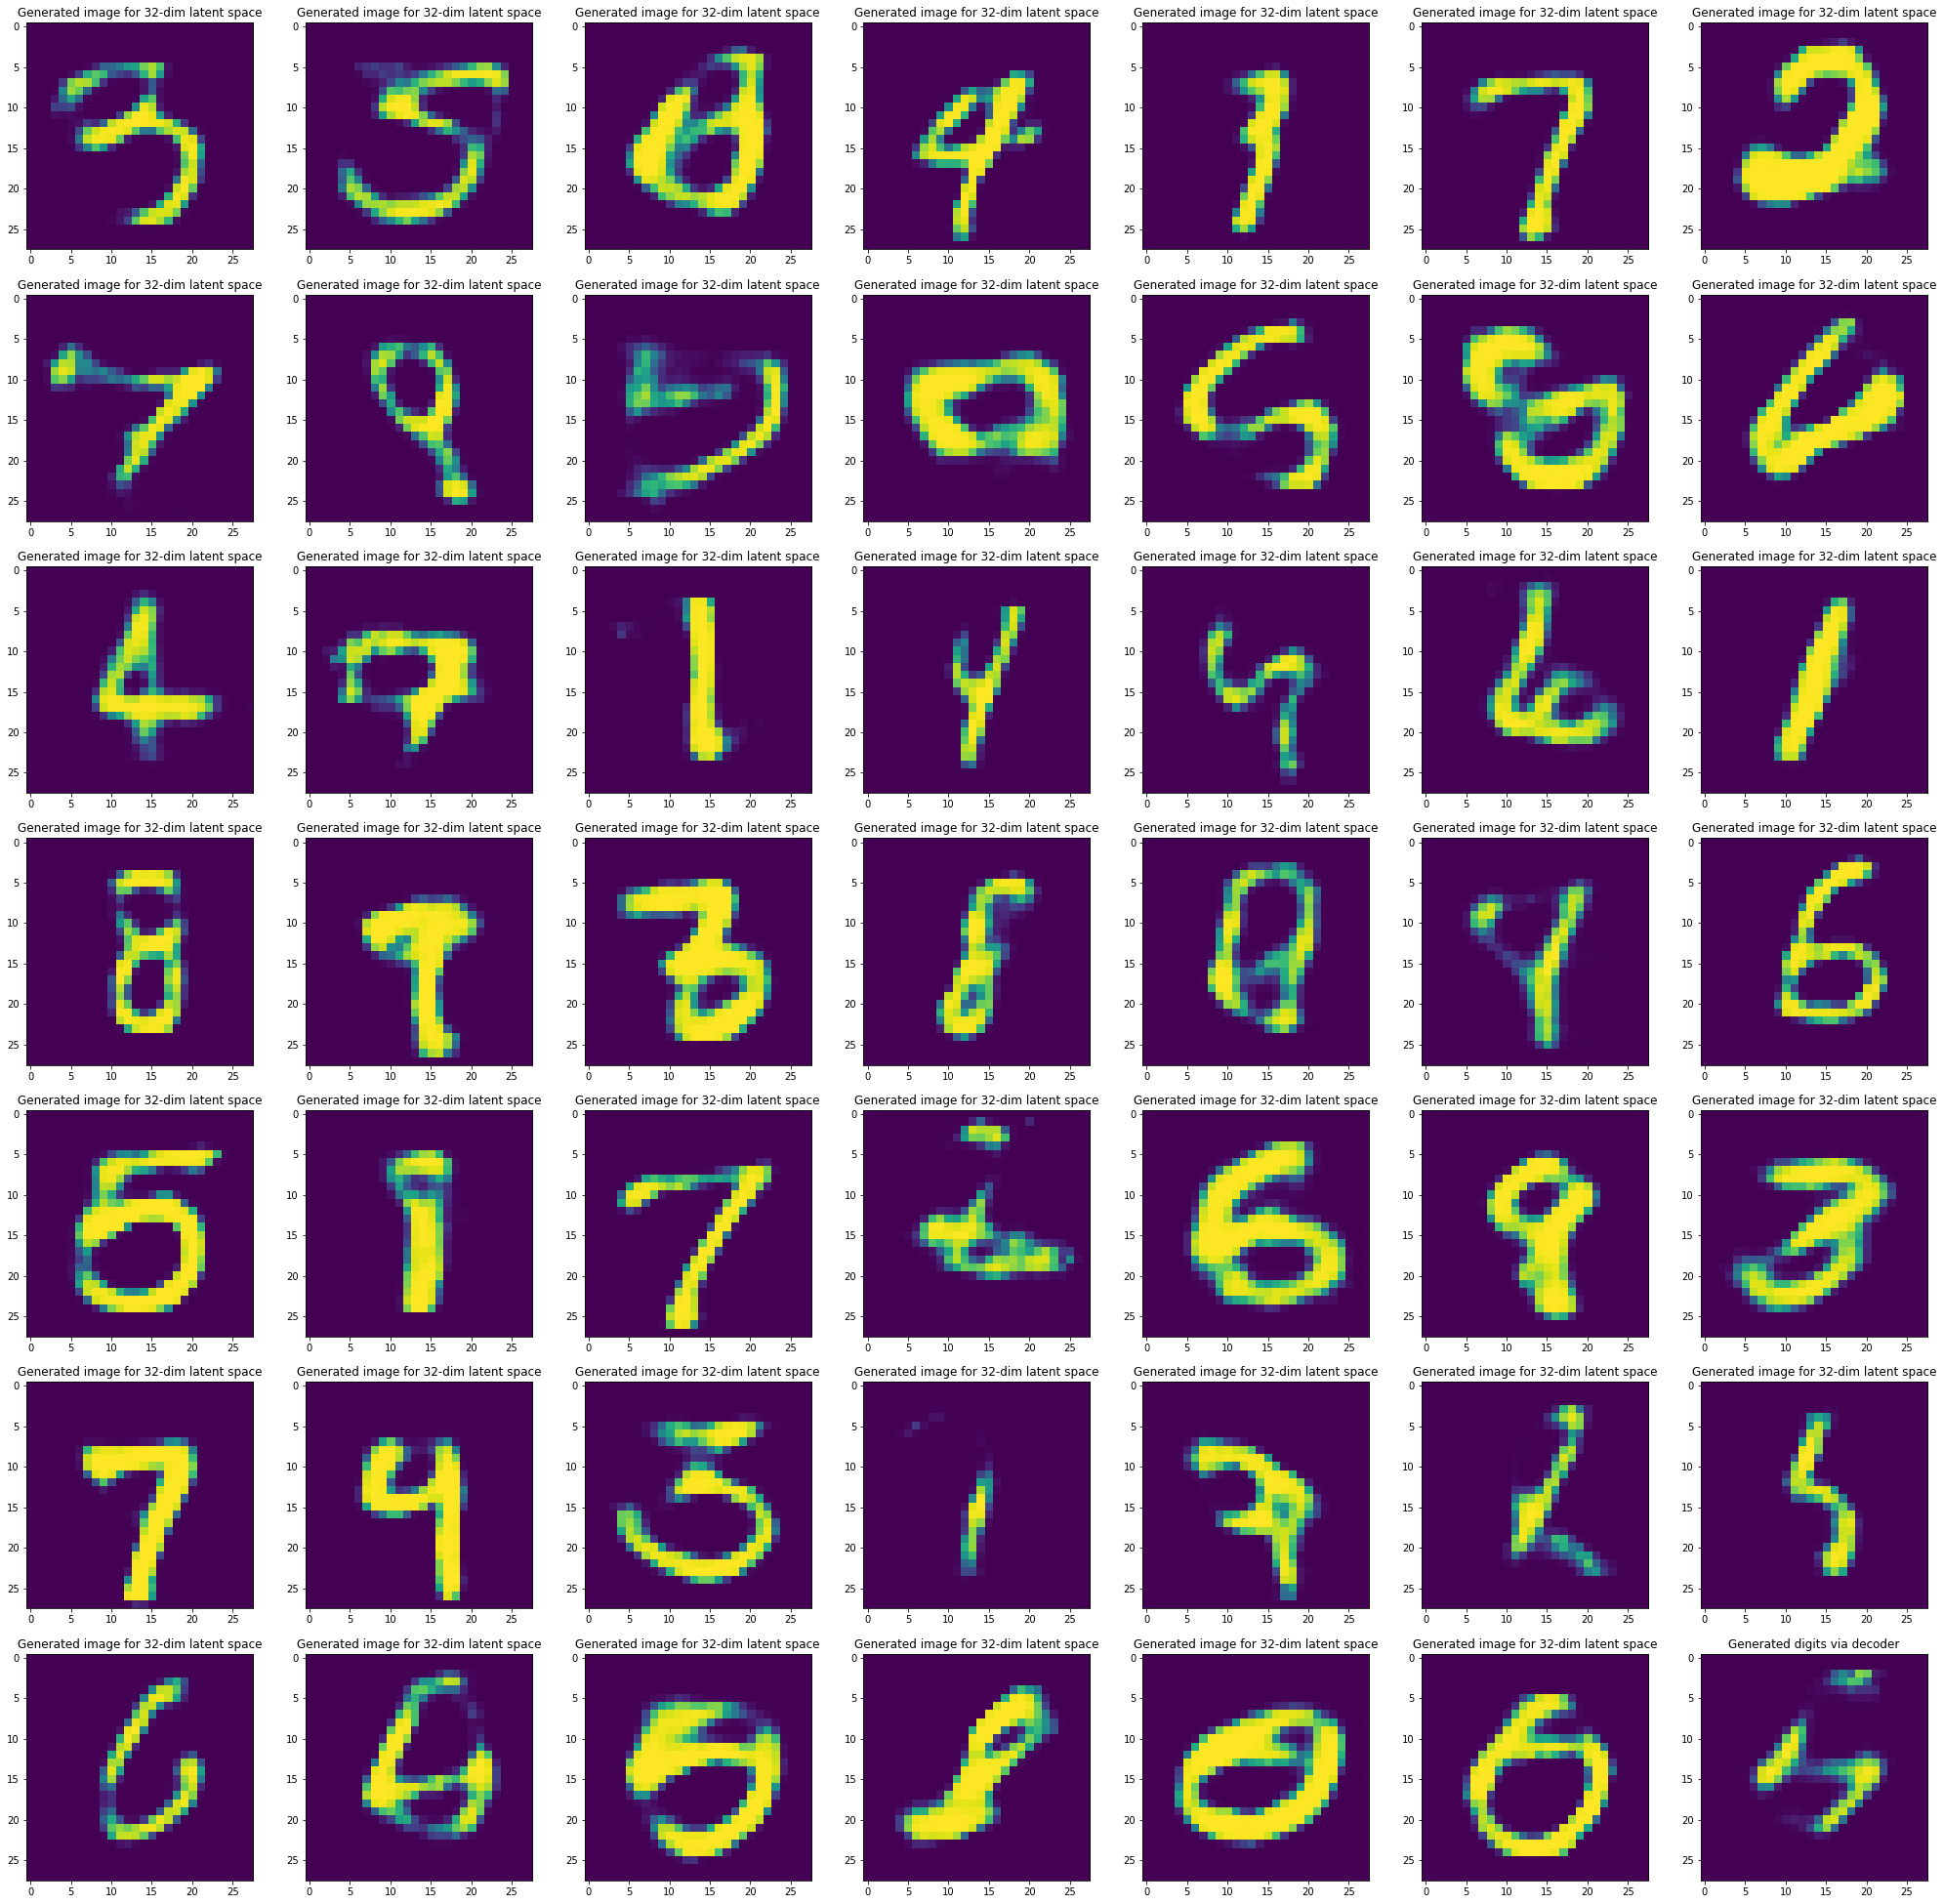

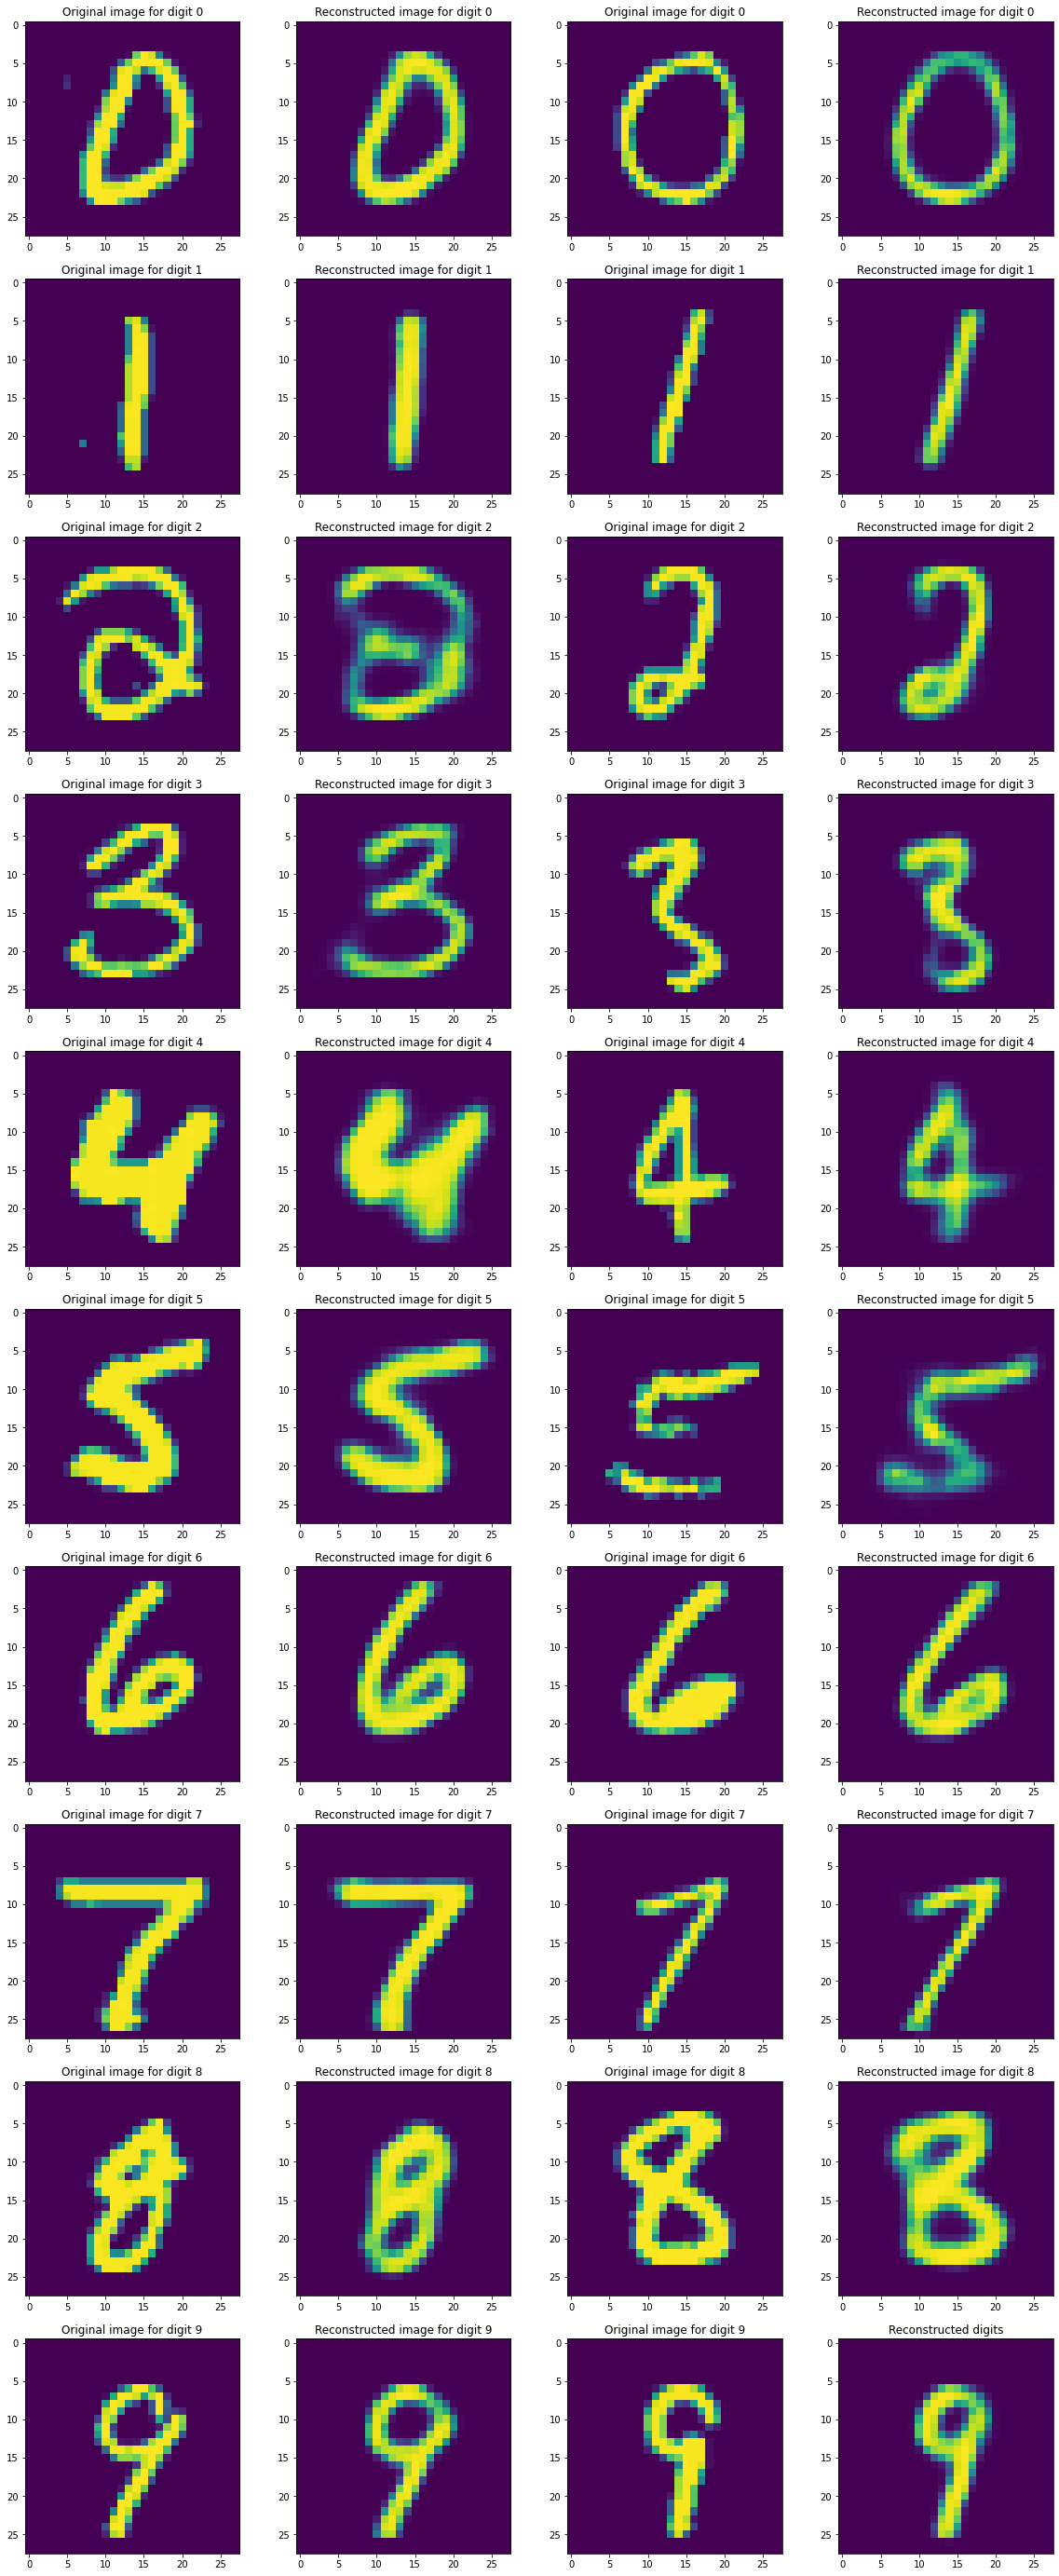

In [19]:
run(latent_dim=32, epochs=50)

Epoch 1/100
469/469 [==============================] - 3s 5ms/step - loss: 176.0467 - val_loss: 137.8060
Epoch 2/100
469/469 [==============================] - 2s 5ms/step - loss: 128.5567 - val_loss: 120.3139
Epoch 3/100
469/469 [==============================] - 2s 5ms/step - loss: 118.4224 - val_loss: 114.5068
Epoch 4/100
469/469 [==============================] - 2s 5ms/step - loss: 113.8681 - val_loss: 110.9091
Epoch 5/100
469/469 [==============================] - 2s 5ms/step - loss: 111.1456 - val_loss: 109.0299
Epoch 6/100
469/469 [==============================] - 2s 5ms/step - loss: 109.2184 - val_loss: 107.6820
Epoch 7/100
469/469 [==============================] - 2s 5ms/step - loss: 107.8554 - val_loss: 106.8234
Epoch 8/100
469/469 [==============================] - 2s 5ms/step - loss: 106.7853 - val_loss: 105.6497
Epoch 9/100
469/469 [==============================] - 2s 5ms/step - loss: 105.9510 - val_loss: 105.0652
Epoch 10/100
469/469 [==============================] -

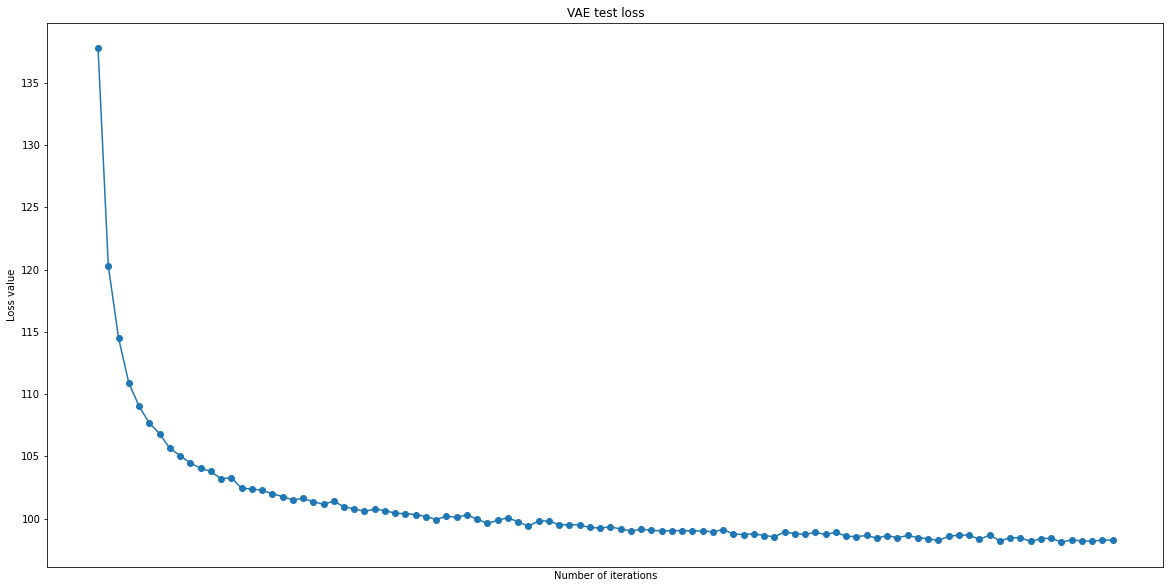

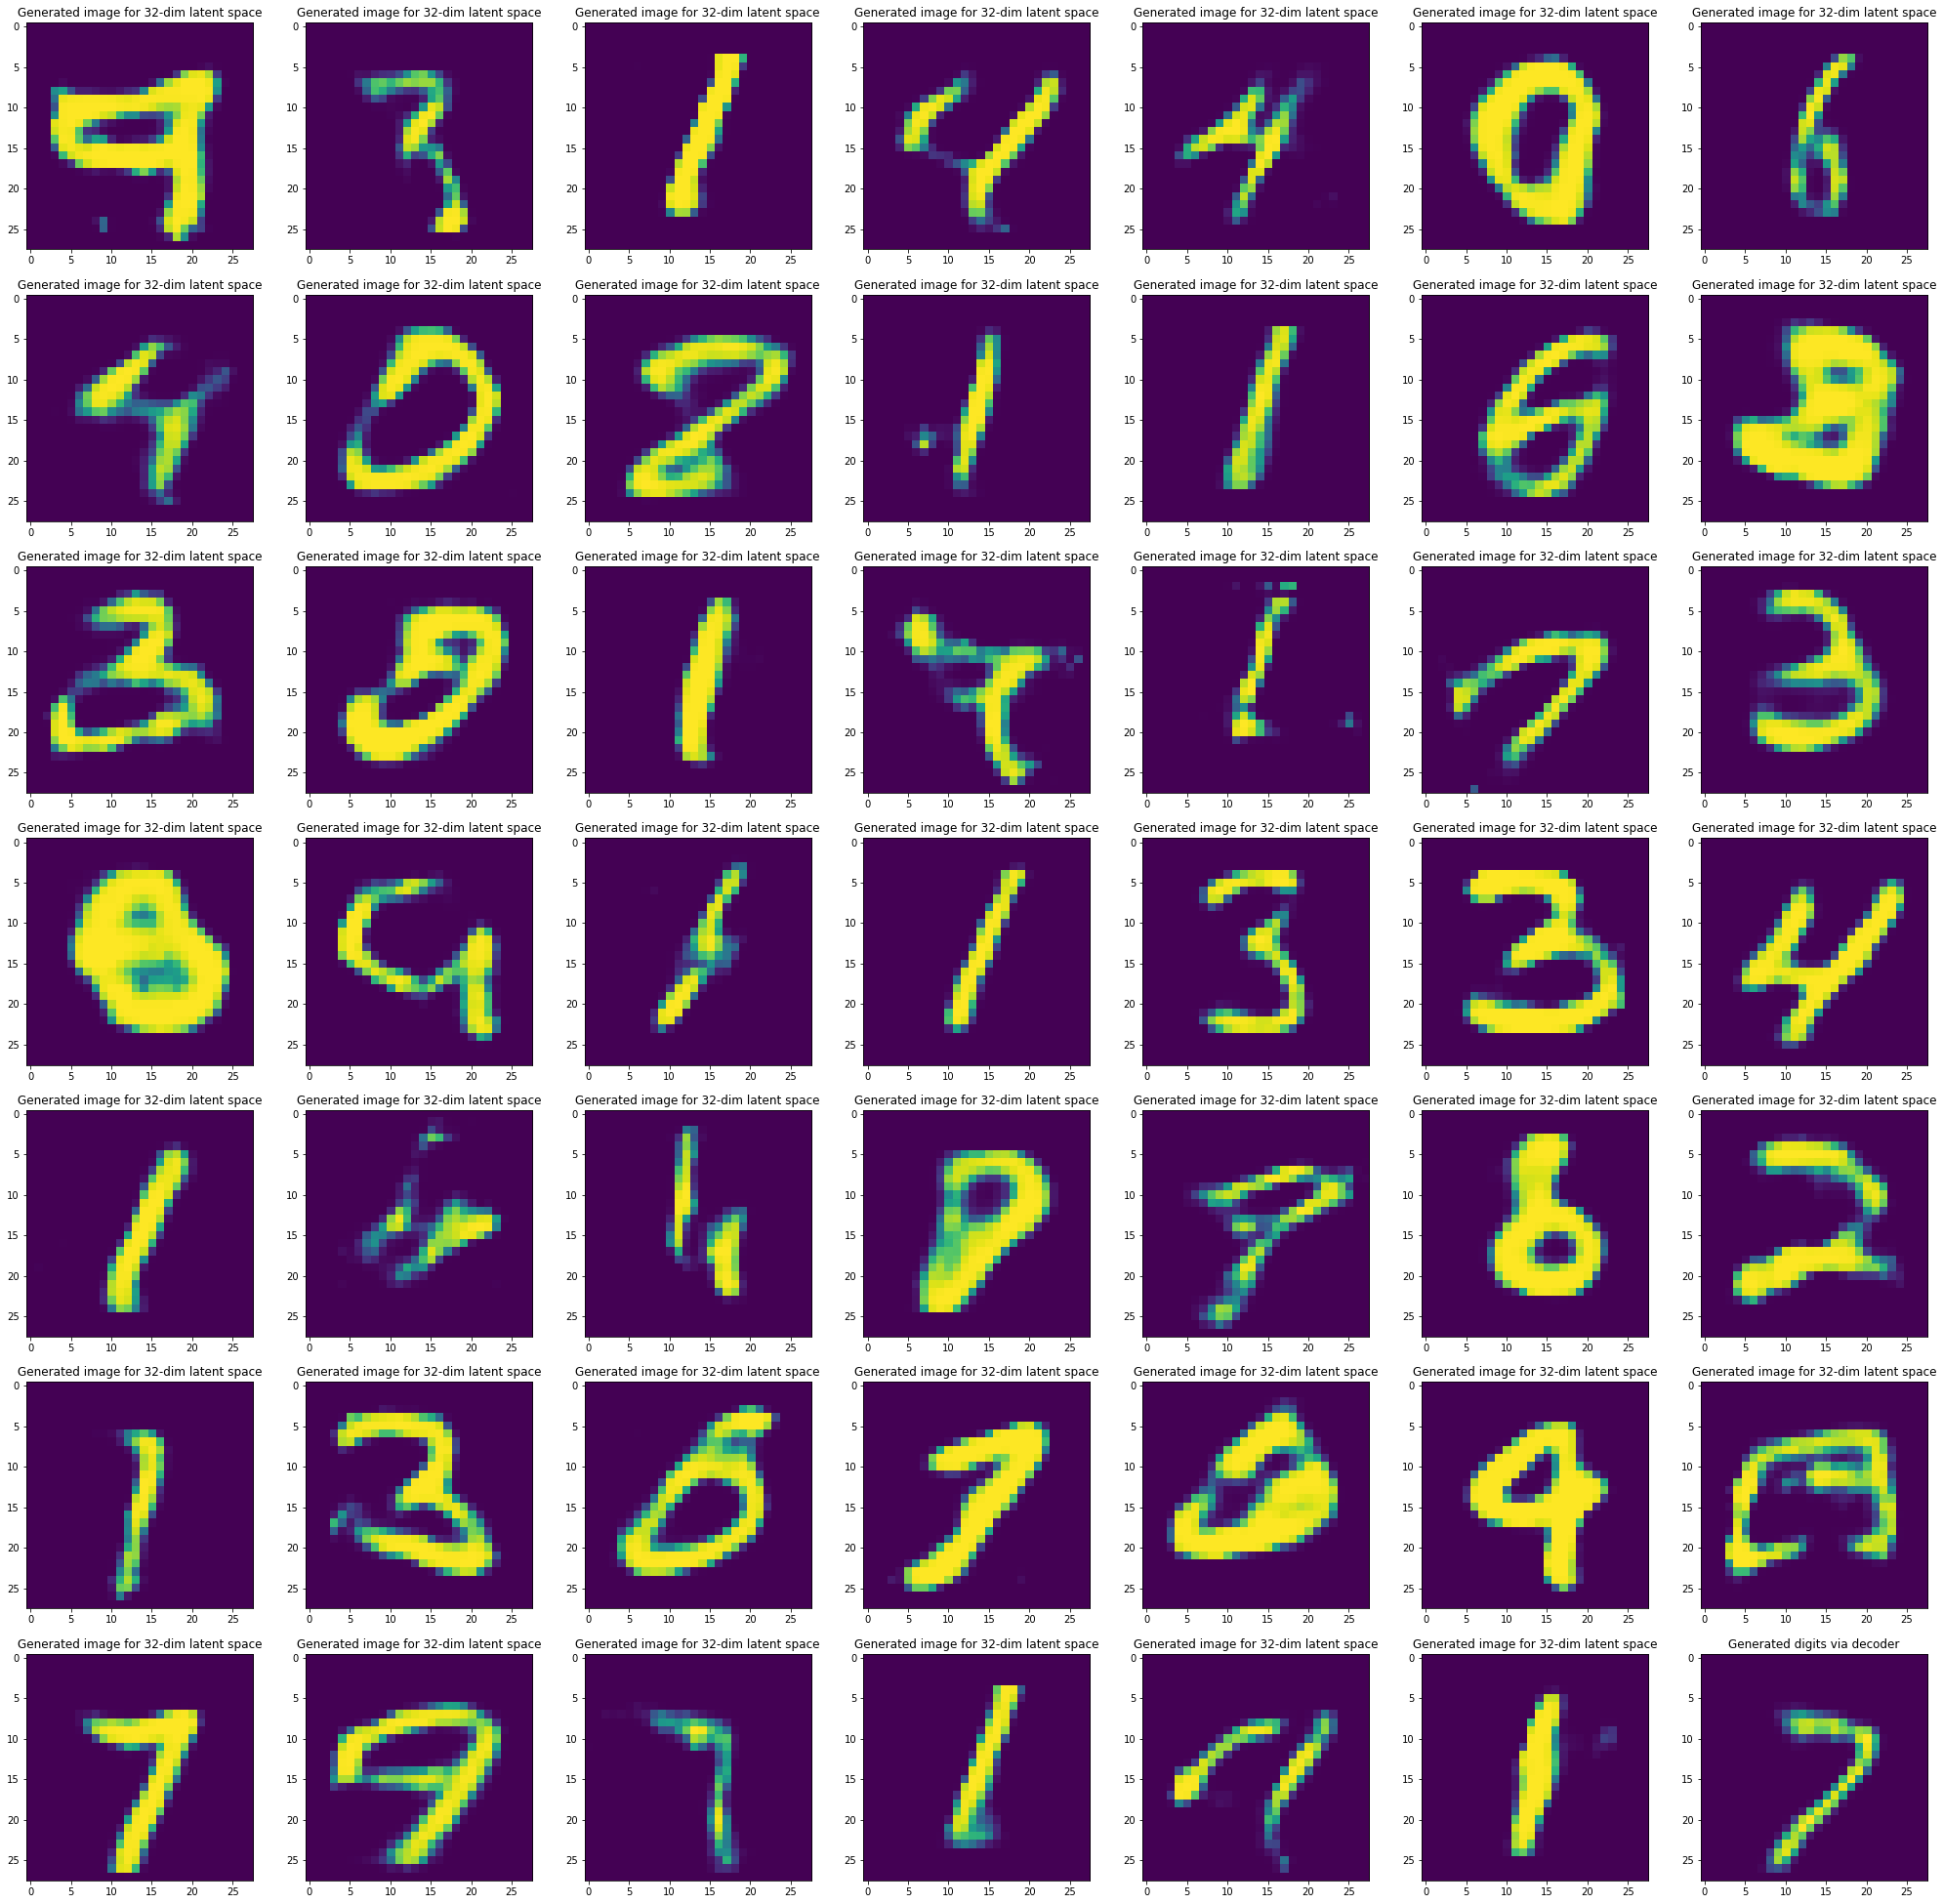

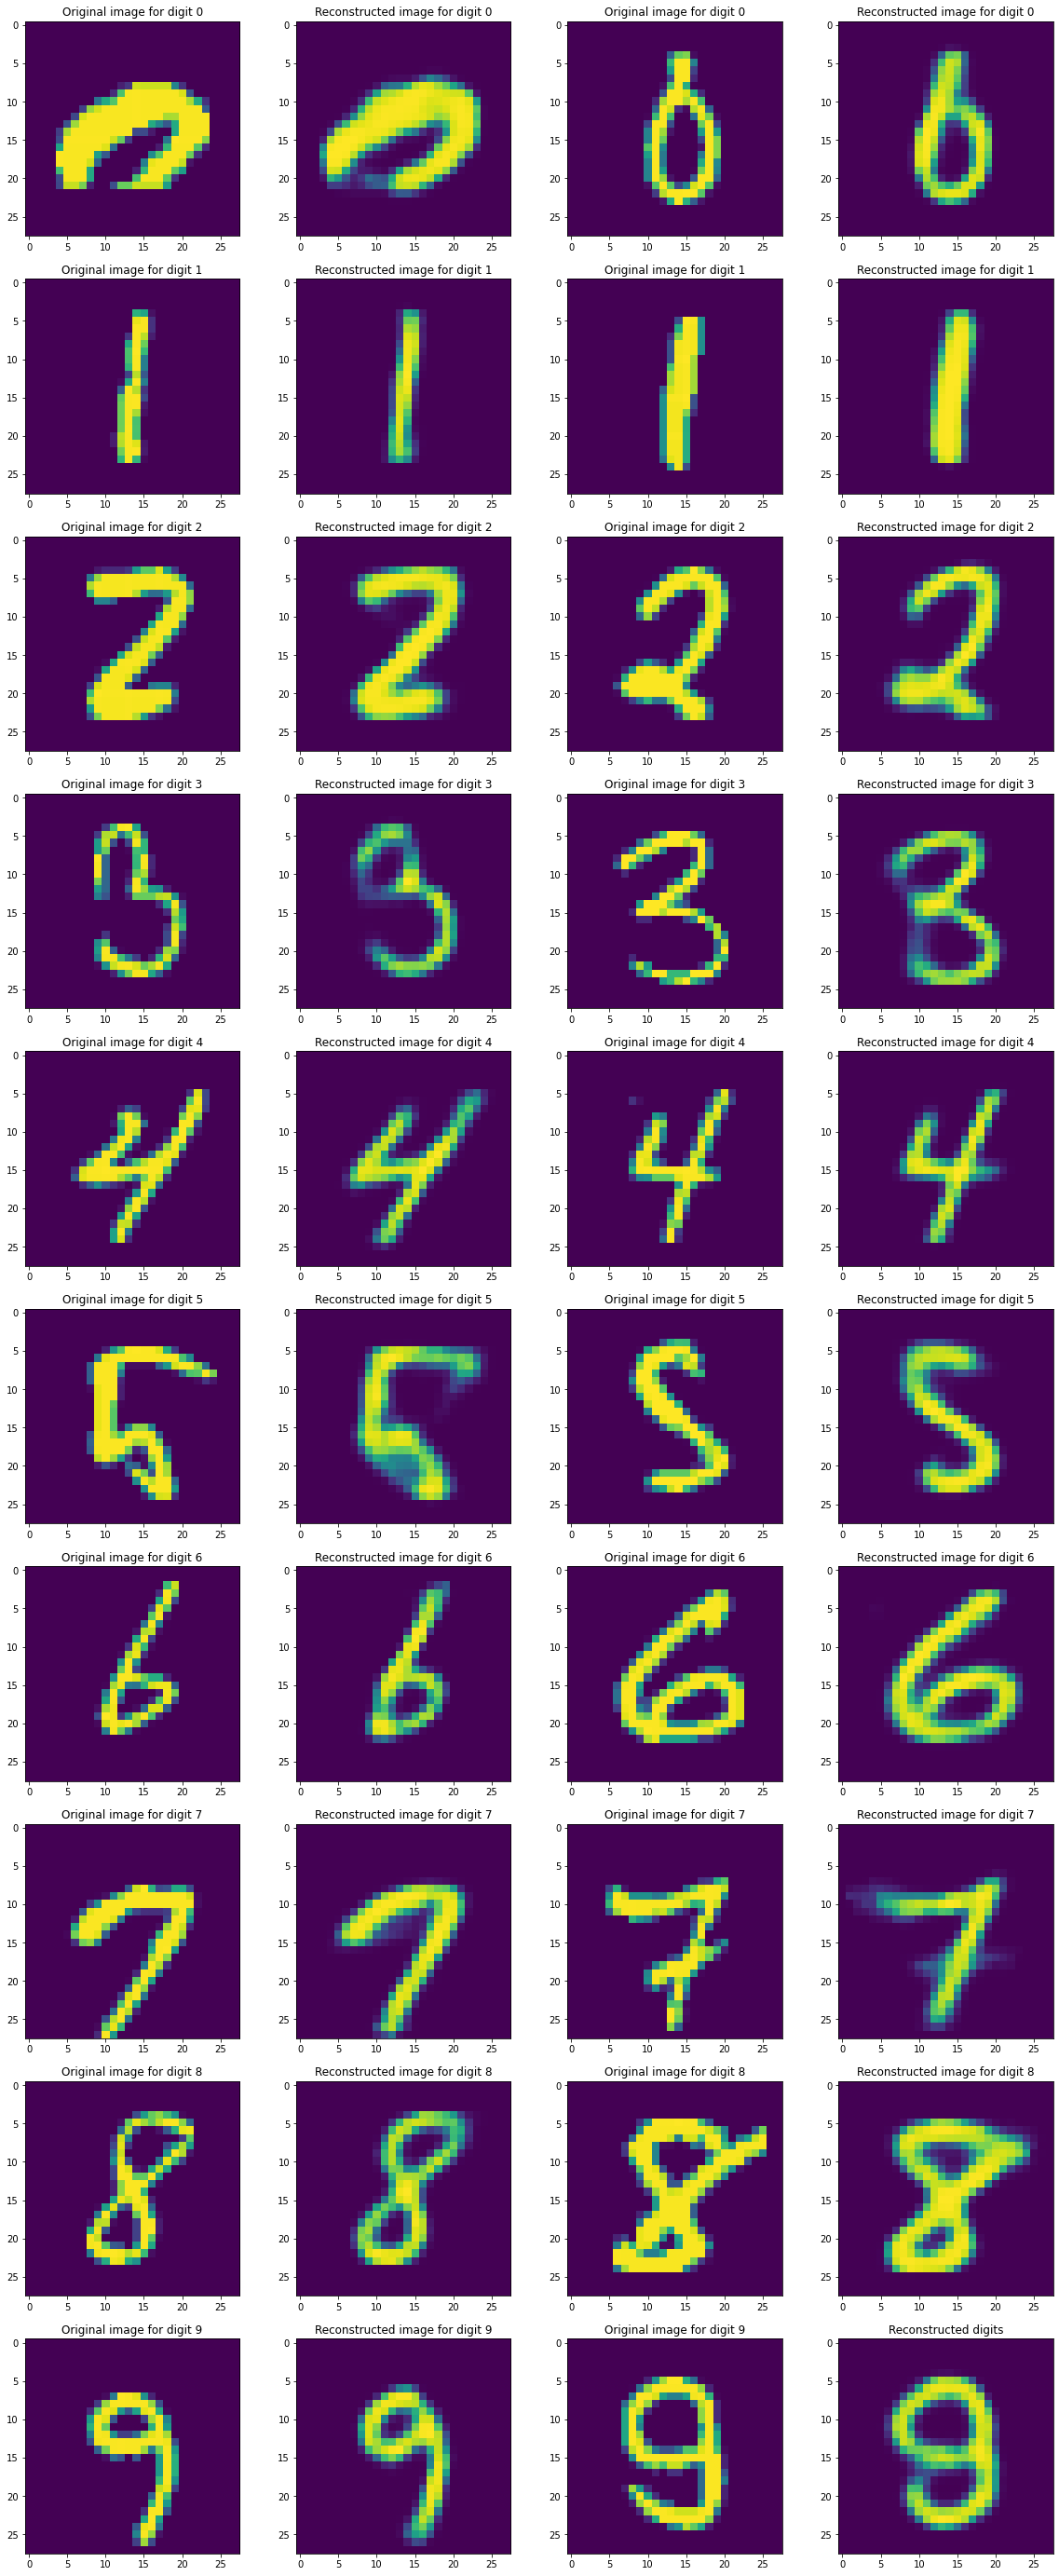

In [20]:
run(latent_dim=32, epochs=100)